# Previsione della Qualità dell'Aria - **Allenamento e Valutazione dei Modelli India**

## Caricamento dei Datasets ed Import Librerie



In [1]:
!pip install pykan

In [2]:
%env CUDA_LAUNCH_BLOCKING=1

env: CUDA_LAUNCH_BLOCKING=1


In [3]:
import json
import inspect
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns
import types
sns.set_theme()

try:
    import google.colab
    running_in_colab = True
except ImportError:
    running_in_colab = False

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    confusion_matrix,
    classification_report,
    roc_auc_score,
    average_precision_score
)
from sklearn.model_selection import (
    TimeSeriesSplit,
    RandomizedSearchCV,
    ParameterSampler
)

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, Subset
import torch.nn.utils.prune as prune
from torch.nn.functional import softmax

%pip install xgboost
import xgboost as xgb
from kan import *

N_JOBS = -1
RANDOM_STATE = 42

Note: you may need to restart the kernel to use updated packages.


In [4]:
github_url = 'https://raw.githubusercontent.com/vMxster/Data_Project/main/Datasets/original_india_dataset.csv'
local_path = '/scratch.hpc/martin.tomassi/datasets_pm'
local_file = os.path.join(local_path, 'original_india_dataset.csv')

if not os.path.exists(local_path):
    os.makedirs(local_path)

if not os.path.exists(local_file):
    df = pd.read_csv(github_url,
                     sep=',',
                     quotechar='"',
                     dtype=None,
                     parse_dates=True,
                     low_memory=False)
    df.to_csv(local_file, index=False)
    print("File scaricato e salvato in locale.")
else:
    print("Il file esiste già in locale, lo carico...")
    df = pd.read_csv(local_file,
                     sep=',',
                     quotechar='"',
                     dtype=None,
                     parse_dates=True,
                     low_memory=False)

obj_cols = df.select_dtypes(include="object").columns
for col in obj_cols:
    df[col] = df[col].astype("category")
df.drop('date', axis=1, inplace=True)
df = df[(df['year'] >= 2018)]
df = df.reset_index(drop=True)
df.head()

File scaricato e salvato in locale.


,year,month,dayofmonth,state,PM2.5,CO,O3,dayofweek,quarter,weekofyear,...,pm_lag_1D,co_lag_1D,o3_lag_1D,pm_lag_2D,co_lag_2D,o3_lag_2D,pm_lag_3D,co_lag_3D,o3_lag_3D,Class
0,2018,1,1,Bihar,248.338542,1.253194,25.368750,0,1,1,...,205.467292,1.088611,23.453125,265.163333,1.719167,12.699167,234.609375,1.699861,11.677917,6
1,2018,1,1,Odisha,48.950000,3.310000,0.020000,0,1,1,...,48.950000,3.310000,0.020000,48.950000,3.447083,0.020000,48.950000,3.357083,0.015000,3
2,2018,1,1,West Bengal,11.015000,0.985417,13.758958,0,1,1,...,11.015000,1.000833,14.120625,11.015000,0.877500,12.428333,11.015000,1.125000,12.632708,2
3,2018,1,1,Andhra Pradesh,53.847778,0.723542,51.598333,0,1,1,...,51.303542,0.657500,49.261250,50.059861,0.672188,43.236424,56.092118,0.733437,43.451597,3
4,2018,1,1,Gujarat,84.484167,0.863750,44.890000,0,1,1,...,83.526250,0.887500,64.475833,81.357083,1.103750,51.791667,85.548750,1.254167,56.731667,4


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43961 entries, 0 to 43960
Data columns (total 33 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   year        43961 non-null  int64   
 1   month       43961 non-null  int64   
 2   dayofmonth  43961 non-null  int64   
 3   state       43961 non-null  category
 4   PM2.5       43961 non-null  float64 
 5   CO          43961 non-null  float64 
 6   O3          43961 non-null  float64 
 7   dayofweek   43961 non-null  int64   
 8   quarter     43961 non-null  int64   
 9   weekofyear  43961 non-null  int64   
 10  dayofyear   43961 non-null  int64   
 11  pm_lag_1Y   38402 non-null  float64 
 12  co_lag_1Y   38402 non-null  float64 
 13  o3_lag_1Y   38402 non-null  float64 
 14  pm_lag_2Y   32899 non-null  float64 
 15  co_lag_2Y   32899 non-null  float64 
 16  o3_lag_2Y   32899 non-null  float64 
 17  pm_lag_1M   43541 non-null  float64 
 18  co_lag_1M   43541 non-null  float64 
 19  o3_l

In [6]:
class_counts = df['Class'].value_counts()
print(class_counts)

Class
2    17970
4    11947
3     9110
1     2573
5     1989
6      372
Name: count, dtype: int64


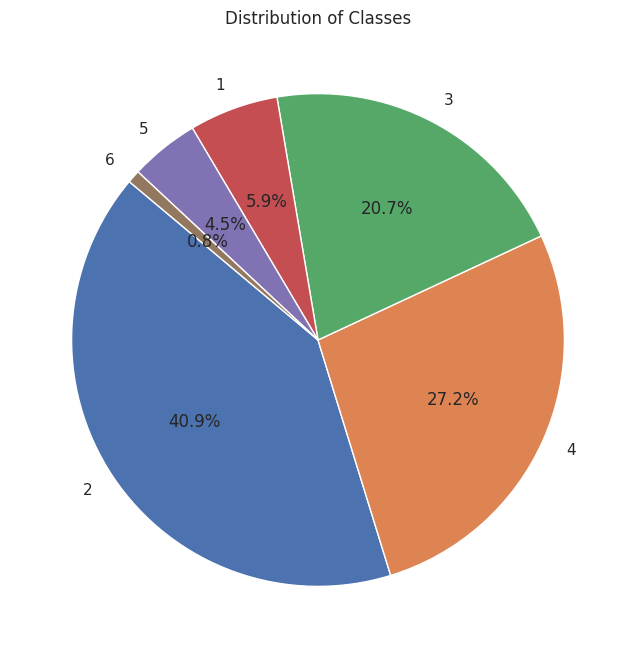

In [7]:
plt.figure(figsize=(8, 8))
plt.pie(class_counts, labels=class_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Classes')
plt.show()

# Addestramento modelli
A seguito dell'esplorazione e dell'omogeneizzazione dei due dataset, si può procedere all'addestramento dei modelli. I modelli verranno addestrati sulle seguenti feature indipendenti:
- `year`: anno della misurazione
- `month`: mese dell’anno
- `dayofmonth`: giorno del mese
- `dayofweek`: giorno della settimana
- `dayofyear`: giorno dell’anno
- `weekofyear`: settimana dell’anno
- `quarter`: trimestre dell’anno
- `state`: stato di misurazione
- `pm_lag_1W`: PM2.5 ritardato di 1 settimana
- `pm_lag_1M`: PM2.5 ritardato di 1 mese
- `pm_lag_1Y`: PM2.5 ritardato di 1 anno
- `pm_lag_1D`: PM2.5 ritardato di 1 giorno
- `pm_lag_2D`: PM2.5 ritardato di 2 giorni
- `pm_lag_3D`: PM2.5 ritardato di 3 giorni
- `co_lag_1W`: CO ritardato di 1 settimana
- `co_lag_1M`: CO ritardato di 1 mese
- `co_lag_1Y`: CO ritardato di 1 anno
- `co_lag_1D`: CO ritardato di 1 giorno
- `co_lag_2D`: CO ritardato di 2 giorni
- `co_lag_3D`: CO ritardato di 1 anno
- `o3_lag_1W`: O3 ritardato di 1 settimana
- `o3_lag_1M`: O3 ritardato di 1 mese
- `o3_lag_1Y`: O3 ritardato di 1 anno
- `o3_lag_1D`: O3 ritardato di 1 giorno
- `o3_lag_2D`: O3 ritardato di 2 giorni
- `o3_lag_3D`: O3 ritardato di 3 giorni

La variabile target per il nostro modello di addestramento sarà una variabile **discreta**, composta da 6 valori distinti. Questi valori rappresentano i diversi livelli di qualità dell'aria, come definiti dalla scala dell'**Environmental Protection Agency (EPA)** degli Stati Uniti per la concentrazione di PM2.5.

Possiamo mappare numericamente questi livelli alle seguenti classi, mantenendo l'ordine implicito di gravità:

* **1: "Good"** (Concentrazione di PM2.5: $0 - 9.0 \mu g/m^3$)
* **2: "Moderate"** (Concentrazione di PM2.5: $9.1 - 35.4 \mu g/m^3$)
* **3: "Unhealthy for Sensitive Groups"** (Concentrazione di PM2.5: $35.5 - 55.4 \mu g/m^3$)
* **4: "Unhealthy"** (Concentrazione di PM2.5: $55.5 - 125.4 \mu g/m^3$)
* **5: "Very Unhealthy"** (Concentrazione di PM2.5: $125.5 - 225.4 \mu g/m^3$)
* **6: "Hazardous"** (Concentrazione di PM2.5: $> 225.5 \mu g/m^3$)

Adottando questo schema, il problema si configura come un task di **classificazione multi-classe**. L'obiettivo del modello sarà prevedere a quale di questi 6 livelli di qualità dell'aria (o "categorie di rischio") appartiene una data osservazione, basandosi sulle caratteristiche di input fornite.

## Preparazione Dataset
Per garantire un confronto equo tra tutti i modelli, alcuni dei quali non supportano i valori mancanti generati dalle lag features, elimineremo tutte le righe che li contengono. Va però tenuto presente che così facendo perdiamo un anno di dati storici. Modelli come XGBoost di scikit-learn sono in grado di gestire internamente i missing value e potrebbero beneficiarne; tuttavia, per mantenere omogenee le condizioni di allenamento, applichiamo il drop completo dei NaN.

In [8]:
target = 'Class'
lag_features = ['pm_lag_1Y', 'pm_lag_2Y', 'pm_lag_1M', 'pm_lag_1W','co_lag_1Y', 'co_lag_2Y', 'co_lag_1M', 'co_lag_1W','o3_lag_1Y', 'o3_lag_2Y', 'o3_lag_1M', 'o3_lag_1W','pm_lag_1D','co_lag_1D','o3_lag_1D','pm_lag_2D','co_lag_2D','o3_lag_2D','pm_lag_3D','co_lag_3D','o3_lag_3D']
date_features = ['dayofmonth', 'dayofweek', 'dayofyear', 'weekofyear', 'month', 'quarter', 'year', 'state']
predictors = date_features + lag_features

In [9]:
def create_train_test_sets(dataframe, split, replace_na=False, method='none'):
    dataframe = dataframe.copy()

    if replace_na and method == 'zeros':
      dataframe = dataframe.fillna(0)
    elif replace_na and method == 'drop':
      dataframe = dataframe.dropna(how='any')

    train_set, test_set = np.split(dataframe, [int(len(dataframe) * split)])
    return train_set[predictors], test_set[predictors], train_set[target], test_set[target]

In [10]:
X_train, X_test, y_train, y_test = create_train_test_sets(
    df,
    split=0.8,
    replace_na=True,
    method='drop'
)

# Resetta gli indici dei risultati eliminando l’indice precedente,
# in modo da partire da zero ed avere indici continui
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

/scratch.hpc/martin.tomassi/venv_pm/lib/python3.11/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [11]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26319 entries, 0 to 26318
Data columns (total 29 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   dayofmonth  26319 non-null  int64   
 1   dayofweek   26319 non-null  int64   
 2   dayofyear   26319 non-null  int64   
 3   weekofyear  26319 non-null  int64   
 4   month       26319 non-null  int64   
 5   quarter     26319 non-null  int64   
 6   year        26319 non-null  int64   
 7   state       26319 non-null  category
 8   pm_lag_1Y   26319 non-null  float64 
 9   pm_lag_2Y   26319 non-null  float64 
 10  pm_lag_1M   26319 non-null  float64 
 11  pm_lag_1W   26319 non-null  float64 
 12  co_lag_1Y   26319 non-null  float64 
 13  co_lag_2Y   26319 non-null  float64 
 14  co_lag_1M   26319 non-null  float64 
 15  co_lag_1W   26319 non-null  float64 
 16  o3_lag_1Y   26319 non-null  float64 
 17  o3_lag_2Y   26319 non-null  float64 
 18  o3_lag_1M   26319 non-null  float64 
 19  o3_l

In [12]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6580 entries, 0 to 6579
Data columns (total 29 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   dayofmonth  6580 non-null   int64   
 1   dayofweek   6580 non-null   int64   
 2   dayofyear   6580 non-null   int64   
 3   weekofyear  6580 non-null   int64   
 4   month       6580 non-null   int64   
 5   quarter     6580 non-null   int64   
 6   year        6580 non-null   int64   
 7   state       6580 non-null   category
 8   pm_lag_1Y   6580 non-null   float64 
 9   pm_lag_2Y   6580 non-null   float64 
 10  pm_lag_1M   6580 non-null   float64 
 11  pm_lag_1W   6580 non-null   float64 
 12  co_lag_1Y   6580 non-null   float64 
 13  co_lag_2Y   6580 non-null   float64 
 14  co_lag_1M   6580 non-null   float64 
 15  co_lag_1W   6580 non-null   float64 
 16  o3_lag_1Y   6580 non-null   float64 
 17  o3_lag_2Y   6580 non-null   float64 
 18  o3_lag_1M   6580 non-null   float64 
 19  o3_lag

In [13]:
print(y_train.value_counts())

Class
2    10177
4     8159
3     5925
5     1436
6      323
1      299
Name: count, dtype: int64


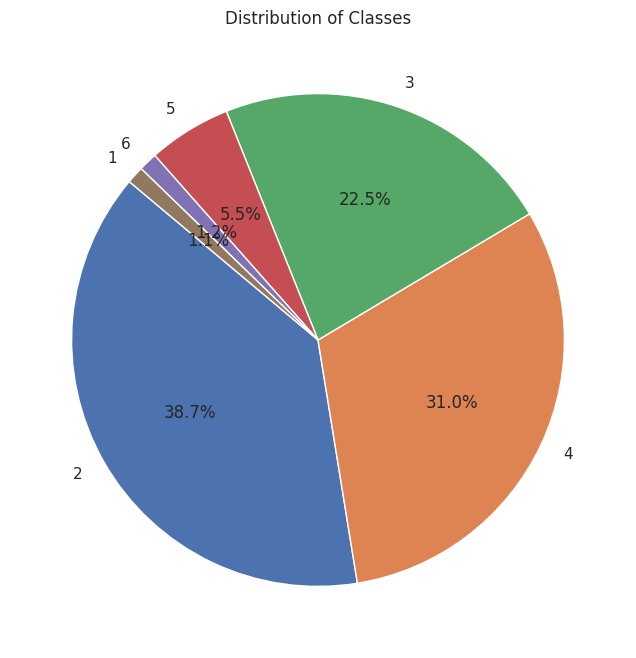

In [14]:
plt.figure(figsize=(8, 8))
plt.pie(y_train.value_counts(), labels=y_train.value_counts().index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Classes')
plt.show()

In [15]:
print(y_test.value_counts())

Class
2    2727
4    1831
3    1364
1     321
5     307
6      30
Name: count, dtype: int64


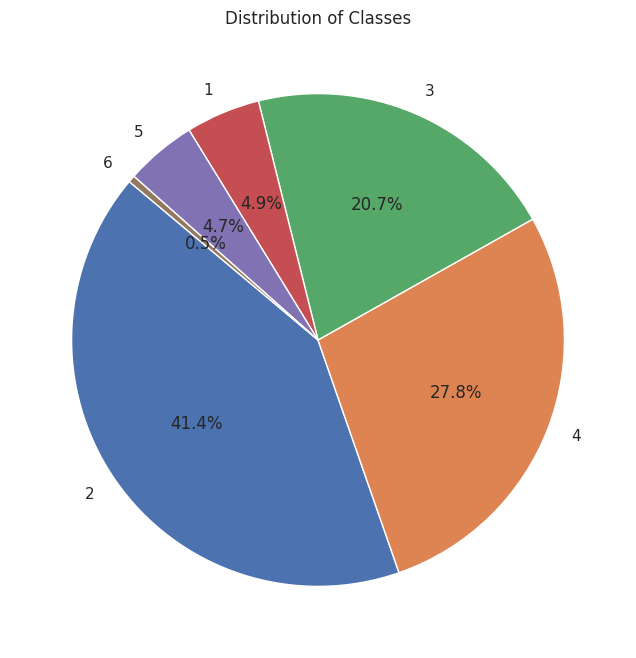

In [16]:
plt.figure(figsize=(8, 8))
plt.pie(y_test.value_counts(), labels=y_test.value_counts().index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Classes')
plt.show()

Nel dataset ci sono sia feature numeriche che categoriche. <br>
Per le numeriche è necessario applicare una normalizzazione dei dati, i quali avrebbero altrimenti valori su scale molto diverse che renderebbero più difficile la convergenza del modello. <br>
Per poter utilizzare le variabili categoriche nell'addestramento di un modello di regressione si usa un OneHotEncoder, creando nuove colonne binarie per ciascuno dei valori ammissibili dalla variabile categorica.

In [17]:
categorical_features = X_train.select_dtypes(include=["category"]).columns.tolist()
numerical_features   = [c for c in X_train.columns if c not in categorical_features]

preprocessor = ColumnTransformer([
    # Standardizza tutte le colonne numeriche
    ("numeric",    StandardScaler(),    numerical_features),
    # One‑hot encoding di 'state', ignorando nuovi stati in predict
    ("categorical", OneHotEncoder(handle_unknown="ignore"), categorical_features),
])

Inizializzazione della lista per raccogliere le metriche dopo ogni training

In [18]:
all_scores = []

## Valutazione delle Prestazioni dei Modelli

Dopo l’allenamento di ciascun modello di Machine Learning e Deep Learning, utilizziamo le funzioni `get_estimator_scores` e `get_torch_estimator_scores` per calcolare diverse metriche di valutazione, includendo per le principali anche gli **Intervalli di Confidenza al 95%** (CI95%) stimati tramite bootstrap resampling.

Queste metriche sono state scelte specificamente per valutare l'efficacia dei modelli in problemi di **classificazione multi-classe, con particolare attenzione alle classi sbilanciate**.

Le metriche calcolate sono:

1.  **Accuracy Score**
    Misura la percentuale di istanze classificate correttamente dal modello. Sebbene sia una metrica intuitiva, può essere fuorviante in presenza di classi sbilanciate, poiché un modello che classifica correttamente solo la classe maggioritaria può comunque mostrare un'alta accuratezza.
    *(Più alto è, meglio è.)*

2.  **F1-Score (Weighted)**
    L'F1-Score è la media armonica della Precisione e del Recall. La versione "weighted" calcola la media di F1-Score per ciascuna classe, pesandola in base al numero di istanze di quella classe nel dataset. Questa metrica è particolarmente utile per dataset con classi sbilanciate, in quanto fornisce una visione più bilanciata delle prestazioni del modello su tutte le classi, evitando di essere dominata dalla classe maggioritaria.
    *(Più alto è, meglio è.)*

3.  **F1-Score (Macro)**
    La versione "macro" dell'F1-Score calcola la media non pesata di F1-Score per ciascuna classe. Questo significa che ogni classe contribuisce in modo uguale alla metrica finale, indipendentemente dal suo numero di campioni. È utile quando tutte le classi, comprese quelle minoritarie, hanno la stessa importanza.
    *(Più alto è, meglio è.)*

4.  **Matrice di Confusione**
    Una tabella che riassume le prestazioni di un algoritmo di classificazione. Mostra il numero di previsioni corrette e sbagliate per ciascuna classe, indicando dove il modello sta confondendo le diverse categorie. È fondamentale per comprendere gli errori specifici del modello.

5.  **Classification Report**
    Fornisce un riepilogo dettagliato delle metriche di Precisione, Recall e F1-Score per ciascuna classe, oltre a metriche aggregate (macro avg, weighted avg). È uno strumento essenziale per una valutazione approfondita delle prestazioni per classe.

6.  **AUC-ROC (Area Under the Receiver Operating Characteristic Curve) - One-vs-Rest Weighted**
    L'AUC-ROC misura la capacità del modello di distinguere tra le classi. Per problemi multi-classe, si calcola spesso in modalità "one-vs-rest", trattando ogni classe come "positiva" e tutte le altre come "negative". La versione "weighted" ne calcola la media pesata per la frequenza delle classi, rendendola più robusta per dataset sbilanciati. Un valore più vicino a 1 indica una maggiore capacità discriminatoria.
    *(Più alto è, meglio è.)*

7.  **AUC-PR (Area Under the Precision-Recall Curve) - One-vs-Rest Weighted**
    L'AUC-PR è particolarmente utile per dataset con classi sbilanciate e quando la classe positiva (minoritaria) è di maggiore interesse. Misura l'area sotto la curva Precision-Recall, offrendo una valutazione più accurata della capacità del modello di identificare correttamente le istanze positive rispetto all'AUC-ROC, che può essere ottimistica in presenza di un grande numero di veri negativi. Per multi-classe, viene calcolata in modalità "one-vs-rest" e mediata pesando per la frequenza delle classi.
    *(Più alto è, meglio è.)*

In [19]:
def count_params(model):
    if isinstance(model, ImbPipeline):
        model = model.steps[-1][1]

    if hasattr(model, 'parameters') and inspect.ismethod(model.parameters) and not isinstance(model, KAN):
        try:
            return sum(p.numel() for p in model.parameters() if p.requires_grad)
        except Exception:
            return 0

    elif isinstance(model, KAN):
        try:
            if not model.width or len(model.width) < 2:
                return 0
            else:
                sum_edge_terms = 0
                for i in range(len(model.width) - 1):
                    Nl = model.width[i]
                    Nl_plus_1 = model.width[i+1]
                    if isinstance(Nl, list): Nl = Nl[0]
                    if isinstance(Nl_plus_1, list): Nl_plus_1 = Nl_plus_1[0]
                    G = model.grid
                    k = model.k
                    sum_edge_terms += Nl * Nl_plus_1 * (G + k - 1)
                return sum_edge_terms
        except Exception as e:
            print(f"Error calculating KAN parameters: {e}")
            return 0

    elif isinstance(model, RandomForestClassifier):
        total_nodes = 0
        if hasattr(model, 'estimators_'):
            for tree in model.estimators_:
                if hasattr(tree, 'tree_'):
                    total_nodes += tree.tree_.node_count
            return total_nodes
        else:
            return 0

    elif isinstance(model, xgb.XGBClassifier):
        total_nodes = 0

        try:
            booster = model.get_booster()
            tree_dumps = booster.get_dump(dump_format='json')

            def count_nodes_in_json_tree(node):
                count = 1
                if 'children' in node:
                    for child in node['children']:
                        count += count_nodes_in_json_tree(child)
                return count

            for tree_dump_str in tree_dumps:
                tree_json = json.loads(tree_dump_str)
                total_nodes += count_nodes_in_json_tree(tree_json)

            return total_nodes
        except Exception as e:
            print(f"Error calculating exact XGBoost complexity: {e}")
            return 0
    else:
        return 0

def bootstrap_ci(metric_fn, y_true, y_pred, n_bootstraps=1000, alpha=0.05, **metric_kwargs):
    y_true_arr = np.asarray(y_true)
    y_pred_arr = np.asarray(y_pred)
    vals = []
    n_samples = len(y_true)

    for _ in range(n_bootstraps):
        idx = np.random.randint(0, n_samples, n_samples)
        vals.append(metric_fn(y_true_arr[idx], y_pred_arr[idx], **metric_kwargs))

    low = np.percentile(vals, 100 * (alpha / 2))
    high = np.percentile(vals, 100 * (1 - alpha / 2))
    return low, high

def get_estimator_scores(model_name, model, X_test, y_test, X_train, y_train, all_scores_list):
    print(f"\n--- Valutazione Prestazioni per {model_name} ---")

    # Calcola la Complessitá dei Modelli
    param_count = count_params(model)
    print(f"Model Parameters/Nodes: {param_count}")

    # Previsioni (etichette hard) per test e train
    y_pred_test = model.predict(X_test)
    y_pred_train = model.predict(X_train)

    # Se il modello supporta predict_proba (per AUC)
    y_proba_test = None
    if hasattr(model, 'predict_proba'):
        y_proba_test = model.predict_proba(X_test) # Probabilità per ogni classe

    # --- Metriche su Training Set ---
    accuracy_tr = accuracy_score(y_train, y_pred_train)
    f1_weighted_tr = f1_score(y_train, y_pred_train, average='weighted', zero_division=0)
    f1_macro_tr = f1_score(y_train, y_pred_train, average='macro', zero_division=0)

    # --- Metriche su Test Set ---
    accuracy_te = accuracy_score(y_test, y_pred_test)
    f1_weighted_te = f1_score(y_test, y_pred_test, average='weighted', zero_division=0)
    f1_macro_te = f1_score(y_test, y_pred_test, average='macro', zero_division=0)

    # Bootstrap CI per F1-weighted
    f1_weighted_low, f1_weighted_high = bootstrap_ci(
        f1_score, y_test, y_pred_test, average='weighted', zero_division=0
    )
    f1_macro_low, f1_macro_high = bootstrap_ci(
        f1_score, y_test, y_pred_test, average='macro', zero_division=0
    )

    # Matrice di Confusione e Classification Report
    print("\nClassification Report (Test Set):")
    print(classification_report(y_test, y_pred_test, zero_division=0))

    print("\nConfusion Matrix (Test Set):")
    print(confusion_matrix(y_test, y_pred_test))

    # Raccolta dei punteggi
    scores_row = [
        model_name, param_count,
        accuracy_tr, accuracy_te,
        f1_weighted_tr, f1_weighted_te, f1_weighted_low, f1_weighted_high,
        f1_macro_tr, f1_macro_te, f1_macro_low, f1_macro_high
    ]

    # Calcolo AUC se possibile (necessita probabilità)
    if y_proba_test is not None:
        try:
            num_classes = len(np.unique(y_test))
            auc_roc_ovr = roc_auc_score(y_test, y_proba_test, multi_class='ovr', average='weighted')
            auc_pr_ovr = average_precision_score(pd.get_dummies(y_test), y_proba_test, average='weighted')

            # Bootstrap per AUC-ROC e AUC-PR
            auc_roc_low, auc_roc_high = bootstrap_ci(
                lambda yt, yp: roc_auc_score(yt, yp, multi_class='ovr', average='weighted'),
                y_test, y_proba_test
            )
            auc_pr_low, auc_pr_high = bootstrap_ci(
                lambda yt, yp: average_precision_score(pd.get_dummies(yt), yp, average='weighted'),
                y_test, y_proba_test
            )

            scores_row.extend([auc_roc_ovr, auc_roc_low, auc_roc_high, auc_pr_ovr, auc_pr_low, auc_pr_high])
            print(f"AUC-ROC (OVR, Weighted): {auc_roc_ovr:.3f}")
            print(f"AUC-PR (OVR, Weighted): {auc_pr_ovr:.3f}")

        except ValueError as e:
            print(f"Errore nel calcolo di AUC/PR: {e}. Probabilmente mancano classi o y_proba non è adatto.")
            scores_row.extend([np.nan, np.nan, np.nan, np.nan, np.nan, np.nan]) # Aggiungi NaN per le colonne AUC
    else:
        print("Modello non supporta predict_proba. AUC/PR non calcolabili.")
        scores_row.extend([np.nan, np.nan, np.nan, np.nan, np.nan, np.nan]) # Aggiungi NaN per le colonne AUC

    all_scores_list.append(scores_row)


def predict_torch(model, X_tensor, device):
    model.eval()
    with torch.no_grad():
        out = model(X_tensor.to(device))
    return out # Restituisce logit/probabilità, non etichette hard qui


def get_torch_estimator_scores(model_name, model,
                               X_train_tensor, y_train_tensor,
                               X_test_tensor, y_test_tensor,
                               device, all_scores_list):
    print(f"\n--- Valutazione Prestazioni per {model_name} (PyTorch) ---")

    # Calcola il numero di Parametri dei Modelli
    param_count = count_params(model)
    print(f"Model Parameters: {param_count}")

    # Ottieni output (logits/probabilità) dal modello
    y_pred_proba_train = predict_torch(model, X_train_tensor, device)
    y_pred_proba_test = predict_torch(model, X_test_tensor, device)

    # Converti le etichette vere (tensori) in numpy array per Scikit-learn
    y_train_np = y_train_tensor.detach().cpu().numpy()
    y_test_np = y_test_tensor.detach().cpu().numpy()

    # Se il modello emette logit, converti in probabilità e poi in etichette
    y_pred_labels_train = torch.argmax(softmax(y_pred_proba_train, dim=1), dim=1).detach().cpu().numpy()
    y_pred_labels_test = torch.argmax(softmax(y_pred_proba_test, dim=1), dim=1).detach().cpu().numpy()

    # --- Metriche su Training Set ---
    accuracy_tr = accuracy_score(y_train_np, y_pred_labels_train)
    f1_weighted_tr = f1_score(y_train_np, y_pred_labels_train, average='weighted', zero_division=0)
    f1_macro_tr = f1_score(y_train_np, y_pred_labels_train, average='macro', zero_division=0)

    # --- Metriche su Test Set ---
    accuracy_te = accuracy_score(y_test_np, y_pred_labels_test)
    f1_weighted_te = f1_score(y_test_np, y_pred_labels_test, average='weighted', zero_division=0)
    f1_macro_te = f1_score(y_test_np, y_pred_labels_test, average='macro', zero_division=0)

    # Bootstrap CI
    f1_weighted_low, f1_weighted_high = bootstrap_ci(
        f1_score, y_test_np, y_pred_labels_test, average='weighted', zero_division=0
    )
    f1_macro_low, f1_macro_high = bootstrap_ci(
        f1_score, y_test_np, y_pred_labels_test, average='macro', zero_division=0
    )

    print("\nClassification Report (Test Set):")
    print(classification_report(y_test_np, y_pred_labels_test, zero_division=0))

    print("\nConfusion Matrix (Test Set):")
    print(confusion_matrix(y_test_np, y_pred_labels_test))

    scores_row = [
        model_name, param_count,
        accuracy_tr, accuracy_te,
        f1_weighted_tr, f1_weighted_te, f1_weighted_low, f1_weighted_high,
        f1_macro_tr, f1_macro_te, f1_macro_low, f1_macro_high
    ]

    # Calcolo AUC (necessita probabilità)
    try:
        auc_roc_ovr = roc_auc_score(y_test_np, softmax(y_pred_proba_test, dim=1).detach().cpu().numpy(),
                                    multi_class='ovr', average='weighted')
        auc_pr_ovr = average_precision_score(pd.get_dummies(y_test_np), softmax(y_pred_proba_test, dim=1).detach().cpu().numpy(),
                                            average='weighted')

        # Bootstrap per AUC-ROC e AUC-PR
        auc_roc_low, auc_roc_high = bootstrap_ci(
            lambda yt, yp: roc_auc_score(yt, softmax(torch.tensor(yp), dim=1).numpy(), multi_class='ovr', average='weighted'),
            y_test_np, y_pred_proba_test.detach().cpu().numpy()
        )
        auc_pr_low, auc_pr_high = bootstrap_ci(
            lambda yt, yp: average_precision_score(pd.get_dummies(yt), softmax(torch.tensor(yp), dim=1).numpy(), average='weighted'),
            y_test_np, y_pred_proba_test.detach().cpu().numpy()
        )

        scores_row.extend([auc_roc_ovr, auc_roc_low, auc_roc_high, auc_pr_ovr, auc_pr_low, auc_pr_high])
        print(f"AUC-ROC (OVR, Weighted): {auc_roc_ovr:.3f}")
        print(f"AUC-PR (OVR, Weighted): {auc_pr_ovr:.3f}")

    except ValueError as e:
        print(f"Errore nel calcolo di AUC/PR: {e}. Probabilmente mancano classi o y_proba non è adatto.")
        scores_row.extend([np.nan, np.nan, np.nan, np.nan, np.nan, np.nan]) # Aggiungi NaN per le colonne AUC
    except Exception as e:
        print(f"Errore generico nel calcolo di AUC/PR per PyTorch: {e}")
        scores_row.extend([np.nan, np.nan, np.nan, np.nan, np.nan, np.nan]) # Aggiungi NaN

    all_scores_list.append(scores_row)

## Cross Validation TimeSeriesSplit
La validazione viene eseguita con `TimeSeriesSplit`, una tecnica di cross-validation adatta alle Serie Temporali, che preserva l’ordine cronologico dividendo il dataset in fold sequenziali.

In [20]:
tscv = TimeSeriesSplit(n_splits=5)

Nel blocco seguente viene visualizzata la suddivisione del dataset nei 5 fold della Time Series Cross-Validation.  
Questa rappresentazione è utile per verificare che la sequenza temporale sia rispettata nella divisione dei dati tra training e validation set.


Fold 1:
-- Training set class distribution: --
Class
1       2
2    1016
3    1000
4    1740
5     492
6     139
Name: count, dtype: int64
-- Validation set class distribution: --
Class
1      45
2    1786
3    1288
4    1139
5     114
6      14
Name: count, dtype: int64
--------------------
Fold 2:
-- Training set class distribution: --
Class
1      47
2    2802
3    2288
4    2879
5     606
6     153
Name: count, dtype: int64
-- Validation set class distribution: --
Class
1      23
2    1692
3     980
4    1375
5     252
6      64
Name: count, dtype: int64
--------------------
Fold 3:
-- Training set class distribution: --


Class
1      70
2    4494
3    3268
4    4254
5     858
6     217
Name: count, dtype: int64
-- Validation set class distribution: --
Class
1      31
2    1697
3     812
4    1467
5     313
6      66
Name: count, dtype: int64
--------------------
Fold 4:
-- Training set class distribution: --
Class
1     101
2    6191
3    4080
4    5721
5    1171
6     283
Name: count, dtype: int64
-- Validation set class distribution: --
Class
1     133
2    2651
3     888
4     654
5      44
6      16
Name: count, dtype: int64
--------------------
Fold 5:
-- Training set class distribution: --
Class
1     234
2    8842
3    4968
4    6375
5    1215
6     299
Name: count, dtype: int64
-- Validation set class distribution: --
Class
1      65
2    1335
3     957
4    1784
5     221
6      24
Name: count, dtype: int64
--------------------


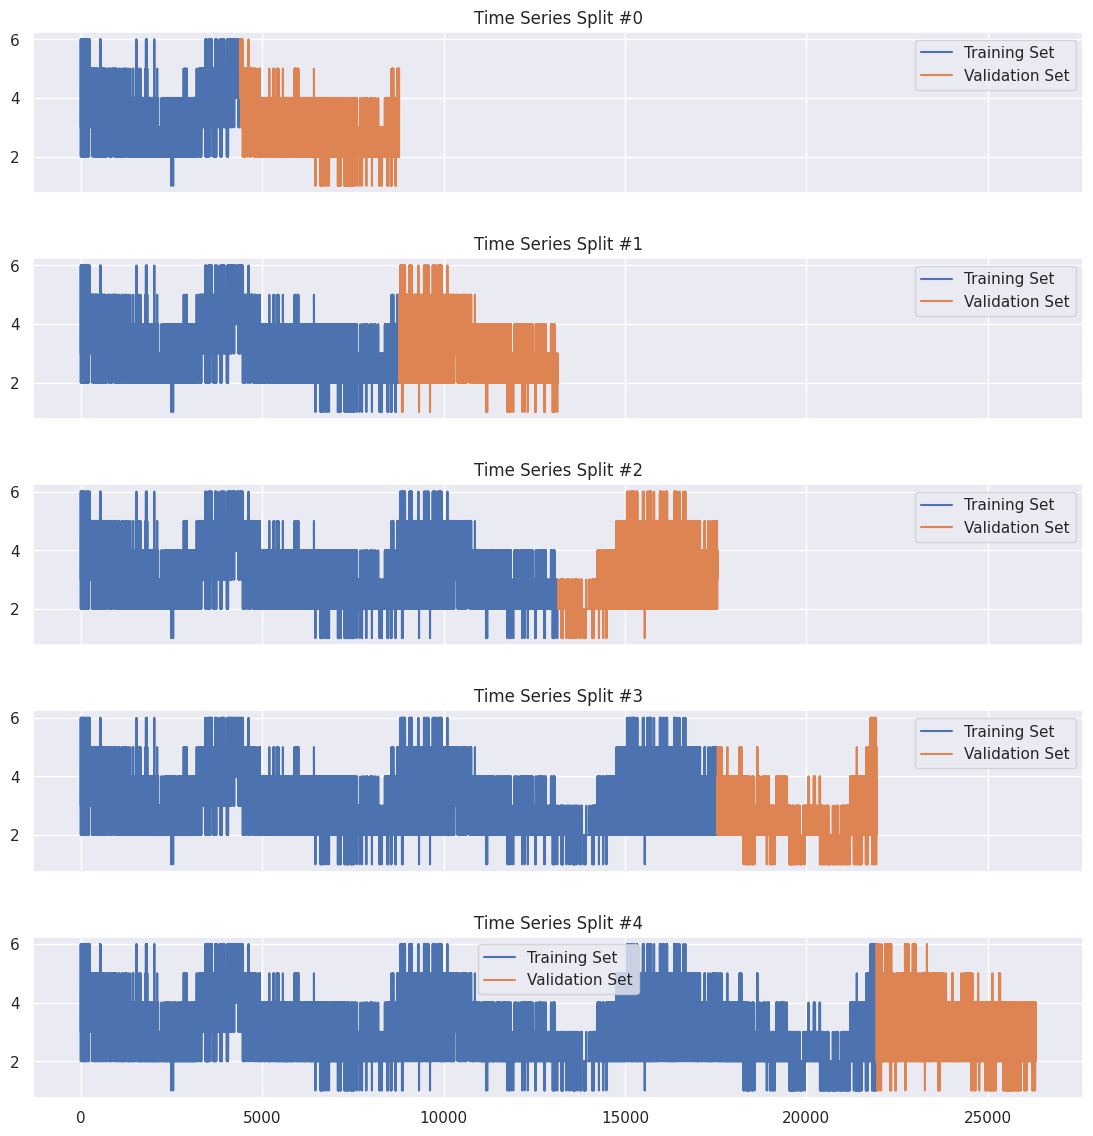

In [21]:
fig, axes = plt.subplots(tscv.n_splits, 1, figsize=(12, 12), sharex=True)
fig.tight_layout(pad=3.0)

for index, (train_fold, validation_fold) in enumerate(tscv.split(y_train)):
    sns.lineplot(data=y_train.iloc[train_fold], label='Training Set', ax=axes[index])
    sns.lineplot(data=y_train.iloc[validation_fold], label='Validation Set', ax=axes[index])
    axes[index].set_title(f'Time Series Split #{index}')
    axes[index].set(xlabel=None, ylabel=None)

    print(f"Fold {index+1}:")
    print("-- Training set class distribution: --")
    print(y_train.iloc[train_fold].value_counts().sort_index())
    print("-- Validation set class distribution: --")
    print(y_train.iloc[validation_fold].value_counts().sort_index())
    print("-" * 20)

plt.show()

## Custom SMOTE for Random Forest and XGBoost

In [22]:
class SmoteKNeighbors(SMOTE):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def _fit_resample(self, X, y):
        counts = np.bincount(y)
        minority_class = np.argmin(counts)
        n_samples_minority = counts[minority_class]

        if self.k_neighbors >= n_samples_minority:
            new_k_neighbors = max(1, n_samples_minority - 1)

            original_k_neighbors = self.k_neighbors
            self.k_neighbors = new_k_neighbors

            print(f"Warning: k_neighbors too high. Adjusting from {original_k_neighbors} to {self.k_neighbors} for this fold.")

            X_res, y_res = super()._fit_resample(X, y)

            self.k_neighbors = original_k_neighbors

            return X_res, y_res
        else:
            return super()._fit_resample(X, y)

## Random forest
Il modello Random Forest è un ensemble di alberi decisionali che migliora la stabilità e la capacità predittiva rispetto a un singolo albero. Ogni albero viene addestrato su un sottoinsieme casuale del dataset (bagging) e valuta solo una parte delle feature, rendendo l’insieme più robusto a overfitting e variazioni nei dati.

In questa configurazione iniziale, definiamo una pipeline che include anche una tecnica di **oversampling (SMOTE)** per bilanciare le classi nel dataset di addestramento.

La pipeline è così configurata:
- `max_samples=0.2`: ogni albero è addestrato su un campione casuale del 20% dei dati originali (con ripetizione);
- `max_features='sqrt'`: ogni nodo dell’albero valuta solo un sottoinsieme di feature pari alla radice quadrata del numero totale di feature disponibili;
- `n_estimators=200`: il modello è composto da 200 alberi decisionali;
- `max_depth=None`: gli alberi possono crescere fino a foglie pure, senza una profondità massima prefissata;
- `n_jobs=-1`: sfrutta tutti i core CPU disponibili per il training parallelo;
- `random_state=RANDOM_STATE`: Per la riproducibilità.
- `class_weight='balanced'`: attribuisce un peso inversamente proporzionale alla frequenza delle classi per gestire eventuali sbilanciamenti nel dataset.

In [23]:
y_train_rf = y_train - 1
y_test_rf = y_test - 1

model = ImbPipeline([
    ("preproc", preprocessor),
    ("sampler", SMOTE(random_state=RANDOM_STATE)),
    ("tree", RandomForestClassifier(max_samples=0.2, max_features="sqrt",
                                    n_estimators=200, max_depth=None,
                                    n_jobs=N_JOBS, random_state=RANDOM_STATE,
                                    class_weight='balanced'))
])

In [24]:
%time model.fit(X_train, y_train_rf)
print()

CPU times: user 20.2 s, sys: 146 ms, total: 20.3 s
Wall time: 5.87 s



Possiamo ricavare le 10 feature più importanti per la Random Forest, ovvero le variabili che sono state più utilizzate nella creazione degli alberi decisionali.

In [25]:
pd.Series(model.named_steps["tree"].feature_importances_, preprocessor.get_feature_names_out(X_train.columns)).sort_values(ascending=False).head(10)

numeric__pm_lag_1D    0.223789
numeric__pm_lag_2D    0.109891
numeric__pm_lag_3D    0.092542
numeric__pm_lag_1W    0.060801
numeric__pm_lag_1Y    0.044712
numeric__co_lag_1D    0.042311
numeric__pm_lag_2Y    0.035234
numeric__pm_lag_1M    0.032467
numeric__co_lag_2D    0.028231
numeric__co_lag_3D    0.024183
dtype: float64

### Hyperparameter Tuning per Random Forest

Eseguiamo una ricerca randomizzata (`RandomizedSearchCV`) per ottimizzare un insieme ampio di iperparametri fondamentali del modello Random Forest:

- `n_estimators`: numero di alberi nella foresta;
- `max_samples`: frazione massima di campioni usata per addestrare ogni singolo albero;
- `max_depth`: profondità massima degli alberi;
- `min_samples_leaf`: numero minimo di campioni richiesti per una foglia;
- `max_features`: numero massimo di feature da considerare per ogni split.

In questa fase di tuning, la pipeline include anche la tecnica di oversampling **SMOTE**, applicata correttamente all'interno di ogni fold di **Time Series Cross-Validation** per evitare il data leakage.

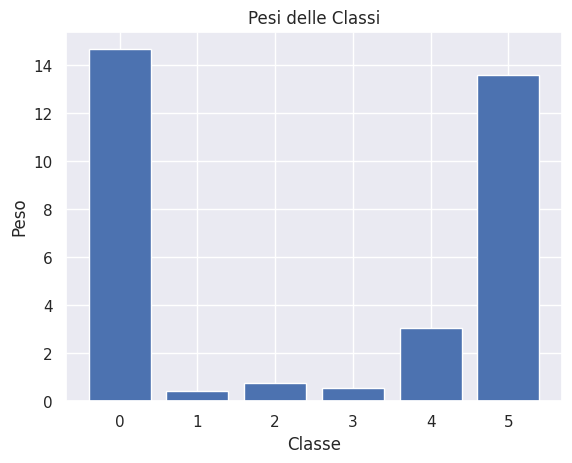

In [26]:
class_labels = np.unique(y_train_rf)
initial_weights = compute_class_weight(class_weight='balanced', classes=class_labels, y=y_train_rf)
initial_class_weight_dict = dict(zip(class_labels, initial_weights))
plt.bar(class_labels, initial_weights)
plt.title('Pesi delle Classi')
plt.xlabel('Classe')
plt.ylabel('Peso')
plt.show()

In [27]:
grid_rf = {
    'tree__n_estimators': [100, 150, 200],
    'tree__max_samples': [0.5, 0.7, 0.9],
    'tree__max_depth': [5, 10, 15],
    'tree__min_samples_split': [2, 5],
    'tree__min_samples_leaf': [2, 5],
    'tree__max_features': ['sqrt', 'log2']
}

model_ht_rf = ImbPipeline([
    ("preproc", preprocessor),
    ("sampler", SmoteKNeighbors(random_state=RANDOM_STATE)),
    ("tree", RandomForestClassifier(random_state=RANDOM_STATE, class_weight='balanced'))
])

gs_rf = RandomizedSearchCV(model_ht_rf, grid_rf, n_iter=49, cv=tscv, scoring='f1_weighted', n_jobs=N_JOBS, verbose=0, random_state=RANDOM_STATE)

**Scelta del numero di iterazioni per RandomizedSearchCV con questo grid**

Il grid ha:

- Configurazioni Totali:
$$
M = 216
$$

Supponiamo di voler avere una probabilità \( P = 0.90 \) di includere almeno una delle migliori \( k = 10 \) configurazioni tra queste 216.

Usiamo la formula:

$$
n = \frac{\ln(1 - P)}{\ln\left(1 - \frac{k}{M}\right)}
$$

Calcoliamo:

$$
n = \frac{\ln(1 - 0.90)}{\ln\left(1 - \frac{10}{216}\right)} = \frac{\ln(0.10)}{\ln\left(\frac{206}{216}\right)} = \frac{-2.3026}{\ln(206/216)} \approx \frac{2.3026}{0.0474} \approx 48.58
$$

Quindi, con **49 iterazioni** di Randomized Search, si ha circa il 90% di probabilità di testare almeno una delle 10 migliori configurazioni, risparmiando molto rispetto a un Grid Search completo con 216 combinazioni.

---

**Da dove viene la formula per stimare il numero di iterazioni nel Randomized Search?**

Per stimare quante iterazioni (`n`) sono necessarie per avere una certa probabilità \(P\) di includere almeno una configurazione tra le \(k\) migliori (su \(M\) totali), usiamo la seguente logica probabilistica:

1. Probabilità di *non* pescare una top-\(k\) in un singolo tentativo.
Se ci sono \(M\) configurazioni totali e \(k\) di esse sono “quasi ottimali”, la probabilità di *non* sceglierne una buona è:
$$
1 - \frac{k}{M}
$$

2. Probabilità di non pescarne *nessuna* in \(n\) tentativi indipendenti
$$
\left(1 - \frac{k}{M} \right)^n
$$

3. Probabilità di pescare **almeno una** delle top-\(k\)
$$
P(\text{≥1 top-}k) = 1 - \left(1 - \frac{k}{M} \right)^n
$$

4. Ricavare \(n\) dalla formula
$$
1 - \left(1 - \frac{k}{M} \right)^n = P
\quad \Longrightarrow \quad
n = \frac{\ln(1 - P)}{\ln\left(1 - \frac{k}{M} \right)}
$$

5. Approssimazione per $$ k \ll M $$
Poiché $$ \ln(1 - x) \approx -x $$ per \(x\) piccolo:
$$
n \approx - \frac{\ln(1 - P)}{k/M}
$$

In [28]:
%time gs_rf.fit(X_train, y_train_rf)
print()

CPU times: user 49.8 s, sys: 741 ms, total: 50.5 s
Wall time: 11min 51s



In [29]:
get_estimator_scores("random_forest", gs_rf.best_estimator_, X_test, y_test_rf, X_train, y_train_rf, all_scores)


--- Valutazione Prestazioni per random_forest ---
Model Parameters/Nodes: 826018



Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.77      0.74      0.76       321
           1       0.89      0.86      0.88      2727
           2       0.66      0.70      0.68      1364
           3       0.85      0.79      0.82      1831
           4       0.61      0.82      0.70       307
           5       0.38      0.43      0.41        30

    accuracy                           0.80      6580
   macro avg       0.69      0.73      0.71      6580
weighted avg       0.81      0.80      0.80      6580


Confusion Matrix (Test Set):
[[ 237   84    0    0    0    0]
 [  68 2357  284   18    0    0]
 [   1  199  960  202    2    0]
 [   0   14  216 1455  145    1]
 [   0    1    0   33  253   20]
 [   0    0    0    0   17   13]]


AUC-ROC (OVR, Weighted): 0.952
AUC-PR (OVR, Weighted): 0.858


## XGBoost

XGBoost è un'implementazione ottimizzata di algoritmi di gradient boosting. A differenza del Random Forest che costruisce alberi indipendenti e poi ne aggrega i risultati, XGBoost costruisce alberi in sequenza, con ogni nuovo albero che corregge gli errori degli alberi precedenti.

In questa configurazione iniziale, definiamo una pipeline che include anche una tecnica di **oversampling (SMOTE)** per bilanciare le classi nel dataset di addestramento.

La pipeline è così configurata:
- `sampler`: **SMOTE (Synthetic Minority Over-sampling Technique)**, che genera nuovi campioni sintetici per le classi minoritarie, rendendo il dataset più bilanciato per l'addestramento. `random_state` garantisce la riproducibilità.
- `xgb`: il classificatore XGBoost con i seguenti iperparametri iniziali:
    - `objective='multi:softprob'`: Specifica la funzione obiettivo di classificazione multi-classe, dove l'output è un array di probabilità per ogni classe. Questo è necessario per le metriche AUC.
    - `num_class`: numero totale di classi.
    - `n_estimators=200`: numero di alberi di boosting da costruire.
    - `learning_rate=0.1`: La dimensione del passo di ridimensionamento del contributo di ogni albero.
    - `use_label_encoder=False`: parametro deprecato e quindi va disabilitato per evitare warning.
    - `eval_metric='mlogloss'`: metrica di valutazione da usare durante l'addestramento.
    - `n_jobs=N_JOBS`: Sfrutta tutti i core CPU disponibili per il training parallelo.
    - `random_state=RANDOM_STATE`: Per la riproducibilità.

**Nota Importante:** Per XGBoost con multi-classe, le etichette della classe devono essere convertite in indici che partono da 0.

In [30]:
y_train_xgb = y_train - 1
y_test_xgb = y_test - 1
num_classes = len(np.unique(y_train_xgb))

model = ImbPipeline([
    ("preproc", preprocessor),
    ("sampler", SMOTE(random_state=RANDOM_STATE)),
    ("xgb", xgb.XGBClassifier(objective='multi:softprob',
                              num_class=num_classes,
                              n_estimators=200,
                              learning_rate=0.1,
                              use_label_encoder=False, # Deprecato, imposto a False
                              eval_metric='mlogloss',
                              n_jobs=N_JOBS,
                              verbosity=0,
                              random_state=RANDOM_STATE))
])

In [31]:
%time model.fit(X_train, y_train_xgb)
print()

CPU times: user 34.6 s, sys: 353 ms, total: 35 s
Wall time: 9.79 s



Possiamo ricavare le 10 feature più importanti per l'XGBoost Classifier, ovvero le variabili che sono state più utilizzate nella creazione degli alberi di boosting.

In [32]:
pd.Series(model.named_steps["xgb"].feature_importances_, preprocessor.get_feature_names_out(X_train.columns)).sort_values(ascending=False).head(10)

numeric__pm_lag_1D                  0.373324
categorical__state_Mizoram          0.032396
categorical__state_Jharkhand        0.032081
categorical__state_Delhi            0.031139
categorical__state_Gujarat          0.025636
categorical__state_Bihar            0.024329
categorical__state_Uttar Pradesh    0.023500
categorical__state_Telangana        0.021301
categorical__state_Karnataka        0.017804
categorical__state_Assam            0.017711
dtype: float32

### Hyperparameter Tuning per XGBoost
Eseguiamo una ricerca esaustiva (GridSearchCV) per ottimizzare iperparametri fondamentali del modello XGBoost, combinandoli con la tecnica di resampling SMOTE. Ottimizzeremo:
- `n_estimators`: Numero di alberi di boosting.
- `learning_rate`: La dimensione del passo che riduce il contributo di ogni nuovo albero.
- `max_depth`: La profondità massima di un albero.

In questa fase di tuning, la pipeline includerà anche la tecnica di oversampling SMOTE, che verrà applicata in modo appropriato a ogni fold di cross-validation per garantire che il modello sia addestrato su un dataset bilanciato senza data leakage.


---

**Scelta del numero di iterazioni per RandomizedSearchCV con questo grid**

Il grid ha:

- Configurazioni Totali:
$$
M = 432
$$

Supponiamo di voler avere una probabilità \( P = 0.90 \) di includere almeno una delle migliori \( k = 10 \) configurazioni tra queste 432.

Usiamo la formula:

$$
n = \frac{\ln(1 - P)}{\ln\left(1 - \frac{k}{M}\right)}
$$

Calcoliamo:

$$
n = \frac{\ln(1 - 0.90)}{\ln\left(1 - \frac{10}{432}\right)} = \frac{\ln(0.10)}{\ln\left(\frac{422}{432}\right)} = \frac{-2.3026}{\ln(\frac{422}{432})} \approx \frac{2.3026}{0.0234} \approx 98.40
$$

Quindi, con **98** di Randomized Search, si ha circa il 90% di probabilità di testare almeno una delle 10 migliori configurazioni, risparmiando molto rispetto a un Grid Search completo con 432 combinazioni.

---

In [33]:
grid_xgb = {
    "xgb__max_depth": [3, 5],
    "xgb__learning_rate": [0.01, 0.05, 0.1],
    "xgb__n_estimators": [100, 200, 300],
    "xgb__subsample": [0.7, 0.9],
    "xgb__colsample_bytree": [0.7, 0.9],
    "xgb__gamma": [0, 0.2, 0.4],
    "xgb__min_child_weight": [1, 5]
}

model_ht_xgb = ImbPipeline([
    ("preproc", preprocessor),
    ("sampler", SmoteKNeighbors(random_state=RANDOM_STATE)),
    ("xgb", xgb.XGBClassifier(objective='multi:softprob',
                              num_class=num_classes,
                              use_label_encoder=False,
                              eval_metric='mlogloss',
                              n_jobs=N_JOBS,
                              verbosity=0,
                              random_state=RANDOM_STATE))
])

gs_xgb = RandomizedSearchCV(model_ht_xgb, grid_xgb, n_iter=98, cv=tscv, scoring='f1_weighted', n_jobs=N_JOBS, verbose=0, random_state=RANDOM_STATE)

In [34]:
%time gs_xgb.fit(X_train, y_train_xgb)
print()

CPU times: user 51 s, sys: 1.8 s, total: 52.8 s
Wall time: 18min 41s



In [35]:
get_estimator_scores("xgboost", gs_xgb.best_estimator_, X_test, y_test_xgb, X_train, y_train_xgb, all_scores)


--- Valutazione Prestazioni per xgboost ---


Model Parameters/Nodes: 87674



Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.76      0.78      0.77       321
           1       0.89      0.87      0.88      2727
           2       0.67      0.68      0.68      1364
           3       0.83      0.83      0.83      1831
           4       0.66      0.75      0.70       307
           5       0.33      0.37      0.35        30

    accuracy                           0.81      6580
   macro avg       0.69      0.71      0.70      6580
weighted avg       0.81      0.81      0.81      6580


Confusion Matrix (Test Set):
[[ 251   70    0    0    0    0]
 [  77 2367  261   22    0    0]
 [   1  202  933  227    1    0]
 [   0    6  202 1522  100    1]
 [   0    1    0   56  229   21]
 [   0    0    0    0   19   11]]


AUC-ROC (OVR, Weighted): 0.957
AUC-PR (OVR, Weighted): 0.874


## MLP and KAN


In [36]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device utilizzato: {device}")

class MLP(nn.Module):
    def __init__(self, input_dim, hidden_sizes, dropout, num_classes):
        super().__init__()
        layers = []
        dim = input_dim
        for hs in hidden_sizes:
            layers.append(nn.Linear(dim, hs))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout))
            dim = hs
        layers.append(nn.Linear(dim, num_classes))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

def build_kan(input_dim, width, grid, k, num_classes, seed=0):
    model = KAN(
        width=[input_dim] + list(width) + [num_classes],
        grid=grid,
        k=k,
        seed=seed,
        device=device
    )
    model.speed()  # enable efficient mode: disable symbolic branch
    return model

Device utilizzato: cuda


### Implementazione dell’Early Stopping

La classe `EarlyStopper` implementa una logica di early stopping che interrompe anticipatamente l’addestramento se la performance sul validation set non migliora oltre una soglia (min_delta) per un numero consecutivo di epoche (patience).
Questo approccio aiuta a evitare l’overfitting e riduce i tempi di addestramento, salvando il modello con la miglior loss di validazione osservata.

In [37]:
class EarlyStopper:
    def __init__(self, patience=3, min_delta=0.0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = float('inf')

    def early_stop(self, val_loss):
        # Se la loss migliora (di almeno min_delta), resettiamo il counter
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            # Se la loss non migliora da 'patience' epoche, dobbiamo fermarci
            if self.counter >= self.patience:
                return True
        return False

### Funzioni per il training e la valutazione

- `train_epoch`: esegue una singola epoca di training. Calcola le previsioni, applica la loss function, esegue il backpropagation e aggiorna i pesi del modello. La loss viene aggregata e normalizzata sulla dimensione del dataset.

- `eval_loss`: calcola la loss media del modello sul validation set in modalità eval, disabilitando l’aggiornamento dei pesi. Questo è fondamentale per valutare le prestazioni in modo affidabile durante il training.

In [38]:
def train_epoch(model, loader, optimizer, criterion, l2_lambda=0.0):
    model.train()
    total_loss = 0.0
    for Xb, yb in loader:
        Xb, yb = Xb.to(device), yb.to(device)
        optimizer.zero_grad()
        loss = criterion(model(Xb), yb)

        if l2_lambda > 0:
            l2_reg = torch.tensor(0.).to(device)
            for param in model.parameters():
                l2_reg += torch.norm(param, 2)
            loss += l2_lambda * l2_reg

        loss.backward()
        optimizer.step()
        total_loss += loss.item() * Xb.size(0)
    return total_loss / len(loader.dataset)

def eval_loss(model, loader, criterion):
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for Xb, yb in loader:
            Xb, yb = Xb.to(device), yb.to(device)
            total_loss += criterion(model(Xb), yb.long()).item() * Xb.size(0)
    return total_loss / len(loader.dataset)

### Random Search con Cross-Validation temporale e Early Stopping

La funzione `random_search` implementa una strategia di ottimizzazione degli iperparametri che:

- Estrae in modo casuale combinazioni di iperparametri dallo spazio definito (param_dist);
- Valuta ogni configurazione tramite Cross Validation TimeSeriesSplit per rispettare l’ordine temporale dei dati;
- Addestra un modello MLP per ciascun fold monitorando la loss di validazione;
- Applica early stopping durante l’allenamento per evitare overfitting;
- Calcola la media delle validation loss su tutti i fold per ogni configurazione.

La combinazione con la miglior media viene salvata come modello ottimale, insieme agli iperparametri migliori.

In [39]:
def random_search(model_builder, param_dist, dataset,
                  n_iter=10, cv_folds=5,
                  early_patience=5,
                  early_min_delta=1e-4,
                  class_weights=None,
                  smote_k_neighbors=6):
    train_keys = ['lr', 'l2_lambda']
    best_val_loss = float('inf')
    best_model_params, best_train_params = None, None
    best_model = None

    tscv = TimeSeriesSplit(n_splits=cv_folds)

    print("Avvio Randomized Search")

    smote = SMOTE(
        k_neighbors=smote_k_neighbors,
        random_state=RANDOM_STATE
    )

    for param_id, params in enumerate(ParameterSampler(param_dist, n_iter=n_iter, random_state=RANDOM_STATE)):
        print(f"Testing parameter set {param_id+1}/{n_iter}")

        model_params = {k: v for k, v in params.items() if k not in train_keys}
        train_params = {k: v for k, v in params.items() if k in train_keys}
        val_losses = []

        for fold_idx, (train_idx, val_idx) in enumerate(tscv.split(range(len(dataset)))):
            print(f"  Fold {fold_idx+1}/{cv_folds}")

            # Estrai i dati del fold di training
            train_features = dataset.tensors[0][train_idx].cpu().numpy()
            train_labels = dataset.tensors[1][train_idx].cpu().numpy()

            # Estrai i dati di validazione
            val_features = dataset.tensors[0][val_idx]
            val_labels = dataset.tensors[1][val_idx]

            # Applica SMOTE al training set
            try:
                # Verifica che ci siano almeno 2 classi nel training set
                unique_classes = np.unique(train_labels)
                if len(unique_classes) < 2:
                    print(f"    Warning: Solo {len(unique_classes)} classe/i nel fold {fold_idx+1}. Skip SMOTE.")
                    train_features_resampled = train_features
                    train_labels_resampled = train_labels
                else:
                    # Verifica che ogni classe abbia almeno k_neighbors+1 campioni
                    min_samples = min([np.sum(train_labels == cls) for cls in unique_classes])
                    if min_samples <= smote_k_neighbors:
                        print(f"    Warning: Alcune classi hanno meno di {smote_k_neighbors+1} campioni. Riduco k_neighbors.")
                        smote_fold = SMOTE(
                            k_neighbors=min(min_samples-1, 1),
                            random_state=RANDOM_STATE
                        )
                    else:
                        smote_fold = smote

                    train_features_resampled, train_labels_resampled = smote_fold.fit_resample(
                        train_features, train_labels
                    )

                    print(f"    SMOTE applicato: {len(train_features)} -> {len(train_features_resampled)} campioni")

                    # Mostra la distribuzione delle classi dopo SMOTE
                    unique, counts = np.unique(train_labels_resampled, return_counts=True)
                    print(f"    Distribuzione post-SMOTE: {{{', '.join(f'{u}: {c}' for u, c in zip(unique, counts))}}}")

            except Exception as e:
                print(f"    Warning: SMOTE fallito ({str(e)}). Uso dataset originale.")
                train_features_resampled = train_features
                train_labels_resampled = train_labels

            # Converti back a tensori PyTorch
            train_features_tensor = torch.FloatTensor(train_features_resampled)
            train_labels_tensor = torch.LongTensor(train_labels_resampled)

            # Crea i dataset bilanciati
            balanced_train_dataset = TensorDataset(train_features_tensor, train_labels_tensor)
            val_dataset = TensorDataset(val_features, val_labels)

            # Crea i DataLoader
            train_loader = DataLoader(balanced_train_dataset, batch_size=32, shuffle=True)
            val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

            # Inizializza e addestra il modello
            model = model_builder(**model_params)
            if hasattr(model, 'speed'):
                model.speed()
            model.to(device)
            optimizer = optim.Adam(model.parameters(), lr=train_params['lr'])
            criterion = nn.CrossEntropyLoss()
            stopper = EarlyStopper(patience=early_patience, min_delta=early_min_delta)

            for epoch in range(1000):
                train_loss = train_epoch(model, train_loader, optimizer, criterion, l2_lambda=train_params.get('l2_lambda', 0.0))
                val_loss = eval_loss(model, val_loader, criterion)

                if epoch % 10 == 0:
                    print(f"    Epoch {epoch}: train_loss = {train_loss:.6f}, val_loss = {val_loss:.6f}")

                if stopper.early_stop(val_loss):
                    print(f"    Early stopping at epoch {epoch}, best_val_loss: {stopper.best_loss:.6f}")
                    break

            final_val_loss = eval_loss(model, val_loader, criterion)
            val_losses.append(final_val_loss)

        mean_val = np.mean(val_losses)
        print(f"  Mean validation loss: {mean_val:.6f}")

        if mean_val < best_val_loss:
            best_val_loss = mean_val
            best_model_params = model_params
            best_train_params = train_params
            best_model = model_builder(**best_model_params).to(device)
            best_model.load_state_dict(model.state_dict())
            print(f"  New best validation loss: {best_val_loss:.6f}")

    print(f"\nBest validation loss: {best_val_loss:.6f}")
    return best_model, best_model_params, best_train_params

### Preparazione dati e spazio di ricerca iperparametri

In questa sezione:

- Applichiamo la trasformazione dei dati tramite il preprocessor già definito in precedenza;

- Convertiamo le etichette y_train e y_test in formato 0-indexed, come richiesto dalla CrossEntropyLoss di PyTorch;

- Creiamo un dataset PyTorch (TensorDataset) con input e target;

- Definiamo lo spazio di ricerca per gli iperparametri, tra cui:

 Architettura della rete (hidden_sizes);

 Dropout;

 Tasso di apprendimento (lr);

 Numero di classi.

Calcoliamo infine i pesi delle classi per bilanciare la loss in presenza di squilibri nella distribuzione delle etichette.

In [40]:
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

y_train_0_indexed = y_train.values - 1
y_test_0_indexed = y_test.values - 1

X_tensor = torch.tensor(X_train_processed, dtype=torch.float32)
y_tensor = torch.tensor(y_train_0_indexed, dtype=torch.long)

full_dataset = TensorDataset(X_tensor, y_tensor)

input_dim = X_tensor.shape[1]
num_classes = len(np.unique(y_train_0_indexed))

mlp_param_dist = {
    'input_dim': [input_dim],
    'hidden_sizes': [(64,64), (128,), (128, 64), (256, 128), (512, 256)],
    'dropout': [0.0, 0.2, 0.5],
    'lr': [1e-3, 1e-4],
    'num_classes': [num_classes],
    'l2_lambda': [0.0, 1e-5, 1e-4, 1e-3]
}
kan_param_dist = {
    'input_dim': [input_dim],
    'width': [(8,4), (16, 8), (32, 16), (64, 32)],
    'grid': [5, 10, 20],
    'k': [2, 4],
    'seed': [0],
    'lr': [1e-3, 1e-4],
    'num_classes': [num_classes],
    'l2_lambda': [0.0, 1e-5, 1e-4, 1e-3]
}

class_labels_0_indexed = np.unique(y_train_0_indexed)
class_weights_balanced = compute_class_weight(class_weight='balanced', classes=class_labels_0_indexed, y=y_train_0_indexed)
class_weights_dict = dict(zip(class_labels_0_indexed, class_weights_balanced))

### Avvio della ricerca e valutazione

- Eseguiamo la funzione random_search, fornendo:

 Il costruttore della rete MLP;

 Lo spazio degli iperparametri;

 Il dataset PyTorch e i pesi delle classi calcolati in precedenza;

- Al termine, il modello con la miglior media di validation loss viene selezionato e restituito;

In [41]:
%%time
print("MLP Results:")
best_model_mlp, model_params_mlp, train_params_mlp = random_search(
    lambda **p: MLP(**p), mlp_param_dist, full_dataset,
    class_weights=class_weights_dict, n_iter=26
)

MLP Results:
Avvio Randomized Search
Testing parameter set 1/26
  Fold 1/5


    SMOTE applicato: 4389 -> 10440 campioni
    Distribuzione post-SMOTE: {0: 1740, 1: 1740, 2: 1740, 3: 1740, 4: 1740, 5: 1740}


    Epoch 0: train_loss = 0.914421, val_loss = 0.859074


    Epoch 10: train_loss = 0.410744, val_loss = 0.767987


    Early stopping at epoch 14, best_val_loss: 0.724690
  Fold 2/5


    SMOTE applicato: 8775 -> 17274 campioni
    Distribuzione post-SMOTE: {0: 2879, 1: 2879, 2: 2879, 3: 2879, 4: 2879, 5: 2879}


    Epoch 0: train_loss = 0.857333, val_loss = 0.987949


    Epoch 10: train_loss = 0.427770, val_loss = 0.775725
    Early stopping at epoch 10, best_val_loss: 0.705013
  Fold 3/5


    SMOTE applicato: 13161 -> 26964 campioni
    Distribuzione post-SMOTE: {0: 4494, 1: 4494, 2: 4494, 3: 4494, 4: 4494, 5: 4494}


    Epoch 0: train_loss = 0.804201, val_loss = 0.829626


    Epoch 10: train_loss = 0.421350, val_loss = 0.567519


    Early stopping at epoch 13, best_val_loss: 0.533357
  Fold 4/5


    SMOTE applicato: 17547 -> 37146 campioni
    Distribuzione post-SMOTE: {0: 6191, 1: 6191, 2: 6191, 3: 6191, 4: 6191, 5: 6191}


    Epoch 0: train_loss = 0.738037, val_loss = 0.776347


    Early stopping at epoch 8, best_val_loss: 0.536335
  Fold 5/5


    SMOTE applicato: 21933 -> 53052 campioni
    Distribuzione post-SMOTE: {0: 8842, 1: 8842, 2: 8842, 3: 8842, 4: 8842, 5: 8842}


    Epoch 0: train_loss = 0.680982, val_loss = 0.757656


    Early stopping at epoch 6, best_val_loss: 0.661837
  Mean validation loss: 0.686677
  New best validation loss: 0.686677
Testing parameter set 2/26
  Fold 1/5
    SMOTE applicato: 4389 -> 10440 campioni
    Distribuzione post-SMOTE: {0: 1740, 1: 1740, 2: 1740, 3: 1740, 4: 1740, 5: 1740}


    Epoch 0: train_loss = 1.580609, val_loss = 1.628071


    Epoch 10: train_loss = 0.669072, val_loss = 0.859833


    Epoch 20: train_loss = 0.579220, val_loss = 0.774275


    Epoch 30: train_loss = 0.539860, val_loss = 0.751085


    Early stopping at epoch 33, best_val_loss: 0.742079
  Fold 2/5
    SMOTE applicato: 8775 -> 17274 campioni
    Distribuzione post-SMOTE: {0: 2879, 1: 2879, 2: 2879, 3: 2879, 4: 2879, 5: 2879}


    Epoch 0: train_loss = 1.491652, val_loss = 1.571681


    Epoch 10: train_loss = 0.645553, val_loss = 0.917858


    Epoch 20: train_loss = 0.585545, val_loss = 0.831657


    Epoch 30: train_loss = 0.547338, val_loss = 0.804867


    Epoch 40: train_loss = 0.517698, val_loss = 0.787970
    Early stopping at epoch 40, best_val_loss: 0.785281
  Fold 3/5


    SMOTE applicato: 13161 -> 26964 campioni
    Distribuzione post-SMOTE: {0: 4494, 1: 4494, 2: 4494, 3: 4494, 4: 4494, 5: 4494}


    Epoch 0: train_loss = 1.330930, val_loss = 1.318430


    Epoch 10: train_loss = 0.618473, val_loss = 0.811122


    Epoch 20: train_loss = 0.553804, val_loss = 0.701996


    Epoch 30: train_loss = 0.511248, val_loss = 0.608022


    Epoch 40: train_loss = 0.482242, val_loss = 0.563662


    Epoch 50: train_loss = 0.463990, val_loss = 0.539562


    Early stopping at epoch 59, best_val_loss: 0.532736
  Fold 4/5


    SMOTE applicato: 17547 -> 37146 campioni
    Distribuzione post-SMOTE: {0: 6191, 1: 6191, 2: 6191, 3: 6191, 4: 6191, 5: 6191}


    Epoch 0: train_loss = 1.233891, val_loss = 1.247671


    Epoch 10: train_loss = 0.585225, val_loss = 0.736896


    Epoch 20: train_loss = 0.524133, val_loss = 0.553054


    Epoch 30: train_loss = 0.486917, val_loss = 0.537602


    Early stopping at epoch 32, best_val_loss: 0.532502
  Fold 5/5


    SMOTE applicato: 21933 -> 53052 campioni
    Distribuzione post-SMOTE: {0: 8842, 1: 8842, 2: 8842, 3: 8842, 4: 8842, 5: 8842}


    Epoch 0: train_loss = 1.129054, val_loss = 1.079198


    Epoch 10: train_loss = 0.546420, val_loss = 0.669757


    Epoch 20: train_loss = 0.494120, val_loss = 0.654015


    Early stopping at epoch 24, best_val_loss: 0.642403
  Mean validation loss: 0.650519
  New best validation loss: 0.650519
Testing parameter set 3/26
  Fold 1/5
    SMOTE applicato: 4389 -> 10440 campioni
    Distribuzione post-SMOTE: {0: 1740, 1: 1740, 2: 1740, 3: 1740, 4: 1740, 5: 1740}


    Epoch 0: train_loss = 0.846187, val_loss = 0.836237


    Early stopping at epoch 8, best_val_loss: 0.731739
  Fold 2/5


    SMOTE applicato: 8775 -> 17274 campioni
    Distribuzione post-SMOTE: {0: 2879, 1: 2879, 2: 2879, 3: 2879, 4: 2879, 5: 2879}


    Epoch 0: train_loss = 0.767384, val_loss = 0.921977


    Epoch 10: train_loss = 0.349717, val_loss = 0.776325
    Early stopping at epoch 10, best_val_loss: 0.730937
  Fold 3/5


    SMOTE applicato: 13161 -> 26964 campioni
    Distribuzione post-SMOTE: {0: 4494, 1: 4494, 2: 4494, 3: 4494, 4: 4494, 5: 4494}


    Epoch 0: train_loss = 0.705156, val_loss = 0.823704


    Epoch 10: train_loss = 0.343487, val_loss = 0.593317
    Early stopping at epoch 10, best_val_loss: 0.539938
  Fold 4/5


    SMOTE applicato: 17547 -> 37146 campioni
    Distribuzione post-SMOTE: {0: 6191, 1: 6191, 2: 6191, 3: 6191, 4: 6191, 5: 6191}


    Epoch 0: train_loss = 0.666520, val_loss = 0.787439


    Early stopping at epoch 7, best_val_loss: 0.544911
  Fold 5/5


    SMOTE applicato: 21933 -> 53052 campioni
    Distribuzione post-SMOTE: {0: 8842, 1: 8842, 2: 8842, 3: 8842, 4: 8842, 5: 8842}


    Epoch 0: train_loss = 0.606058, val_loss = 0.650498


    Early stopping at epoch 6, best_val_loss: 0.611265
  Mean validation loss: 0.708275
Testing parameter set 4/26
  Fold 1/5
    SMOTE applicato: 4389 -> 10440 campioni
    Distribuzione post-SMOTE: {0: 1740, 1: 1740, 2: 1740, 3: 1740, 4: 1740, 5: 1740}


    Epoch 0: train_loss = 1.444636, val_loss = 1.554005


    Epoch 10: train_loss = 0.635074, val_loss = 0.866046


    Epoch 20: train_loss = 0.543290, val_loss = 0.792615


    Epoch 30: train_loss = 0.498068, val_loss = 0.765674


    Epoch 40: train_loss = 0.465636, val_loss = 0.758057


    Epoch 50: train_loss = 0.444553, val_loss = 0.750552


    Epoch 60: train_loss = 0.425508, val_loss = 0.748693


    Early stopping at epoch 61, best_val_loss: 0.746337
  Fold 2/5
    SMOTE applicato: 8775 -> 17274 campioni
    Distribuzione post-SMOTE: {0: 2879, 1: 2879, 2: 2879, 3: 2879, 4: 2879, 5: 2879}


    Epoch 0: train_loss = 1.379517, val_loss = 1.538889


    Epoch 10: train_loss = 0.619368, val_loss = 0.936075


    Epoch 20: train_loss = 0.541985, val_loss = 0.827859


    Epoch 30: train_loss = 0.501009, val_loss = 0.773565


    Epoch 40: train_loss = 0.477240, val_loss = 0.742527


    Epoch 50: train_loss = 0.454380, val_loss = 0.721928


    Epoch 60: train_loss = 0.436231, val_loss = 0.713964


    Early stopping at epoch 62, best_val_loss: 0.711702
  Fold 3/5


    SMOTE applicato: 13161 -> 26964 campioni
    Distribuzione post-SMOTE: {0: 4494, 1: 4494, 2: 4494, 3: 4494, 4: 4494, 5: 4494}


    Epoch 0: train_loss = 1.301759, val_loss = 1.373254


    Epoch 10: train_loss = 0.591342, val_loss = 0.808495


    Epoch 20: train_loss = 0.519192, val_loss = 0.706554


    Epoch 30: train_loss = 0.479413, val_loss = 0.648670


    Epoch 40: train_loss = 0.456755, val_loss = 0.605258


    Epoch 50: train_loss = 0.439155, val_loss = 0.584734


    Epoch 60: train_loss = 0.427626, val_loss = 0.563193


    Epoch 70: train_loss = 0.416192, val_loss = 0.549093


    Epoch 80: train_loss = 0.406828, val_loss = 0.551786


    Early stopping at epoch 83, best_val_loss: 0.543090
  Fold 4/5


    SMOTE applicato: 17547 -> 37146 campioni
    Distribuzione post-SMOTE: {0: 6191, 1: 6191, 2: 6191, 3: 6191, 4: 6191, 5: 6191}


    Epoch 0: train_loss = 1.233698, val_loss = 1.268562


    Epoch 10: train_loss = 0.563609, val_loss = 0.790448


    Epoch 20: train_loss = 0.499233, val_loss = 0.684441


    Epoch 30: train_loss = 0.470310, val_loss = 0.608419


    Epoch 40: train_loss = 0.446639, val_loss = 0.571805


    Epoch 50: train_loss = 0.429482, val_loss = 0.560413


    Early stopping at epoch 58, best_val_loss: 0.560086
  Fold 5/5


    SMOTE applicato: 21933 -> 53052 campioni
    Distribuzione post-SMOTE: {0: 8842, 1: 8842, 2: 8842, 3: 8842, 4: 8842, 5: 8842}


    Epoch 0: train_loss = 1.128679, val_loss = 1.165154


    Epoch 10: train_loss = 0.522197, val_loss = 0.665101


    Epoch 20: train_loss = 0.468329, val_loss = 0.623408


    Early stopping at epoch 26, best_val_loss: 0.606689
  Mean validation loss: 0.635303
  New best validation loss: 0.635303
Testing parameter set 5/26
  Fold 1/5
    SMOTE applicato: 4389 -> 10440 campioni
    Distribuzione post-SMOTE: {0: 1740, 1: 1740, 2: 1740, 3: 1740, 4: 1740, 5: 1740}


    Epoch 0: train_loss = 0.682668, val_loss = 0.771320


    Early stopping at epoch 6, best_val_loss: 0.734873
  Fold 2/5


    SMOTE applicato: 8775 -> 17274 campioni
    Distribuzione post-SMOTE: {0: 2879, 1: 2879, 2: 2879, 3: 2879, 4: 2879, 5: 2879}


    Epoch 0: train_loss = 0.661996, val_loss = 0.829474


    Early stopping at epoch 9, best_val_loss: 0.724506
  Fold 3/5


    SMOTE applicato: 13161 -> 26964 campioni
    Distribuzione post-SMOTE: {0: 4494, 1: 4494, 2: 4494, 3: 4494, 4: 4494, 5: 4494}


    Epoch 0: train_loss = 0.615823, val_loss = 0.626268


    Early stopping at epoch 9, best_val_loss: 0.562660
  Fold 4/5


    SMOTE applicato: 17547 -> 37146 campioni
    Distribuzione post-SMOTE: {0: 6191, 1: 6191, 2: 6191, 3: 6191, 4: 6191, 5: 6191}


    Epoch 0: train_loss = 0.580270, val_loss = 0.648680


    Early stopping at epoch 6, best_val_loss: 0.614972
  Fold 5/5


    SMOTE applicato: 21933 -> 53052 campioni
    Distribuzione post-SMOTE: {0: 8842, 1: 8842, 2: 8842, 3: 8842, 4: 8842, 5: 8842}


    Epoch 0: train_loss = 0.537367, val_loss = 0.621595


    Early stopping at epoch 5, best_val_loss: 0.621595
  Mean validation loss: 0.829815
Testing parameter set 6/26
  Fold 1/5
    SMOTE applicato: 4389 -> 10440 campioni
    Distribuzione post-SMOTE: {0: 1740, 1: 1740, 2: 1740, 3: 1740, 4: 1740, 5: 1740}


    Epoch 0: train_loss = 0.725550, val_loss = 0.769820


    Early stopping at epoch 7, best_val_loss: 0.744705
  Fold 2/5


    SMOTE applicato: 8775 -> 17274 campioni
    Distribuzione post-SMOTE: {0: 2879, 1: 2879, 2: 2879, 3: 2879, 4: 2879, 5: 2879}


    Epoch 0: train_loss = 0.714288, val_loss = 0.860163


    Early stopping at epoch 7, best_val_loss: 0.696765
  Fold 3/5


    SMOTE applicato: 13161 -> 26964 campioni
    Distribuzione post-SMOTE: {0: 4494, 1: 4494, 2: 4494, 3: 4494, 4: 4494, 5: 4494}


    Epoch 0: train_loss = 0.662908, val_loss = 0.634407


    Early stopping at epoch 8, best_val_loss: 0.526884
  Fold 4/5


    SMOTE applicato: 17547 -> 37146 campioni
    Distribuzione post-SMOTE: {0: 6191, 1: 6191, 2: 6191, 3: 6191, 4: 6191, 5: 6191}


    Epoch 0: train_loss = 0.633395, val_loss = 0.586681


    Early stopping at epoch 6, best_val_loss: 0.551682
  Fold 5/5


    SMOTE applicato: 21933 -> 53052 campioni
    Distribuzione post-SMOTE: {0: 8842, 1: 8842, 2: 8842, 3: 8842, 4: 8842, 5: 8842}


    Epoch 0: train_loss = 0.586008, val_loss = 0.622088


    Early stopping at epoch 5, best_val_loss: 0.622088
  Mean validation loss: 0.733198
Testing parameter set 7/26
  Fold 1/5
    SMOTE applicato: 4389 -> 10440 campioni
    Distribuzione post-SMOTE: {0: 1740, 1: 1740, 2: 1740, 3: 1740, 4: 1740, 5: 1740}


    Epoch 0: train_loss = 1.051122, val_loss = 0.993827


    Epoch 10: train_loss = 0.424381, val_loss = 0.758055


    Early stopping at epoch 16, best_val_loss: 0.741547
  Fold 2/5


    SMOTE applicato: 8775 -> 17274 campioni
    Distribuzione post-SMOTE: {0: 2879, 1: 2879, 2: 2879, 3: 2879, 4: 2879, 5: 2879}


    Epoch 0: train_loss = 0.965095, val_loss = 1.037449


    Epoch 10: train_loss = 0.435525, val_loss = 0.700748


    Epoch 20: train_loss = 0.368972, val_loss = 0.725941


    Early stopping at epoch 22, best_val_loss: 0.691531
  Fold 3/5


    SMOTE applicato: 13161 -> 26964 campioni
    Distribuzione post-SMOTE: {0: 4494, 1: 4494, 2: 4494, 3: 4494, 4: 4494, 5: 4494}


    Epoch 0: train_loss = 0.889608, val_loss = 0.933618


    Epoch 10: train_loss = 0.418996, val_loss = 0.540314


    Epoch 20: train_loss = 0.354720, val_loss = 0.546174


    Early stopping at epoch 24, best_val_loss: 0.525290
  Fold 4/5


    SMOTE applicato: 17547 -> 37146 campioni
    Distribuzione post-SMOTE: {0: 6191, 1: 6191, 2: 6191, 3: 6191, 4: 6191, 5: 6191}


    Epoch 0: train_loss = 0.828478, val_loss = 0.877961


    Epoch 10: train_loss = 0.399953, val_loss = 0.587470


    Early stopping at epoch 11, best_val_loss: 0.573347
  Fold 5/5


    SMOTE applicato: 21933 -> 53052 campioni
    Distribuzione post-SMOTE: {0: 8842, 1: 8842, 2: 8842, 3: 8842, 4: 8842, 5: 8842}


    Epoch 0: train_loss = 0.756988, val_loss = 0.755621


    Epoch 10: train_loss = 0.375785, val_loss = 0.648835
    Early stopping at epoch 10, best_val_loss: 0.613339
  Mean validation loss: 0.654255
Testing parameter set 8/26
  Fold 1/5
    SMOTE applicato: 4389 -> 10440 campioni
    Distribuzione post-SMOTE: {0: 1740, 1: 1740, 2: 1740, 3: 1740, 4: 1740, 5: 1740}


    Epoch 0: train_loss = 0.857420, val_loss = 0.890663


    Early stopping at epoch 9, best_val_loss: 0.783476
  Fold 2/5
    SMOTE applicato: 8775 -> 17274 campioni
    Distribuzione post-SMOTE: {0: 2879, 1: 2879, 2: 2879, 3: 2879, 4: 2879, 5: 2879}


    Epoch 0: train_loss = 0.803213, val_loss = 1.008182


    Epoch 10: train_loss = 0.352725, val_loss = 0.717956


    Early stopping at epoch 13, best_val_loss: 0.710593
  Fold 3/5


    SMOTE applicato: 13161 -> 26964 campioni
    Distribuzione post-SMOTE: {0: 4494, 1: 4494, 2: 4494, 3: 4494, 4: 4494, 5: 4494}


    Epoch 0: train_loss = 0.739442, val_loss = 0.821279


    Epoch 10: train_loss = 0.349657, val_loss = 0.563425


    Early stopping at epoch 14, best_val_loss: 0.538942
  Fold 4/5


    SMOTE applicato: 17547 -> 37146 campioni
    Distribuzione post-SMOTE: {0: 6191, 1: 6191, 2: 6191, 3: 6191, 4: 6191, 5: 6191}


    Epoch 0: train_loss = 0.696318, val_loss = 0.728825


    Epoch 10: train_loss = 0.335043, val_loss = 0.619486
    Early stopping at epoch 10, best_val_loss: 0.552865
  Fold 5/5


    SMOTE applicato: 21933 -> 53052 campioni
    Distribuzione post-SMOTE: {0: 8842, 1: 8842, 2: 8842, 3: 8842, 4: 8842, 5: 8842}


    Epoch 0: train_loss = 0.636922, val_loss = 0.712688


    Early stopping at epoch 7, best_val_loss: 0.646472
  Mean validation loss: 0.710968
Testing parameter set 9/26
  Fold 1/5
    SMOTE applicato: 4389 -> 10440 campioni
    Distribuzione post-SMOTE: {0: 1740, 1: 1740, 2: 1740, 3: 1740, 4: 1740, 5: 1740}


    Epoch 0: train_loss = 0.941078, val_loss = 0.954894


    Epoch 10: train_loss = 0.402224, val_loss = 0.806893
    Early stopping at epoch 10, best_val_loss: 0.766735
  Fold 2/5
    SMOTE applicato: 8775 -> 17274 campioni
    Distribuzione post-SMOTE: {0: 2879, 1: 2879, 2: 2879, 3: 2879, 4: 2879, 5: 2879}


    Epoch 0: train_loss = 0.853028, val_loss = 0.972524


    Epoch 10: train_loss = 0.427369, val_loss = 0.726018


    Early stopping at epoch 16, best_val_loss: 0.725123
  Fold 3/5


    SMOTE applicato: 13161 -> 26964 campioni
    Distribuzione post-SMOTE: {0: 4494, 1: 4494, 2: 4494, 3: 4494, 4: 4494, 5: 4494}


    Epoch 0: train_loss = 0.792832, val_loss = 0.812137


    Early stopping at epoch 9, best_val_loss: 0.565170
  Fold 4/5


    SMOTE applicato: 17547 -> 37146 campioni
    Distribuzione post-SMOTE: {0: 6191, 1: 6191, 2: 6191, 3: 6191, 4: 6191, 5: 6191}


    Epoch 0: train_loss = 0.740817, val_loss = 0.750020


    Early stopping at epoch 7, best_val_loss: 0.552908
  Fold 5/5


    SMOTE applicato: 21933 -> 53052 campioni
    Distribuzione post-SMOTE: {0: 8842, 1: 8842, 2: 8842, 3: 8842, 4: 8842, 5: 8842}


    Epoch 0: train_loss = 0.682216, val_loss = 0.718179


    Early stopping at epoch 8, best_val_loss: 0.647995
  Mean validation loss: 0.719255
Testing parameter set 10/26
  Fold 1/5
    SMOTE applicato: 4389 -> 10440 campioni
    Distribuzione post-SMOTE: {0: 1740, 1: 1740, 2: 1740, 3: 1740, 4: 1740, 5: 1740}


    Epoch 0: train_loss = 1.416033, val_loss = 1.458852


    Epoch 10: train_loss = 0.600372, val_loss = 0.772630


    Epoch 20: train_loss = 0.521907, val_loss = 0.735984


    Early stopping at epoch 22, best_val_loss: 0.733796
  Fold 2/5


    SMOTE applicato: 8775 -> 17274 campioni
    Distribuzione post-SMOTE: {0: 2879, 1: 2879, 2: 2879, 3: 2879, 4: 2879, 5: 2879}


    Epoch 0: train_loss = 1.312997, val_loss = 1.347375


    Epoch 10: train_loss = 0.608493, val_loss = 0.833133


    Epoch 20: train_loss = 0.534136, val_loss = 0.777350


    Epoch 30: train_loss = 0.491158, val_loss = 0.745512


    Epoch 40: train_loss = 0.454411, val_loss = 0.731657
    Early stopping at epoch 40, best_val_loss: 0.725286
  Fold 3/5


    SMOTE applicato: 13161 -> 26964 campioni
    Distribuzione post-SMOTE: {0: 4494, 1: 4494, 2: 4494, 3: 4494, 4: 4494, 5: 4494}


    Epoch 0: train_loss = 1.204399, val_loss = 1.249399


    Epoch 10: train_loss = 0.576160, val_loss = 0.710516


    Epoch 20: train_loss = 0.507520, val_loss = 0.579383


    Epoch 30: train_loss = 0.460838, val_loss = 0.547806


    Epoch 40: train_loss = 0.429989, val_loss = 0.530685


    Early stopping at epoch 44, best_val_loss: 0.526036
  Fold 4/5


    SMOTE applicato: 17547 -> 37146 campioni
    Distribuzione post-SMOTE: {0: 6191, 1: 6191, 2: 6191, 3: 6191, 4: 6191, 5: 6191}


    Epoch 0: train_loss = 1.114816, val_loss = 1.125828


    Epoch 10: train_loss = 0.547290, val_loss = 0.646963


    Epoch 20: train_loss = 0.475945, val_loss = 0.552285


    Early stopping at epoch 26, best_val_loss: 0.550675
  Fold 5/5


    SMOTE applicato: 21933 -> 53052 campioni
    Distribuzione post-SMOTE: {0: 8842, 1: 8842, 2: 8842, 3: 8842, 4: 8842, 5: 8842}


    Epoch 0: train_loss = 1.025387, val_loss = 0.942882


    Epoch 10: train_loss = 0.515641, val_loss = 0.673504


    Early stopping at epoch 16, best_val_loss: 0.644203
  Mean validation loss: 0.647738
Testing parameter set 11/26
  Fold 1/5
    SMOTE applicato: 4389 -> 10440 campioni
    Distribuzione post-SMOTE: {0: 1740, 1: 1740, 2: 1740, 3: 1740, 4: 1740, 5: 1740}


    Epoch 0: train_loss = 0.773761, val_loss = 0.866774


    Early stopping at epoch 9, best_val_loss: 0.765880
  Fold 2/5
    SMOTE applicato: 8775 -> 17274 campioni
    Distribuzione post-SMOTE: {0: 2879, 1: 2879, 2: 2879, 3: 2879, 4: 2879, 5: 2879}


    Epoch 0: train_loss = 0.727851, val_loss = 0.864572


    Early stopping at epoch 9, best_val_loss: 0.713023
  Fold 3/5


    SMOTE applicato: 13161 -> 26964 campioni
    Distribuzione post-SMOTE: {0: 4494, 1: 4494, 2: 4494, 3: 4494, 4: 4494, 5: 4494}


    Epoch 0: train_loss = 0.670469, val_loss = 0.667632


    Early stopping at epoch 9, best_val_loss: 0.522804
  Fold 4/5


    SMOTE applicato: 17547 -> 37146 campioni
    Distribuzione post-SMOTE: {0: 6191, 1: 6191, 2: 6191, 3: 6191, 4: 6191, 5: 6191}


    Epoch 0: train_loss = 0.625432, val_loss = 0.638356


    Early stopping at epoch 7, best_val_loss: 0.558460
  Fold 5/5


    SMOTE applicato: 21933 -> 53052 campioni
    Distribuzione post-SMOTE: {0: 8842, 1: 8842, 2: 8842, 3: 8842, 4: 8842, 5: 8842}


    Epoch 0: train_loss = 0.578886, val_loss = 0.620393


    Early stopping at epoch 5, best_val_loss: 0.620393
  Mean validation loss: 0.756487
Testing parameter set 12/26
  Fold 1/5
    SMOTE applicato: 4389 -> 10440 campioni
    Distribuzione post-SMOTE: {0: 1740, 1: 1740, 2: 1740, 3: 1740, 4: 1740, 5: 1740}


    Epoch 0: train_loss = 0.864532, val_loss = 0.798197


    Early stopping at epoch 9, best_val_loss: 0.731322
  Fold 2/5
    SMOTE applicato: 8775 -> 17274 campioni
    Distribuzione post-SMOTE: {0: 2879, 1: 2879, 2: 2879, 3: 2879, 4: 2879, 5: 2879}


    Epoch 0: train_loss = 0.818183, val_loss = 0.912177


    Epoch 10: train_loss = 0.419882, val_loss = 0.732409


    Early stopping at epoch 12, best_val_loss: 0.717435
  Fold 3/5


    SMOTE applicato: 13161 -> 26964 campioni
    Distribuzione post-SMOTE: {0: 4494, 1: 4494, 2: 4494, 3: 4494, 4: 4494, 5: 4494}


    Epoch 0: train_loss = 0.749124, val_loss = 0.848436


    Epoch 10: train_loss = 0.414890, val_loss = 0.586574


    Early stopping at epoch 12, best_val_loss: 0.543751
  Fold 4/5


    SMOTE applicato: 17547 -> 37146 campioni
    Distribuzione post-SMOTE: {0: 6191, 1: 6191, 2: 6191, 3: 6191, 4: 6191, 5: 6191}


    Epoch 0: train_loss = 0.711308, val_loss = 0.699484


    Early stopping at epoch 7, best_val_loss: 0.559855
  Fold 5/5


    SMOTE applicato: 21933 -> 53052 campioni
    Distribuzione post-SMOTE: {0: 8842, 1: 8842, 2: 8842, 3: 8842, 4: 8842, 5: 8842}


    Epoch 0: train_loss = 0.655505, val_loss = 0.709289


    Early stopping at epoch 6, best_val_loss: 0.659289
  Mean validation loss: 0.713105
Testing parameter set 13/26
  Fold 1/5
    SMOTE applicato: 4389 -> 10440 campioni
    Distribuzione post-SMOTE: {0: 1740, 1: 1740, 2: 1740, 3: 1740, 4: 1740, 5: 1740}


    Epoch 0: train_loss = 1.462857, val_loss = 1.536068


    Epoch 10: train_loss = 0.591130, val_loss = 0.854400


    Epoch 20: train_loss = 0.493947, val_loss = 0.782545


    Epoch 30: train_loss = 0.442054, val_loss = 0.769725


    Early stopping at epoch 37, best_val_loss: 0.761352
  Fold 2/5
    SMOTE applicato: 8775 -> 17274 campioni
    Distribuzione post-SMOTE: {0: 2879, 1: 2879, 2: 2879, 3: 2879, 4: 2879, 5: 2879}


    Epoch 0: train_loss = 1.333944, val_loss = 1.527950


    Epoch 10: train_loss = 0.577485, val_loss = 0.936339


    Epoch 20: train_loss = 0.501211, val_loss = 0.841328


    Epoch 30: train_loss = 0.456374, val_loss = 0.788681


    Epoch 40: train_loss = 0.424728, val_loss = 0.746387


    Epoch 50: train_loss = 0.400716, val_loss = 0.737030


    Early stopping at epoch 59, best_val_loss: 0.714822
  Fold 3/5


    SMOTE applicato: 13161 -> 26964 campioni
    Distribuzione post-SMOTE: {0: 4494, 1: 4494, 2: 4494, 3: 4494, 4: 4494, 5: 4494}


    Epoch 0: train_loss = 1.245028, val_loss = 1.368192


    Epoch 10: train_loss = 0.540824, val_loss = 0.809399


    Epoch 20: train_loss = 0.465881, val_loss = 0.703374


    Epoch 30: train_loss = 0.424669, val_loss = 0.628226


    Epoch 40: train_loss = 0.397860, val_loss = 0.596024


    Epoch 50: train_loss = 0.378044, val_loss = 0.581587


    Epoch 60: train_loss = 0.362359, val_loss = 0.564483


    Epoch 70: train_loss = 0.349460, val_loss = 0.556750


    Early stopping at epoch 79, best_val_loss: 0.550468
  Fold 4/5


    SMOTE applicato: 17547 -> 37146 campioni
    Distribuzione post-SMOTE: {0: 6191, 1: 6191, 2: 6191, 3: 6191, 4: 6191, 5: 6191}


    Epoch 0: train_loss = 1.185868, val_loss = 1.245571


    Epoch 10: train_loss = 0.519444, val_loss = 0.768867


    Epoch 20: train_loss = 0.450391, val_loss = 0.645865


    Epoch 30: train_loss = 0.414190, val_loss = 0.603270


    Epoch 40: train_loss = 0.390365, val_loss = 0.578011


    Early stopping at epoch 44, best_val_loss: 0.570646
  Fold 5/5


    SMOTE applicato: 21933 -> 53052 campioni
    Distribuzione post-SMOTE: {0: 8842, 1: 8842, 2: 8842, 3: 8842, 4: 8842, 5: 8842}


    Epoch 0: train_loss = 1.069378, val_loss = 1.146192


    Epoch 10: train_loss = 0.475338, val_loss = 0.675202


    Epoch 20: train_loss = 0.417953, val_loss = 0.625443


    Epoch 30: train_loss = 0.386418, val_loss = 0.623217
    Early stopping at epoch 30, best_val_loss: 0.614712
  Mean validation loss: 0.645721
Testing parameter set 14/26
  Fold 1/5
    SMOTE applicato: 4389 -> 10440 campioni
    Distribuzione post-SMOTE: {0: 1740, 1: 1740, 2: 1740, 3: 1740, 4: 1740, 5: 1740}


    Epoch 0: train_loss = 0.626851, val_loss = 0.785830


    Early stopping at epoch 5, best_val_loss: 0.785830
  Fold 2/5


    SMOTE applicato: 8775 -> 17274 campioni
    Distribuzione post-SMOTE: {0: 2879, 1: 2879, 2: 2879, 3: 2879, 4: 2879, 5: 2879}


    Epoch 0: train_loss = 0.614927, val_loss = 0.946266


    Early stopping at epoch 7, best_val_loss: 0.737335
  Fold 3/5


    SMOTE applicato: 13161 -> 26964 campioni
    Distribuzione post-SMOTE: {0: 4494, 1: 4494, 2: 4494, 3: 4494, 4: 4494, 5: 4494}


    Epoch 0: train_loss = 0.581671, val_loss = 0.614213


    Early stopping at epoch 7, best_val_loss: 0.540454
  Fold 4/5


    SMOTE applicato: 17547 -> 37146 campioni
    Distribuzione post-SMOTE: {0: 6191, 1: 6191, 2: 6191, 3: 6191, 4: 6191, 5: 6191}


    Epoch 0: train_loss = 0.554916, val_loss = 0.688718


    Early stopping at epoch 6, best_val_loss: 0.668096
  Fold 5/5


    SMOTE applicato: 21933 -> 53052 campioni
    Distribuzione post-SMOTE: {0: 8842, 1: 8842, 2: 8842, 3: 8842, 4: 8842, 5: 8842}


    Epoch 0: train_loss = 0.520224, val_loss = 0.708965


    Early stopping at epoch 7, best_val_loss: 0.686867
  Mean validation loss: 0.867241
Testing parameter set 15/26
  Fold 1/5
    SMOTE applicato: 4389 -> 10440 campioni
    Distribuzione post-SMOTE: {0: 1740, 1: 1740, 2: 1740, 3: 1740, 4: 1740, 5: 1740}


    Epoch 0: train_loss = 1.428702, val_loss = 1.516687


    Epoch 10: train_loss = 0.695253, val_loss = 0.906922


    Epoch 20: train_loss = 0.591291, val_loss = 0.809649


    Epoch 30: train_loss = 0.544511, val_loss = 0.772135


    Epoch 40: train_loss = 0.508256, val_loss = 0.750785


    Epoch 50: train_loss = 0.484605, val_loss = 0.741538


    Epoch 60: train_loss = 0.460059, val_loss = 0.737861


    Early stopping at epoch 69, best_val_loss: 0.732856
  Fold 2/5
    SMOTE applicato: 8775 -> 17274 campioni
    Distribuzione post-SMOTE: {0: 2879, 1: 2879, 2: 2879, 3: 2879, 4: 2879, 5: 2879}


    Epoch 0: train_loss = 1.403162, val_loss = 1.564998


    Epoch 10: train_loss = 0.664890, val_loss = 0.952925


    Epoch 20: train_loss = 0.582675, val_loss = 0.836879


    Epoch 30: train_loss = 0.542816, val_loss = 0.788028


    Epoch 40: train_loss = 0.510805, val_loss = 0.759231


    Epoch 50: train_loss = 0.487992, val_loss = 0.741252


    Early stopping at epoch 53, best_val_loss: 0.736088
  Fold 3/5


    SMOTE applicato: 13161 -> 26964 campioni
    Distribuzione post-SMOTE: {0: 4494, 1: 4494, 2: 4494, 3: 4494, 4: 4494, 5: 4494}


    Epoch 0: train_loss = 1.342442, val_loss = 1.426635


    Epoch 10: train_loss = 0.638343, val_loss = 0.867184


    Epoch 20: train_loss = 0.558658, val_loss = 0.744748


    Epoch 30: train_loss = 0.514326, val_loss = 0.665627


    Epoch 40: train_loss = 0.485408, val_loss = 0.635770


    Epoch 50: train_loss = 0.461509, val_loss = 0.590556


    Epoch 60: train_loss = 0.445952, val_loss = 0.565742


    Epoch 70: train_loss = 0.434537, val_loss = 0.551751


    Epoch 80: train_loss = 0.425661, val_loss = 0.538151


    Epoch 90: train_loss = 0.412649, val_loss = 0.530446


    Early stopping at epoch 95, best_val_loss: 0.530446
  Fold 4/5


    SMOTE applicato: 17547 -> 37146 campioni
    Distribuzione post-SMOTE: {0: 6191, 1: 6191, 2: 6191, 3: 6191, 4: 6191, 5: 6191}


    Epoch 0: train_loss = 1.240044, val_loss = 1.300025


    Epoch 10: train_loss = 0.602756, val_loss = 0.830066


    Epoch 20: train_loss = 0.531585, val_loss = 0.711941


    Epoch 30: train_loss = 0.493912, val_loss = 0.635687


    Epoch 40: train_loss = 0.469160, val_loss = 0.593494


    Epoch 50: train_loss = 0.452637, val_loss = 0.569996


    Epoch 60: train_loss = 0.435340, val_loss = 0.569059
    Early stopping at epoch 60, best_val_loss: 0.565500
  Fold 5/5


    SMOTE applicato: 21933 -> 53052 campioni
    Distribuzione post-SMOTE: {0: 8842, 1: 8842, 2: 8842, 3: 8842, 4: 8842, 5: 8842}


    Epoch 0: train_loss = 1.154108, val_loss = 1.212411


    Epoch 10: train_loss = 0.558344, val_loss = 0.689223


    Epoch 20: train_loss = 0.497404, val_loss = 0.636360


    Epoch 30: train_loss = 0.462138, val_loss = 0.628466


    Early stopping at epoch 33, best_val_loss: 0.627772
  Mean validation loss: 0.641533
Testing parameter set 16/26
  Fold 1/5
    SMOTE applicato: 4389 -> 10440 campioni
    Distribuzione post-SMOTE: {0: 1740, 1: 1740, 2: 1740, 3: 1740, 4: 1740, 5: 1740}


    Epoch 0: train_loss = 1.494866, val_loss = 1.610871


    Epoch 10: train_loss = 0.696881, val_loss = 0.915083


    Epoch 20: train_loss = 0.591145, val_loss = 0.811125


    Epoch 30: train_loss = 0.542159, val_loss = 0.770338


    Epoch 40: train_loss = 0.502788, val_loss = 0.748824


    Epoch 50: train_loss = 0.477939, val_loss = 0.739901


    Epoch 60: train_loss = 0.462353, val_loss = 0.728880


    Epoch 70: train_loss = 0.442493, val_loss = 0.725805


    Early stopping at epoch 74, best_val_loss: 0.724474
  Fold 2/5
    SMOTE applicato: 8775 -> 17274 campioni
    Distribuzione post-SMOTE: {0: 2879, 1: 2879, 2: 2879, 3: 2879, 4: 2879, 5: 2879}


    Epoch 0: train_loss = 1.427936, val_loss = 1.557356


    Epoch 10: train_loss = 0.665821, val_loss = 0.962606


    Epoch 20: train_loss = 0.581808, val_loss = 0.865331


    Epoch 30: train_loss = 0.540304, val_loss = 0.805579


    Epoch 40: train_loss = 0.506987, val_loss = 0.776515


    Epoch 50: train_loss = 0.484363, val_loss = 0.756459


    Epoch 60: train_loss = 0.470371, val_loss = 0.743235


    Early stopping at epoch 67, best_val_loss: 0.733304
  Fold 3/5


    SMOTE applicato: 13161 -> 26964 campioni
    Distribuzione post-SMOTE: {0: 4494, 1: 4494, 2: 4494, 3: 4494, 4: 4494, 5: 4494}


    Epoch 0: train_loss = 1.312933, val_loss = 1.443905


    Epoch 10: train_loss = 0.635027, val_loss = 0.894608


    Epoch 20: train_loss = 0.556071, val_loss = 0.765531


    Epoch 30: train_loss = 0.521000, val_loss = 0.686447


    Epoch 40: train_loss = 0.489073, val_loss = 0.645680


    Epoch 50: train_loss = 0.468464, val_loss = 0.611691


    Epoch 60: train_loss = 0.451499, val_loss = 0.583791


    Epoch 70: train_loss = 0.441176, val_loss = 0.561922


    Epoch 80: train_loss = 0.430491, val_loss = 0.554428


    Epoch 90: train_loss = 0.419273, val_loss = 0.544327


    Early stopping at epoch 92, best_val_loss: 0.540246
  Fold 4/5


    SMOTE applicato: 17547 -> 37146 campioni
    Distribuzione post-SMOTE: {0: 6191, 1: 6191, 2: 6191, 3: 6191, 4: 6191, 5: 6191}


    Epoch 0: train_loss = 1.261557, val_loss = 1.308583


    Epoch 10: train_loss = 0.606679, val_loss = 0.803589


    Epoch 20: train_loss = 0.530862, val_loss = 0.666924


    Epoch 30: train_loss = 0.494609, val_loss = 0.599182


    Epoch 40: train_loss = 0.466861, val_loss = 0.556861


    Epoch 50: train_loss = 0.449157, val_loss = 0.543064


    Epoch 60: train_loss = 0.434408, val_loss = 0.545306
    Early stopping at epoch 60, best_val_loss: 0.540050
  Fold 5/5


    SMOTE applicato: 21933 -> 53052 campioni
    Distribuzione post-SMOTE: {0: 8842, 1: 8842, 2: 8842, 3: 8842, 4: 8842, 5: 8842}


    Epoch 0: train_loss = 1.170223, val_loss = 1.230082


    Epoch 10: train_loss = 0.559850, val_loss = 0.721129


    Epoch 20: train_loss = 0.494444, val_loss = 0.651704


    Epoch 30: train_loss = 0.461502, val_loss = 0.629716


    Early stopping at epoch 38, best_val_loss: 0.620670
  Mean validation loss: 0.634935
  New best validation loss: 0.634935
Testing parameter set 17/26
  Fold 1/5
    SMOTE applicato: 4389 -> 10440 campioni
    Distribuzione post-SMOTE: {0: 1740, 1: 1740, 2: 1740, 3: 1740, 4: 1740, 5: 1740}


    Epoch 0: train_loss = 1.392353, val_loss = 1.433774


    Epoch 10: train_loss = 0.609541, val_loss = 0.787727


    Epoch 20: train_loss = 0.537163, val_loss = 0.740796


    Early stopping at epoch 27, best_val_loss: 0.734744
  Fold 2/5
    SMOTE applicato: 8775 -> 17274 campioni
    Distribuzione post-SMOTE: {0: 2879, 1: 2879, 2: 2879, 3: 2879, 4: 2879, 5: 2879}


    Epoch 0: train_loss = 1.288211, val_loss = 1.314813


    Epoch 10: train_loss = 0.608587, val_loss = 0.849512


    Epoch 20: train_loss = 0.532853, val_loss = 0.766066


    Epoch 30: train_loss = 0.494960, val_loss = 0.746604
    Early stopping at epoch 30, best_val_loss: 0.746211
  Fold 3/5


    SMOTE applicato: 13161 -> 26964 campioni
    Distribuzione post-SMOTE: {0: 4494, 1: 4494, 2: 4494, 3: 4494, 4: 4494, 5: 4494}


    Epoch 0: train_loss = 1.190560, val_loss = 1.216930


    Epoch 10: train_loss = 0.585050, val_loss = 0.752339


    Epoch 20: train_loss = 0.507889, val_loss = 0.606086


    Epoch 30: train_loss = 0.461758, val_loss = 0.586093


    Epoch 40: train_loss = 0.434244, val_loss = 0.540026


    Early stopping at epoch 43, best_val_loss: 0.536393
  Fold 4/5


    SMOTE applicato: 17547 -> 37146 campioni
    Distribuzione post-SMOTE: {0: 6191, 1: 6191, 2: 6191, 3: 6191, 4: 6191, 5: 6191}


    Epoch 0: train_loss = 1.112506, val_loss = 1.108482


    Epoch 10: train_loss = 0.553435, val_loss = 0.622887


    Epoch 20: train_loss = 0.485638, val_loss = 0.543951


    Early stopping at epoch 25, best_val_loss: 0.543951
  Fold 5/5


    SMOTE applicato: 21933 -> 53052 campioni
    Distribuzione post-SMOTE: {0: 8842, 1: 8842, 2: 8842, 3: 8842, 4: 8842, 5: 8842}


    Epoch 0: train_loss = 1.039849, val_loss = 0.980397


    Epoch 10: train_loss = 0.520046, val_loss = 0.671992


    Early stopping at epoch 18, best_val_loss: 0.650309
  Mean validation loss: 0.649041
Testing parameter set 18/26
  Fold 1/5
    SMOTE applicato: 4389 -> 10440 campioni
    Distribuzione post-SMOTE: {0: 1740, 1: 1740, 2: 1740, 3: 1740, 4: 1740, 5: 1740}


    Epoch 0: train_loss = 0.860884, val_loss = 0.867772


    Epoch 10: train_loss = 0.333246, val_loss = 0.840516


    Early stopping at epoch 11, best_val_loss: 0.773419
  Fold 2/5


    SMOTE applicato: 8775 -> 17274 campioni
    Distribuzione post-SMOTE: {0: 2879, 1: 2879, 2: 2879, 3: 2879, 4: 2879, 5: 2879}


    Epoch 0: train_loss = 0.775880, val_loss = 0.897963


    Epoch 10: train_loss = 0.347999, val_loss = 0.777330


    Early stopping at epoch 13, best_val_loss: 0.757573
  Fold 3/5


    SMOTE applicato: 13161 -> 26964 campioni
    Distribuzione post-SMOTE: {0: 4494, 1: 4494, 2: 4494, 3: 4494, 4: 4494, 5: 4494}


    Epoch 0: train_loss = 0.707008, val_loss = 0.828264


    Early stopping at epoch 9, best_val_loss: 0.540425
  Fold 4/5


    SMOTE applicato: 17547 -> 37146 campioni
    Distribuzione post-SMOTE: {0: 6191, 1: 6191, 2: 6191, 3: 6191, 4: 6191, 5: 6191}


    Epoch 0: train_loss = 0.655673, val_loss = 0.669780


    Early stopping at epoch 7, best_val_loss: 0.551279
  Fold 5/5


    SMOTE applicato: 21933 -> 53052 campioni
    Distribuzione post-SMOTE: {0: 8842, 1: 8842, 2: 8842, 3: 8842, 4: 8842, 5: 8842}


    Epoch 0: train_loss = 0.613150, val_loss = 0.689264


    Early stopping at epoch 6, best_val_loss: 0.682066
  Mean validation loss: 0.745424
Testing parameter set 19/26
  Fold 1/5
    SMOTE applicato: 4389 -> 10440 campioni
    Distribuzione post-SMOTE: {0: 1740, 1: 1740, 2: 1740, 3: 1740, 4: 1740, 5: 1740}


    Epoch 0: train_loss = 0.956225, val_loss = 0.934620


    Epoch 10: train_loss = 0.440041, val_loss = 0.720844


    Early stopping at epoch 14, best_val_loss: 0.716710
  Fold 2/5
    SMOTE applicato: 8775 -> 17274 campioni
    Distribuzione post-SMOTE: {0: 2879, 1: 2879, 2: 2879, 3: 2879, 4: 2879, 5: 2879}


    Epoch 0: train_loss = 0.898568, val_loss = 1.026970


    Epoch 10: train_loss = 0.453685, val_loss = 0.737618


    Early stopping at epoch 17, best_val_loss: 0.709872
  Fold 3/5


    SMOTE applicato: 13161 -> 26964 campioni
    Distribuzione post-SMOTE: {0: 4494, 1: 4494, 2: 4494, 3: 4494, 4: 4494, 5: 4494}


    Epoch 0: train_loss = 0.842203, val_loss = 0.896355


    Epoch 10: train_loss = 0.441853, val_loss = 0.539562


    Early stopping at epoch 16, best_val_loss: 0.528836
  Fold 4/5


    SMOTE applicato: 17547 -> 37146 campioni
    Distribuzione post-SMOTE: {0: 6191, 1: 6191, 2: 6191, 3: 6191, 4: 6191, 5: 6191}


    Epoch 0: train_loss = 0.794181, val_loss = 0.886782


    Early stopping at epoch 9, best_val_loss: 0.562241
  Fold 5/5


    SMOTE applicato: 21933 -> 53052 campioni
    Distribuzione post-SMOTE: {0: 8842, 1: 8842, 2: 8842, 3: 8842, 4: 8842, 5: 8842}


    Epoch 0: train_loss = 0.735001, val_loss = 0.697656


    Early stopping at epoch 7, best_val_loss: 0.634004
  Mean validation loss: 0.667984
Testing parameter set 20/26
  Fold 1/5
    SMOTE applicato: 4389 -> 10440 campioni
    Distribuzione post-SMOTE: {0: 1740, 1: 1740, 2: 1740, 3: 1740, 4: 1740, 5: 1740}


    Epoch 0: train_loss = 0.847851, val_loss = 0.845794


    Early stopping at epoch 8, best_val_loss: 0.714086
  Fold 2/5
    SMOTE applicato: 8775 -> 17274 campioni
    Distribuzione post-SMOTE: {0: 2879, 1: 2879, 2: 2879, 3: 2879, 4: 2879, 5: 2879}


    Epoch 0: train_loss = 0.816681, val_loss = 0.904330


    Early stopping at epoch 8, best_val_loss: 0.762418
  Fold 3/5


    SMOTE applicato: 13161 -> 26964 campioni
    Distribuzione post-SMOTE: {0: 4494, 1: 4494, 2: 4494, 3: 4494, 4: 4494, 5: 4494}


    Epoch 0: train_loss = 0.779938, val_loss = 0.803080


    Epoch 10: train_loss = 0.439800, val_loss = 0.557250
    Early stopping at epoch 10, best_val_loss: 0.531116
  Fold 4/5


    SMOTE applicato: 17547 -> 37146 campioni
    Distribuzione post-SMOTE: {0: 6191, 1: 6191, 2: 6191, 3: 6191, 4: 6191, 5: 6191}


    Epoch 0: train_loss = 0.740954, val_loss = 0.735737


    Early stopping at epoch 8, best_val_loss: 0.579693
  Fold 5/5


    SMOTE applicato: 21933 -> 53052 campioni
    Distribuzione post-SMOTE: {0: 8842, 1: 8842, 2: 8842, 3: 8842, 4: 8842, 5: 8842}


    Epoch 0: train_loss = 0.682593, val_loss = 0.729189


    Early stopping at epoch 7, best_val_loss: 0.673214
  Mean validation loss: 0.721558
Testing parameter set 21/26
  Fold 1/5
    SMOTE applicato: 4389 -> 10440 campioni
    Distribuzione post-SMOTE: {0: 1740, 1: 1740, 2: 1740, 3: 1740, 4: 1740, 5: 1740}


    Epoch 0: train_loss = 1.298647, val_loss = 1.229391


    Epoch 10: train_loss = 0.502825, val_loss = 0.755604


    Epoch 20: train_loss = 0.427420, val_loss = 0.745316


    Early stopping at epoch 24, best_val_loss: 0.728574
  Fold 2/5


    SMOTE applicato: 8775 -> 17274 campioni
    Distribuzione post-SMOTE: {0: 2879, 1: 2879, 2: 2879, 3: 2879, 4: 2879, 5: 2879}


    Epoch 0: train_loss = 1.167235, val_loss = 1.203940


    Epoch 10: train_loss = 0.511868, val_loss = 0.781041


    Epoch 20: train_loss = 0.435949, val_loss = 0.728543


    Epoch 30: train_loss = 0.392007, val_loss = 0.714387


    Early stopping at epoch 33, best_val_loss: 0.705042
  Fold 3/5


    SMOTE applicato: 13161 -> 26964 campioni
    Distribuzione post-SMOTE: {0: 4494, 1: 4494, 2: 4494, 3: 4494, 4: 4494, 5: 4494}


    Epoch 0: train_loss = 1.045469, val_loss = 1.099645


    Epoch 10: train_loss = 0.486432, val_loss = 0.617504


    Epoch 20: train_loss = 0.417110, val_loss = 0.538629


    Epoch 30: train_loss = 0.379304, val_loss = 0.532935
    Early stopping at epoch 30, best_val_loss: 0.520818
  Fold 4/5


    SMOTE applicato: 17547 -> 37146 campioni
    Distribuzione post-SMOTE: {0: 6191, 1: 6191, 2: 6191, 3: 6191, 4: 6191, 5: 6191}


    Epoch 0: train_loss = 0.964405, val_loss = 1.006685


    Epoch 10: train_loss = 0.458336, val_loss = 0.564066


    Epoch 20: train_loss = 0.394312, val_loss = 0.594586
    Early stopping at epoch 20, best_val_loss: 0.559048
  Fold 5/5


    SMOTE applicato: 21933 -> 53052 campioni
    Distribuzione post-SMOTE: {0: 8842, 1: 8842, 2: 8842, 3: 8842, 4: 8842, 5: 8842}


    Epoch 0: train_loss = 0.894625, val_loss = 0.812468


    Epoch 10: train_loss = 0.428813, val_loss = 0.623253


    Early stopping at epoch 14, best_val_loss: 0.607189
  Mean validation loss: 0.642559
Testing parameter set 22/26
  Fold 1/5
    SMOTE applicato: 4389 -> 10440 campioni
    Distribuzione post-SMOTE: {0: 1740, 1: 1740, 2: 1740, 3: 1740, 4: 1740, 5: 1740}


    Epoch 0: train_loss = 1.561680, val_loss = 1.607151


    Epoch 10: train_loss = 0.641683, val_loss = 0.832846


    Epoch 20: train_loss = 0.558338, val_loss = 0.766143


    Epoch 30: train_loss = 0.512710, val_loss = 0.734455


    Epoch 40: train_loss = 0.480894, val_loss = 0.727912


    Early stopping at epoch 49, best_val_loss: 0.724519
  Fold 2/5


    SMOTE applicato: 8775 -> 17274 campioni
    Distribuzione post-SMOTE: {0: 2879, 1: 2879, 2: 2879, 3: 2879, 4: 2879, 5: 2879}


    Epoch 0: train_loss = 1.462445, val_loss = 1.535190


    Epoch 10: train_loss = 0.626366, val_loss = 0.911622


    Epoch 20: train_loss = 0.559531, val_loss = 0.824144


    Epoch 30: train_loss = 0.514700, val_loss = 0.798073


    Epoch 40: train_loss = 0.480282, val_loss = 0.760137


    Epoch 50: train_loss = 0.457656, val_loss = 0.744998


    Epoch 60: train_loss = 0.439929, val_loss = 0.730431


    Early stopping at epoch 64, best_val_loss: 0.722851
  Fold 3/5


    SMOTE applicato: 13161 -> 26964 campioni
    Distribuzione post-SMOTE: {0: 4494, 1: 4494, 2: 4494, 3: 4494, 4: 4494, 5: 4494}


    Epoch 0: train_loss = 1.355115, val_loss = 1.361850


    Epoch 10: train_loss = 0.600429, val_loss = 0.799145


    Epoch 20: train_loss = 0.526933, val_loss = 0.690136


    Epoch 30: train_loss = 0.481424, val_loss = 0.623906


    Epoch 40: train_loss = 0.452941, val_loss = 0.579596


    Epoch 50: train_loss = 0.438414, val_loss = 0.550937
    Early stopping at epoch 50, best_val_loss: 0.549178
  Fold 4/5


    SMOTE applicato: 17547 -> 37146 campioni
    Distribuzione post-SMOTE: {0: 6191, 1: 6191, 2: 6191, 3: 6191, 4: 6191, 5: 6191}


    Epoch 0: train_loss = 1.227698, val_loss = 1.206846


    Epoch 10: train_loss = 0.564576, val_loss = 0.802428


    Epoch 20: train_loss = 0.503709, val_loss = 0.637466


    Epoch 30: train_loss = 0.467159, val_loss = 0.587777


    Early stopping at epoch 36, best_val_loss: 0.571500
  Fold 5/5


    SMOTE applicato: 21933 -> 53052 campioni
    Distribuzione post-SMOTE: {0: 8842, 1: 8842, 2: 8842, 3: 8842, 4: 8842, 5: 8842}


    Epoch 0: train_loss = 1.167528, val_loss = 1.118569


    Epoch 10: train_loss = 0.532616, val_loss = 0.682423


    Epoch 20: train_loss = 0.476315, val_loss = 0.640954


    Epoch 30: train_loss = 0.443665, val_loss = 0.633449


    Early stopping at epoch 32, best_val_loss: 0.633520
  Mean validation loss: 0.647215
Testing parameter set 23/26
  Fold 1/5
    SMOTE applicato: 4389 -> 10440 campioni
    Distribuzione post-SMOTE: {0: 1740, 1: 1740, 2: 1740, 3: 1740, 4: 1740, 5: 1740}


    Epoch 0: train_loss = 1.240382, val_loss = 1.134228


    Epoch 10: train_loss = 0.448941, val_loss = 0.769371


    Early stopping at epoch 13, best_val_loss: 0.764659
  Fold 2/5


    SMOTE applicato: 8775 -> 17274 campioni
    Distribuzione post-SMOTE: {0: 2879, 1: 2879, 2: 2879, 3: 2879, 4: 2879, 5: 2879}


    Epoch 0: train_loss = 1.114344, val_loss = 1.122405


    Epoch 10: train_loss = 0.474919, val_loss = 0.742624


    Epoch 20: train_loss = 0.407875, val_loss = 0.707303


    Early stopping at epoch 28, best_val_loss: 0.699940
  Fold 3/5


    SMOTE applicato: 13161 -> 26964 campioni
    Distribuzione post-SMOTE: {0: 4494, 1: 4494, 2: 4494, 3: 4494, 4: 4494, 5: 4494}


    Epoch 0: train_loss = 0.988137, val_loss = 1.011116


    Epoch 10: train_loss = 0.446537, val_loss = 0.583151


    Epoch 20: train_loss = 0.383489, val_loss = 0.520581


    Early stopping at epoch 25, best_val_loss: 0.520581
  Fold 4/5


    SMOTE applicato: 17547 -> 37146 campioni
    Distribuzione post-SMOTE: {0: 6191, 1: 6191, 2: 6191, 3: 6191, 4: 6191, 5: 6191}


    Epoch 0: train_loss = 0.915502, val_loss = 0.970371


    Epoch 10: train_loss = 0.434237, val_loss = 0.553108


    Early stopping at epoch 16, best_val_loss: 0.544834
  Fold 5/5


    SMOTE applicato: 21933 -> 53052 campioni
    Distribuzione post-SMOTE: {0: 8842, 1: 8842, 2: 8842, 3: 8842, 4: 8842, 5: 8842}


    Epoch 0: train_loss = 0.833500, val_loss = 0.762597


    Epoch 10: train_loss = 0.403780, val_loss = 0.615289


    Early stopping at epoch 11, best_val_loss: 0.584658
  Mean validation loss: 0.641555
Testing parameter set 24/26
  Fold 1/5
    SMOTE applicato: 4389 -> 10440 campioni
    Distribuzione post-SMOTE: {0: 1740, 1: 1740, 2: 1740, 3: 1740, 4: 1740, 5: 1740}


    Epoch 0: train_loss = 0.750054, val_loss = 0.771445


    Early stopping at epoch 6, best_val_loss: 0.743006
  Fold 2/5


    SMOTE applicato: 8775 -> 17274 campioni
    Distribuzione post-SMOTE: {0: 2879, 1: 2879, 2: 2879, 3: 2879, 4: 2879, 5: 2879}


    Epoch 0: train_loss = 0.732111, val_loss = 0.810953


    Early stopping at epoch 9, best_val_loss: 0.711501
  Fold 3/5


    SMOTE applicato: 13161 -> 26964 campioni
    Distribuzione post-SMOTE: {0: 4494, 1: 4494, 2: 4494, 3: 4494, 4: 4494, 5: 4494}


    Epoch 0: train_loss = 0.689842, val_loss = 0.574638


    Early stopping at epoch 7, best_val_loss: 0.522302
  Fold 4/5


    SMOTE applicato: 17547 -> 37146 campioni
    Distribuzione post-SMOTE: {0: 6191, 1: 6191, 2: 6191, 3: 6191, 4: 6191, 5: 6191}


    Epoch 0: train_loss = 0.649350, val_loss = 0.604144


    Early stopping at epoch 8, best_val_loss: 0.580790
  Fold 5/5


    SMOTE applicato: 21933 -> 53052 campioni
    Distribuzione post-SMOTE: {0: 8842, 1: 8842, 2: 8842, 3: 8842, 4: 8842, 5: 8842}


    Epoch 0: train_loss = 0.611718, val_loss = 0.681144


    Early stopping at epoch 9, best_val_loss: 0.632735
  Mean validation loss: 0.707110
Testing parameter set 25/26
  Fold 1/5
    SMOTE applicato: 4389 -> 10440 campioni
    Distribuzione post-SMOTE: {0: 1740, 1: 1740, 2: 1740, 3: 1740, 4: 1740, 5: 1740}


    Epoch 0: train_loss = 0.914328, val_loss = 0.888255


    Early stopping at epoch 9, best_val_loss: 0.740439
  Fold 2/5


    SMOTE applicato: 8775 -> 17274 campioni
    Distribuzione post-SMOTE: {0: 2879, 1: 2879, 2: 2879, 3: 2879, 4: 2879, 5: 2879}


    Epoch 0: train_loss = 0.848820, val_loss = 0.961876


    Epoch 10: train_loss = 0.433331, val_loss = 0.739253


    Early stopping at epoch 16, best_val_loss: 0.729025
  Fold 3/5


    SMOTE applicato: 13161 -> 26964 campioni
    Distribuzione post-SMOTE: {0: 4494, 1: 4494, 2: 4494, 3: 4494, 4: 4494, 5: 4494}


    Epoch 0: train_loss = 0.780810, val_loss = 0.877591


    Epoch 10: train_loss = 0.410381, val_loss = 0.575596


    Early stopping at epoch 13, best_val_loss: 0.517343
  Fold 4/5


    SMOTE applicato: 17547 -> 37146 campioni
    Distribuzione post-SMOTE: {0: 6191, 1: 6191, 2: 6191, 3: 6191, 4: 6191, 5: 6191}


    Epoch 0: train_loss = 0.740991, val_loss = 0.758608


    Early stopping at epoch 8, best_val_loss: 0.592438
  Fold 5/5


    SMOTE applicato: 21933 -> 53052 campioni
    Distribuzione post-SMOTE: {0: 8842, 1: 8842, 2: 8842, 3: 8842, 4: 8842, 5: 8842}


    Epoch 0: train_loss = 0.688645, val_loss = 0.702568


    Early stopping at epoch 9, best_val_loss: 0.681157
  Mean validation loss: 0.732218
Testing parameter set 26/26
  Fold 1/5
    SMOTE applicato: 4389 -> 10440 campioni
    Distribuzione post-SMOTE: {0: 1740, 1: 1740, 2: 1740, 3: 1740, 4: 1740, 5: 1740}


    Epoch 0: train_loss = 0.857829, val_loss = 0.919229


    Early stopping at epoch 9, best_val_loss: 0.771726
  Fold 2/5
    SMOTE applicato: 8775 -> 17274 campioni
    Distribuzione post-SMOTE: {0: 2879, 1: 2879, 2: 2879, 3: 2879, 4: 2879, 5: 2879}


    Epoch 0: train_loss = 0.808802, val_loss = 0.988337


    Epoch 10: train_loss = 0.355028, val_loss = 0.758671


    Early stopping at epoch 14, best_val_loss: 0.743585
  Fold 3/5


    SMOTE applicato: 13161 -> 26964 campioni
    Distribuzione post-SMOTE: {0: 4494, 1: 4494, 2: 4494, 3: 4494, 4: 4494, 5: 4494}


    Epoch 0: train_loss = 0.746922, val_loss = 0.887556


    Epoch 10: train_loss = 0.347453, val_loss = 0.557770


    Early stopping at epoch 15, best_val_loss: 0.557770
  Fold 4/5


    SMOTE applicato: 17547 -> 37146 campioni
    Distribuzione post-SMOTE: {0: 6191, 1: 6191, 2: 6191, 3: 6191, 4: 6191, 5: 6191}


    Epoch 0: train_loss = 0.695772, val_loss = 0.912569


    Early stopping at epoch 9, best_val_loss: 0.569506
  Fold 5/5


    SMOTE applicato: 21933 -> 53052 campioni
    Distribuzione post-SMOTE: {0: 8842, 1: 8842, 2: 8842, 3: 8842, 4: 8842, 5: 8842}


    Epoch 0: train_loss = 0.639623, val_loss = 0.702571


    Early stopping at epoch 6, best_val_loss: 0.622305
  Mean validation loss: 0.683566

Best validation loss: 0.634935
CPU times: user 2h 15min 42s, sys: 1min 15s, total: 2h 16min 57s
Wall time: 2h 16min 43s


---

**Scelta del numero di iterazioni per RandomizedSearchCV con MLP grid**

Il grid ha:

- Configurazioni Totali:
$$
M = 120
$$

Supponiamo di voler avere una probabilità \( P = 0.90 \) di includere almeno una delle migliori \( k = 10 \) configurazioni tra queste 120.

Usiamo la formula:

$$
n = \frac{\ln(1 - P)}{\ln\left(1 - \frac{k}{M}\right)}
$$

Calcoliamo:

$$
n = \frac{\ln(1 - 0.90)}{\ln\left(1 - \frac{10}{120}\right)} = \frac{\ln(0.10)}{\ln\left(\frac{110}{120}\right)} = \frac{-2.3026}{\ln(\frac{110}{120})} \approx \frac{2.3026}{0.0870} \approx 26.47
$$

Quindi, con **26 iterazioni** di Randomized Search, si ha circa il 90% di probabilità di testare almeno una delle 10 migliori configurazioni, risparmiando molto rispetto a un Grid Search completo con 120 combinazioni.

---

In [42]:
X_test_tensor = torch.tensor(X_test_processed, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test_0_indexed, dtype=torch.long).to(device)

get_torch_estimator_scores("MLP", best_model_mlp,
                           X_tensor.to(device), y_tensor.to(device),
                           X_test_tensor, y_test_tensor,
                           device, all_scores)


--- Valutazione Prestazioni per MLP (PyTorch) ---
Model Parameters: 7174



Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.36      0.29      0.32       321
           1       0.84      0.82      0.83      2727
           2       0.65      0.70      0.67      1364
           3       0.85      0.78      0.81      1831
           4       0.57      0.80      0.66       307
           5       0.33      0.60      0.42        30

    accuracy                           0.76      6580
   macro avg       0.60      0.67      0.62      6580
weighted avg       0.76      0.76      0.76      6580


Confusion Matrix (Test Set):
[[  92  229    0    0    0    0]
 [ 158 2242  307   20    0    0]
 [   5  185  956  215    3    0]
 [   0   11  212 1434  173    1]
 [   0    1    0   25  245   36]
 [   0    0    0    0   12   18]]


AUC-ROC (OVR, Weighted): 0.938
AUC-PR (OVR, Weighted): 0.808


In [43]:
%%time
print("KAN Results:")
best_model_kan, model_params_kan, train_params_kan = random_search(
    lambda **p: build_kan(**p), kan_param_dist, full_dataset,
    class_weights=class_weights_dict, n_iter=43
)

KAN Results:
Avvio Randomized Search
Testing parameter set 1/43
  Fold 1/5
    SMOTE applicato: 4389 -> 10440 campioni
    Distribuzione post-SMOTE: {0: 1740, 1: 1740, 2: 1740, 3: 1740, 4: 1740, 5: 1740}


checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.742394, val_loss = 1.750381


    Epoch 10: train_loss = 0.588131, val_loss = 0.731202


    Epoch 20: train_loss = 0.489977, val_loss = 0.666897


    Early stopping at epoch 29, best_val_loss: 0.655052


  Fold 2/5
    SMOTE applicato: 8775 -> 17274 campioni
    Distribuzione post-SMOTE: {0: 2879, 1: 2879, 2: 2879, 3: 2879, 4: 2879, 5: 2879}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.658668, val_loss = 1.649477


    Epoch 10: train_loss = 0.551471, val_loss = 0.732579


    Epoch 20: train_loss = 0.470997, val_loss = 0.659335


    Epoch 30: train_loss = 0.421498, val_loss = 0.636427


    Early stopping at epoch 35, best_val_loss: 0.636427


  Fold 3/5
    SMOTE applicato: 13161 -> 26964 campioni
    Distribuzione post-SMOTE: {0: 4494, 1: 4494, 2: 4494, 3: 4494, 4: 4494, 5: 4494}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.521722, val_loss = 1.446128


    Epoch 10: train_loss = 0.503522, val_loss = 0.578695


    Epoch 20: train_loss = 0.433780, val_loss = 0.540459


    Early stopping at epoch 27, best_val_loss: 0.532449


  Fold 4/5


    SMOTE applicato: 17547 -> 37146 campioni
    Distribuzione post-SMOTE: {0: 6191, 1: 6191, 2: 6191, 3: 6191, 4: 6191, 5: 6191}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.391447, val_loss = 1.212917


    Epoch 10: train_loss = 0.478092, val_loss = 0.513663


    Early stopping at epoch 17, best_val_loss: 0.512897


  Fold 5/5


    SMOTE applicato: 21933 -> 53052 campioni
    Distribuzione post-SMOTE: {0: 8842, 1: 8842, 2: 8842, 3: 8842, 4: 8842, 5: 8842}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.243171, val_loss = 1.066778


    Epoch 10: train_loss = 0.447353, val_loss = 0.621150


    Epoch 20: train_loss = 0.378816, val_loss = 0.585350


    Early stopping at epoch 28, best_val_loss: 0.577715


  Mean validation loss: 0.593184
checkpoint directory created: ./model
saving model version 0.0
  New best validation loss: 0.593184
Testing parameter set 2/43
  Fold 1/5


    SMOTE applicato: 4389 -> 10440 campioni
    Distribuzione post-SMOTE: {0: 1740, 1: 1740, 2: 1740, 3: 1740, 4: 1740, 5: 1740}


checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.324553, val_loss = 1.004578


    Early stopping at epoch 6, best_val_loss: 0.732027


  Fold 2/5
    SMOTE applicato: 8775 -> 17274 campioni
    Distribuzione post-SMOTE: {0: 2879, 1: 2879, 2: 2879, 3: 2879, 4: 2879, 5: 2879}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.083802, val_loss = 0.810470


    Early stopping at epoch 7, best_val_loss: 0.698525


  Fold 3/5
    SMOTE applicato: 13161 -> 26964 campioni
    Distribuzione post-SMOTE: {0: 4494, 1: 4494, 2: 4494, 3: 4494, 4: 4494, 5: 4494}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.894955, val_loss = 0.619067


    Early stopping at epoch 6, best_val_loss: 0.575327


  Fold 4/5


    SMOTE applicato: 17547 -> 37146 campioni
    Distribuzione post-SMOTE: {0: 6191, 1: 6191, 2: 6191, 3: 6191, 4: 6191, 5: 6191}


checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.779624, val_loss = 0.606016


    Early stopping at epoch 6, best_val_loss: 0.604395


  Fold 5/5


    SMOTE applicato: 21933 -> 53052 campioni
    Distribuzione post-SMOTE: {0: 8842, 1: 8842, 2: 8842, 3: 8842, 4: 8842, 5: 8842}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.682692, val_loss = 0.700554


    Early stopping at epoch 6, best_val_loss: 0.695813


  Mean validation loss: 0.781219
Testing parameter set 3/43
  Fold 1/5
    SMOTE applicato: 4389 -> 10440 campioni
    Distribuzione post-SMOTE: {0: 1740, 1: 1740, 2: 1740, 3: 1740, 4: 1740, 5: 1740}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.771245, val_loss = 1.755260


    Epoch 10: train_loss = 0.777343, val_loss = 1.029732


    Epoch 20: train_loss = 0.481162, val_loss = 0.812591


    Early stopping at epoch 25, best_val_loss: 0.812591


  Fold 2/5
    SMOTE applicato: 8775 -> 17274 campioni
    Distribuzione post-SMOTE: {0: 2879, 1: 2879, 2: 2879, 3: 2879, 4: 2879, 5: 2879}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.737988, val_loss = 1.743838


    Epoch 10: train_loss = 0.579626, val_loss = 0.805842


    Epoch 20: train_loss = 0.442722, val_loss = 0.714451


    Early stopping at epoch 26, best_val_loss: 0.712461


  Fold 3/5
    SMOTE applicato: 13161 -> 26964 campioni
    Distribuzione post-SMOTE: {0: 4494, 1: 4494, 2: 4494, 3: 4494, 4: 4494, 5: 4494}


checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.675905, val_loss = 1.668751


    Epoch 10: train_loss = 0.478035, val_loss = 0.599954


    Epoch 20: train_loss = 0.401409, val_loss = 0.577312


    Early stopping at epoch 24, best_val_loss: 0.566786


  Fold 4/5


    SMOTE applicato: 17547 -> 37146 campioni
    Distribuzione post-SMOTE: {0: 6191, 1: 6191, 2: 6191, 3: 6191, 4: 6191, 5: 6191}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.595652, val_loss = 1.567150


    Epoch 10: train_loss = 0.439208, val_loss = 0.627314


    Early stopping at epoch 12, best_val_loss: 0.622834


  Fold 5/5


    SMOTE applicato: 21933 -> 53052 campioni
    Distribuzione post-SMOTE: {0: 8842, 1: 8842, 2: 8842, 3: 8842, 4: 8842, 5: 8842}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.496301, val_loss = 1.442411


    Epoch 10: train_loss = 0.416544, val_loss = 0.687335


    Early stopping at epoch 12, best_val_loss: 0.681055


  Mean validation loss: 0.688127
Testing parameter set 4/43
  Fold 1/5
    SMOTE applicato: 4389 -> 10440 campioni
    Distribuzione post-SMOTE: {0: 1740, 1: 1740, 2: 1740, 3: 1740, 4: 1740, 5: 1740}


checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.533137, val_loss = 1.562117


    Epoch 10: train_loss = 0.341700, val_loss = 0.717193


    Early stopping at epoch 13, best_val_loss: 0.702414


  Fold 2/5
    SMOTE applicato: 8775 -> 17274 campioni
    Distribuzione post-SMOTE: {0: 2879, 1: 2879, 2: 2879, 3: 2879, 4: 2879, 5: 2879}


checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.413076, val_loss = 1.386232


    Epoch 10: train_loss = 0.323316, val_loss = 0.688508


    Early stopping at epoch 12, best_val_loss: 0.680862


  Fold 3/5
    SMOTE applicato: 13161 -> 26964 campioni
    Distribuzione post-SMOTE: {0: 4494, 1: 4494, 2: 4494, 3: 4494, 4: 4494, 5: 4494}


checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.265118, val_loss = 1.106472


    Epoch 10: train_loss = 0.279261, val_loss = 0.547195


    Early stopping at epoch 12, best_val_loss: 0.525144


  Fold 4/5


    SMOTE applicato: 17547 -> 37146 campioni
    Distribuzione post-SMOTE: {0: 6191, 1: 6191, 2: 6191, 3: 6191, 4: 6191, 5: 6191}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.129551, val_loss = 0.841105


    Early stopping at epoch 7, best_val_loss: 0.578519


  Fold 5/5


    SMOTE applicato: 21933 -> 53052 campioni
    Distribuzione post-SMOTE: {0: 8842, 1: 8842, 2: 8842, 3: 8842, 4: 8842, 5: 8842}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.988721, val_loss = 0.778768


    Early stopping at epoch 7, best_val_loss: 0.611461


  Mean validation loss: 0.670784
Testing parameter set 5/43
  Fold 1/5
    SMOTE applicato: 4389 -> 10440 campioni
    Distribuzione post-SMOTE: {0: 1740, 1: 1740, 2: 1740, 3: 1740, 4: 1740, 5: 1740}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.054014, val_loss = 0.745390


    Early stopping at epoch 6, best_val_loss: 0.652686


  Fold 2/5
    SMOTE applicato: 8775 -> 17274 campioni
    Distribuzione post-SMOTE: {0: 2879, 1: 2879, 2: 2879, 3: 2879, 4: 2879, 5: 2879}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.883113, val_loss = 0.699515


    Early stopping at epoch 7, best_val_loss: 0.640711


  Fold 3/5
    SMOTE applicato: 13161 -> 26964 campioni
    Distribuzione post-SMOTE: {0: 4494, 1: 4494, 2: 4494, 3: 4494, 4: 4494, 5: 4494}


checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.759308, val_loss = 0.542148


    Early stopping at epoch 6, best_val_loss: 0.519125


  Fold 4/5


    SMOTE applicato: 17547 -> 37146 campioni
    Distribuzione post-SMOTE: {0: 6191, 1: 6191, 2: 6191, 3: 6191, 4: 6191, 5: 6191}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.683097, val_loss = 0.523486


    Early stopping at epoch 5, best_val_loss: 0.523486


  Fold 5/5


    SMOTE applicato: 21933 -> 53052 campioni
    Distribuzione post-SMOTE: {0: 8842, 1: 8842, 2: 8842, 3: 8842, 4: 8842, 5: 8842}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.614764, val_loss = 0.580417


    Early stopping at epoch 5, best_val_loss: 0.580417


  Mean validation loss: 0.688753
Testing parameter set 6/43
  Fold 1/5
    SMOTE applicato: 4389 -> 10440 campioni
    Distribuzione post-SMOTE: {0: 1740, 1: 1740, 2: 1740, 3: 1740, 4: 1740, 5: 1740}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.103481, val_loss = 0.810751


    Early stopping at epoch 6, best_val_loss: 0.709934


  Fold 2/5


    SMOTE applicato: 8775 -> 17274 campioni
    Distribuzione post-SMOTE: {0: 2879, 1: 2879, 2: 2879, 3: 2879, 4: 2879, 5: 2879}


checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.900569, val_loss = 0.684310


    Early stopping at epoch 6, best_val_loss: 0.660457


  Fold 3/5
    SMOTE applicato: 13161 -> 26964 campioni
    Distribuzione post-SMOTE: {0: 4494, 1: 4494, 2: 4494, 3: 4494, 4: 4494, 5: 4494}


checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.768741, val_loss = 0.535685


    Early stopping at epoch 5, best_val_loss: 0.535685


  Fold 4/5


    SMOTE applicato: 17547 -> 37146 campioni
    Distribuzione post-SMOTE: {0: 6191, 1: 6191, 2: 6191, 3: 6191, 4: 6191, 5: 6191}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.682462, val_loss = 0.587597


    Early stopping at epoch 5, best_val_loss: 0.587597


  Fold 5/5


    SMOTE applicato: 21933 -> 53052 campioni
    Distribuzione post-SMOTE: {0: 8842, 1: 8842, 2: 8842, 3: 8842, 4: 8842, 5: 8842}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.613366, val_loss = 0.622287


    Early stopping at epoch 5, best_val_loss: 0.622287


  Mean validation loss: 0.791824
Testing parameter set 7/43
  Fold 1/5
    SMOTE applicato: 4389 -> 10440 campioni
    Distribuzione post-SMOTE: {0: 1740, 1: 1740, 2: 1740, 3: 1740, 4: 1740, 5: 1740}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.567362, val_loss = 1.583460


    Epoch 10: train_loss = 0.477600, val_loss = 0.669366


    Early stopping at epoch 18, best_val_loss: 0.656543


  Fold 2/5
    SMOTE applicato: 8775 -> 17274 campioni
    Distribuzione post-SMOTE: {0: 2879, 1: 2879, 2: 2879, 3: 2879, 4: 2879, 5: 2879}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.422131, val_loss = 1.376320


    Epoch 10: train_loss = 0.461812, val_loss = 0.688047


    Epoch 20: train_loss = 0.348428, val_loss = 0.667150
    Early stopping at epoch 20, best_val_loss: 0.650686


  Fold 3/5
    SMOTE applicato: 13161 -> 26964 campioni
    Distribuzione post-SMOTE: {0: 4494, 1: 4494, 2: 4494, 3: 4494, 4: 4494, 5: 4494}


checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.253241, val_loss = 1.121885


    Epoch 10: train_loss = 0.419486, val_loss = 0.543931


    Early stopping at epoch 18, best_val_loss: 0.539812


  Fold 4/5


    SMOTE applicato: 17547 -> 37146 campioni
    Distribuzione post-SMOTE: {0: 6191, 1: 6191, 2: 6191, 3: 6191, 4: 6191, 5: 6191}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.124611, val_loss = 0.902949


    Early stopping at epoch 9, best_val_loss: 0.526091


  Fold 5/5


    SMOTE applicato: 21933 -> 53052 campioni
    Distribuzione post-SMOTE: {0: 8842, 1: 8842, 2: 8842, 3: 8842, 4: 8842, 5: 8842}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.987433, val_loss = 0.830805


    Epoch 10: train_loss = 0.345850, val_loss = 0.597468


    Early stopping at epoch 15, best_val_loss: 0.597468


  Mean validation loss: 0.607084
Testing parameter set 8/43
  Fold 1/5
    SMOTE applicato: 4389 -> 10440 campioni
    Distribuzione post-SMOTE: {0: 1740, 1: 1740, 2: 1740, 3: 1740, 4: 1740, 5: 1740}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.907850, val_loss = 0.682091


    Early stopping at epoch 6, best_val_loss: 0.648244


  Fold 2/5
    SMOTE applicato: 8775 -> 17274 campioni
    Distribuzione post-SMOTE: {0: 2879, 1: 2879, 2: 2879, 3: 2879, 4: 2879, 5: 2879}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.793308, val_loss = 0.755582


    Early stopping at epoch 8, best_val_loss: 0.658106


  Fold 3/5
    SMOTE applicato: 13161 -> 26964 campioni
    Distribuzione post-SMOTE: {0: 4494, 1: 4494, 2: 4494, 3: 4494, 4: 4494, 5: 4494}


checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.703409, val_loss = 0.564513


    Early stopping at epoch 7, best_val_loss: 0.543142


  Fold 4/5


    SMOTE applicato: 17547 -> 37146 campioni
    Distribuzione post-SMOTE: {0: 6191, 1: 6191, 2: 6191, 3: 6191, 4: 6191, 5: 6191}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.648901, val_loss = 0.555449


    Early stopping at epoch 6, best_val_loss: 0.540903


  Fold 5/5


    SMOTE applicato: 21933 -> 53052 campioni
    Distribuzione post-SMOTE: {0: 8842, 1: 8842, 2: 8842, 3: 8842, 4: 8842, 5: 8842}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.591132, val_loss = 0.631472


    Early stopping at epoch 6, best_val_loss: 0.572508


  Mean validation loss: 0.739662
Testing parameter set 9/43
  Fold 1/5
    SMOTE applicato: 4389 -> 10440 campioni
    Distribuzione post-SMOTE: {0: 1740, 1: 1740, 2: 1740, 3: 1740, 4: 1740, 5: 1740}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.221171, val_loss = 1.059082


    Early stopping at epoch 7, best_val_loss: 0.697567


  Fold 2/5
    SMOTE applicato: 8775 -> 17274 campioni
    Distribuzione post-SMOTE: {0: 2879, 1: 2879, 2: 2879, 3: 2879, 4: 2879, 5: 2879}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.038781, val_loss = 0.819120


    Early stopping at epoch 7, best_val_loss: 0.638001


  Fold 3/5
    SMOTE applicato: 13161 -> 26964 campioni
    Distribuzione post-SMOTE: {0: 4494, 1: 4494, 2: 4494, 3: 4494, 4: 4494, 5: 4494}


checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.884055, val_loss = 0.613683


    Early stopping at epoch 9, best_val_loss: 0.539522


  Fold 4/5


    SMOTE applicato: 17547 -> 37146 campioni
    Distribuzione post-SMOTE: {0: 6191, 1: 6191, 2: 6191, 3: 6191, 4: 6191, 5: 6191}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.780981, val_loss = 0.530188


    Early stopping at epoch 5, best_val_loss: 0.530188


  Fold 5/5


    SMOTE applicato: 21933 -> 53052 campioni
    Distribuzione post-SMOTE: {0: 8842, 1: 8842, 2: 8842, 3: 8842, 4: 8842, 5: 8842}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.694045, val_loss = 0.661283


    Epoch 10: train_loss = 0.363709, val_loss = 0.604635


    Early stopping at epoch 13, best_val_loss: 0.585681


  Mean validation loss: 0.655009
Testing parameter set 10/43
  Fold 1/5
    SMOTE applicato: 4389 -> 10440 campioni
    Distribuzione post-SMOTE: {0: 1740, 1: 1740, 2: 1740, 3: 1740, 4: 1740, 5: 1740}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.980286, val_loss = 0.725676


    Early stopping at epoch 6, best_val_loss: 0.653443


  Fold 2/5
    SMOTE applicato: 8775 -> 17274 campioni
    Distribuzione post-SMOTE: {0: 2879, 1: 2879, 2: 2879, 3: 2879, 4: 2879, 5: 2879}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.855115, val_loss = 0.777339


    Early stopping at epoch 7, best_val_loss: 0.651698


  Fold 3/5
    SMOTE applicato: 13161 -> 26964 campioni
    Distribuzione post-SMOTE: {0: 4494, 1: 4494, 2: 4494, 3: 4494, 4: 4494, 5: 4494}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.741181, val_loss = 0.570585


    Early stopping at epoch 9, best_val_loss: 0.544319


  Fold 4/5


    SMOTE applicato: 17547 -> 37146 campioni
    Distribuzione post-SMOTE: {0: 6191, 1: 6191, 2: 6191, 3: 6191, 4: 6191, 5: 6191}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.675059, val_loss = 0.515016


    Early stopping at epoch 5, best_val_loss: 0.515016


  Fold 5/5


    SMOTE applicato: 21933 -> 53052 campioni
    Distribuzione post-SMOTE: {0: 8842, 1: 8842, 2: 8842, 3: 8842, 4: 8842, 5: 8842}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.614348, val_loss = 0.623892


    Early stopping at epoch 8, best_val_loss: 0.592065


  Mean validation loss: 0.692800
Testing parameter set 11/43
  Fold 1/5
    SMOTE applicato: 4389 -> 10440 campioni
    Distribuzione post-SMOTE: {0: 1740, 1: 1740, 2: 1740, 3: 1740, 4: 1740, 5: 1740}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.722333, val_loss = 1.700450


    Epoch 10: train_loss = 0.461161, val_loss = 0.685378


    Early stopping at epoch 15, best_val_loss: 0.685378


  Fold 2/5
    SMOTE applicato: 8775 -> 17274 campioni
    Distribuzione post-SMOTE: {0: 2879, 1: 2879, 2: 2879, 3: 2879, 4: 2879, 5: 2879}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.645365, val_loss = 1.590564


    Epoch 10: train_loss = 0.420633, val_loss = 0.690215


    Early stopping at epoch 14, best_val_loss: 0.686648


  Fold 3/5
    SMOTE applicato: 13161 -> 26964 campioni
    Distribuzione post-SMOTE: {0: 4494, 1: 4494, 2: 4494, 3: 4494, 4: 4494, 5: 4494}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.506970, val_loss = 1.371662


    Epoch 10: train_loss = 0.382105, val_loss = 0.578571


    Early stopping at epoch 13, best_val_loss: 0.575030


  Fold 4/5


    SMOTE applicato: 17547 -> 37146 campioni
    Distribuzione post-SMOTE: {0: 6191, 1: 6191, 2: 6191, 3: 6191, 4: 6191, 5: 6191}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.363126, val_loss = 1.126609


    Early stopping at epoch 9, best_val_loss: 0.546945


  Fold 5/5


    SMOTE applicato: 21933 -> 53052 campioni
    Distribuzione post-SMOTE: {0: 8842, 1: 8842, 2: 8842, 3: 8842, 4: 8842, 5: 8842}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.191565, val_loss = 0.894257


    Epoch 10: train_loss = 0.312373, val_loss = 0.647472


    Early stopping at epoch 13, best_val_loss: 0.617434


  Mean validation loss: 0.648278
Testing parameter set 12/43
  Fold 1/5
    SMOTE applicato: 4389 -> 10440 campioni
    Distribuzione post-SMOTE: {0: 1740, 1: 1740, 2: 1740, 3: 1740, 4: 1740, 5: 1740}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.242601, val_loss = 1.014501


    Early stopping at epoch 7, best_val_loss: 0.687964


  Fold 2/5
    SMOTE applicato: 8775 -> 17274 campioni
    Distribuzione post-SMOTE: {0: 2879, 1: 2879, 2: 2879, 3: 2879, 4: 2879, 5: 2879}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.041002, val_loss = 0.808622


    Early stopping at epoch 8, best_val_loss: 0.672495


  Fold 3/5
    SMOTE applicato: 13161 -> 26964 campioni
    Distribuzione post-SMOTE: {0: 4494, 1: 4494, 2: 4494, 3: 4494, 4: 4494, 5: 4494}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.878601, val_loss = 0.609474


    Early stopping at epoch 6, best_val_loss: 0.570023


  Fold 4/5


    SMOTE applicato: 17547 -> 37146 campioni
    Distribuzione post-SMOTE: {0: 6191, 1: 6191, 2: 6191, 3: 6191, 4: 6191, 5: 6191}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.770400, val_loss = 0.585159


    Early stopping at epoch 5, best_val_loss: 0.585159


  Fold 5/5


    SMOTE applicato: 21933 -> 53052 campioni
    Distribuzione post-SMOTE: {0: 8842, 1: 8842, 2: 8842, 3: 8842, 4: 8842, 5: 8842}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.687182, val_loss = 0.637494


    Early stopping at epoch 5, best_val_loss: 0.637494


  Mean validation loss: 0.725553
Testing parameter set 13/43
  Fold 1/5
    SMOTE applicato: 4389 -> 10440 campioni
    Distribuzione post-SMOTE: {0: 1740, 1: 1740, 2: 1740, 3: 1740, 4: 1740, 5: 1740}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.913463, val_loss = 0.683470


    Early stopping at epoch 6, best_val_loss: 0.675415


  Fold 2/5
    SMOTE applicato: 8775 -> 17274 campioni
    Distribuzione post-SMOTE: {0: 2879, 1: 2879, 2: 2879, 3: 2879, 4: 2879, 5: 2879}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.774254, val_loss = 0.713360


    Early stopping at epoch 6, best_val_loss: 0.671524


  Fold 3/5
    SMOTE applicato: 13161 -> 26964 campioni
    Distribuzione post-SMOTE: {0: 4494, 1: 4494, 2: 4494, 3: 4494, 4: 4494, 5: 4494}


checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.678922, val_loss = 0.614647


    Early stopping at epoch 8, best_val_loss: 0.550484


  Fold 4/5


    SMOTE applicato: 17547 -> 37146 campioni
    Distribuzione post-SMOTE: {0: 6191, 1: 6191, 2: 6191, 3: 6191, 4: 6191, 5: 6191}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.612370, val_loss = 0.552563


    Early stopping at epoch 5, best_val_loss: 0.552563


  Fold 5/5


    SMOTE applicato: 21933 -> 53052 campioni
    Distribuzione post-SMOTE: {0: 8842, 1: 8842, 2: 8842, 3: 8842, 4: 8842, 5: 8842}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.551211, val_loss = 0.621271


    Early stopping at epoch 5, best_val_loss: 0.621271


  Mean validation loss: 0.830679
Testing parameter set 14/43
  Fold 1/5
    SMOTE applicato: 4389 -> 10440 campioni
    Distribuzione post-SMOTE: {0: 1740, 1: 1740, 2: 1740, 3: 1740, 4: 1740, 5: 1740}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.063251, val_loss = 0.769482


    Early stopping at epoch 6, best_val_loss: 0.670181


  Fold 2/5
    SMOTE applicato: 8775 -> 17274 campioni
    Distribuzione post-SMOTE: {0: 2879, 1: 2879, 2: 2879, 3: 2879, 4: 2879, 5: 2879}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.878228, val_loss = 0.706669


    Early stopping at epoch 7, best_val_loss: 0.650156


  Fold 3/5
    SMOTE applicato: 13161 -> 26964 campioni
    Distribuzione post-SMOTE: {0: 4494, 1: 4494, 2: 4494, 3: 4494, 4: 4494, 5: 4494}


checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.749132, val_loss = 0.553042


    Early stopping at epoch 6, best_val_loss: 0.538994


  Fold 4/5


    SMOTE applicato: 17547 -> 37146 campioni
    Distribuzione post-SMOTE: {0: 6191, 1: 6191, 2: 6191, 3: 6191, 4: 6191, 5: 6191}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.668919, val_loss = 0.538913


    Early stopping at epoch 5, best_val_loss: 0.538913


  Fold 5/5


    SMOTE applicato: 21933 -> 53052 campioni
    Distribuzione post-SMOTE: {0: 8842, 1: 8842, 2: 8842, 3: 8842, 4: 8842, 5: 8842}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.597950, val_loss = 0.590695


    Early stopping at epoch 5, best_val_loss: 0.590695


  Mean validation loss: 0.695032
Testing parameter set 15/43
  Fold 1/5
    SMOTE applicato: 4389 -> 10440 campioni
    Distribuzione post-SMOTE: {0: 1740, 1: 1740, 2: 1740, 3: 1740, 4: 1740, 5: 1740}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.268040, val_loss = 0.847877


    Early stopping at epoch 6, best_val_loss: 0.714899


  Fold 2/5
    SMOTE applicato: 8775 -> 17274 campioni
    Distribuzione post-SMOTE: {0: 2879, 1: 2879, 2: 2879, 3: 2879, 4: 2879, 5: 2879}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.063614, val_loss = 0.714977


    Early stopping at epoch 6, best_val_loss: 0.683782


  Fold 3/5
    SMOTE applicato: 13161 -> 26964 campioni
    Distribuzione post-SMOTE: {0: 4494, 1: 4494, 2: 4494, 3: 4494, 4: 4494, 5: 4494}


checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.926518, val_loss = 0.555777


    Early stopping at epoch 7, best_val_loss: 0.541488


  Fold 4/5


    SMOTE applicato: 17547 -> 37146 campioni
    Distribuzione post-SMOTE: {0: 6191, 1: 6191, 2: 6191, 3: 6191, 4: 6191, 5: 6191}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.835335, val_loss = 0.581909


    Early stopping at epoch 5, best_val_loss: 0.581909


  Fold 5/5


    SMOTE applicato: 21933 -> 53052 campioni
    Distribuzione post-SMOTE: {0: 8842, 1: 8842, 2: 8842, 3: 8842, 4: 8842, 5: 8842}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.765230, val_loss = 0.633696


    Early stopping at epoch 5, best_val_loss: 0.633696


  Mean validation loss: 0.827285
Testing parameter set 16/43
  Fold 1/5
    SMOTE applicato: 4389 -> 10440 campioni
    Distribuzione post-SMOTE: {0: 1740, 1: 1740, 2: 1740, 3: 1740, 4: 1740, 5: 1740}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.890465, val_loss = 1.643428


    Epoch 10: train_loss = 0.722579, val_loss = 0.677616


    Epoch 20: train_loss = 0.627178, val_loss = 0.648948


    Early stopping at epoch 24, best_val_loss: 0.647342


  Fold 2/5
    SMOTE applicato: 8775 -> 17274 campioni
    Distribuzione post-SMOTE: {0: 2879, 1: 2879, 2: 2879, 3: 2879, 4: 2879, 5: 2879}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.785617, val_loss = 1.477208


    Epoch 10: train_loss = 0.705833, val_loss = 0.723479


    Epoch 20: train_loss = 0.625831, val_loss = 0.672701


    Epoch 30: train_loss = 0.571385, val_loss = 0.670689


    Early stopping at epoch 31, best_val_loss: 0.648944


  Fold 3/5
    SMOTE applicato: 13161 -> 26964 campioni
    Distribuzione post-SMOTE: {0: 4494, 1: 4494, 2: 4494, 3: 4494, 4: 4494, 5: 4494}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.634097, val_loss = 1.192074


    Epoch 10: train_loss = 0.667649, val_loss = 0.566843


    Early stopping at epoch 16, best_val_loss: 0.545117


  Fold 4/5


    SMOTE applicato: 17547 -> 37146 campioni
    Distribuzione post-SMOTE: {0: 6191, 1: 6191, 2: 6191, 3: 6191, 4: 6191, 5: 6191}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.487231, val_loss = 1.000465


    Epoch 10: train_loss = 0.642484, val_loss = 0.519993


    Early stopping at epoch 13, best_val_loss: 0.515191


  Fold 5/5


    SMOTE applicato: 21933 -> 53052 campioni
    Distribuzione post-SMOTE: {0: 8842, 1: 8842, 2: 8842, 3: 8842, 4: 8842, 5: 8842}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.323507, val_loss = 0.900414


    Epoch 10: train_loss = 0.609767, val_loss = 0.616146


    Epoch 20: train_loss = 0.537535, val_loss = 0.601795


    Early stopping at epoch 21, best_val_loss: 0.593126


  Mean validation loss: 0.598822
Testing parameter set 17/43
  Fold 1/5
    SMOTE applicato: 4389 -> 10440 campioni
    Distribuzione post-SMOTE: {0: 1740, 1: 1740, 2: 1740, 3: 1740, 4: 1740, 5: 1740}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.136802, val_loss = 0.858240


    Early stopping at epoch 6, best_val_loss: 0.722405


  Fold 2/5
    SMOTE applicato: 8775 -> 17274 campioni
    Distribuzione post-SMOTE: {0: 2879, 1: 2879, 2: 2879, 3: 2879, 4: 2879, 5: 2879}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.929127, val_loss = 0.705536


    Early stopping at epoch 6, best_val_loss: 0.663565


  Fold 3/5
    SMOTE applicato: 13161 -> 26964 campioni
    Distribuzione post-SMOTE: {0: 4494, 1: 4494, 2: 4494, 3: 4494, 4: 4494, 5: 4494}


checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.790043, val_loss = 0.541475


    Early stopping at epoch 6, best_val_loss: 0.525129


  Fold 4/5


    SMOTE applicato: 17547 -> 37146 campioni
    Distribuzione post-SMOTE: {0: 6191, 1: 6191, 2: 6191, 3: 6191, 4: 6191, 5: 6191}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.697177, val_loss = 0.585973


    Early stopping at epoch 5, best_val_loss: 0.585973


  Fold 5/5


    SMOTE applicato: 21933 -> 53052 campioni
    Distribuzione post-SMOTE: {0: 8842, 1: 8842, 2: 8842, 3: 8842, 4: 8842, 5: 8842}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.624217, val_loss = 0.631201


    Early stopping at epoch 5, best_val_loss: 0.631201


  Mean validation loss: 0.803270
Testing parameter set 18/43
  Fold 1/5
    SMOTE applicato: 4389 -> 10440 campioni
    Distribuzione post-SMOTE: {0: 1740, 1: 1740, 2: 1740, 3: 1740, 4: 1740, 5: 1740}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.745082, val_loss = 1.728855


    Epoch 10: train_loss = 0.555460, val_loss = 0.725213


    Epoch 20: train_loss = 0.400167, val_loss = 0.691919


    Early stopping at epoch 23, best_val_loss: 0.677165


  Fold 2/5
    SMOTE applicato: 8775 -> 17274 campioni
    Distribuzione post-SMOTE: {0: 2879, 1: 2879, 2: 2879, 3: 2879, 4: 2879, 5: 2879}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.680003, val_loss = 1.648806


    Epoch 10: train_loss = 0.481705, val_loss = 0.677631


    Epoch 20: train_loss = 0.385091, val_loss = 0.663985
    Early stopping at epoch 20, best_val_loss: 0.652065


  Fold 3/5
    SMOTE applicato: 13161 -> 26964 campioni
    Distribuzione post-SMOTE: {0: 4494, 1: 4494, 2: 4494, 3: 4494, 4: 4494, 5: 4494}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.580622, val_loss = 1.512700


    Epoch 10: train_loss = 0.436069, val_loss = 0.552835


    Early stopping at epoch 17, best_val_loss: 0.543185


  Fold 4/5


    SMOTE applicato: 17547 -> 37146 campioni
    Distribuzione post-SMOTE: {0: 6191, 1: 6191, 2: 6191, 3: 6191, 4: 6191, 5: 6191}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.483355, val_loss = 1.322734


    Epoch 10: train_loss = 0.395459, val_loss = 0.563038


    Early stopping at epoch 11, best_val_loss: 0.547083


  Fold 5/5


    SMOTE applicato: 21933 -> 53052 campioni
    Distribuzione post-SMOTE: {0: 8842, 1: 8842, 2: 8842, 3: 8842, 4: 8842, 5: 8842}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.355404, val_loss = 1.145863


    Epoch 10: train_loss = 0.369302, val_loss = 0.618044


    Early stopping at epoch 15, best_val_loss: 0.618044


  Mean validation loss: 0.627111
Testing parameter set 19/43
  Fold 1/5
    SMOTE applicato: 4389 -> 10440 campioni
    Distribuzione post-SMOTE: {0: 1740, 1: 1740, 2: 1740, 3: 1740, 4: 1740, 5: 1740}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.533359, val_loss = 1.556473


    Epoch 10: train_loss = 0.414981, val_loss = 0.676260


    Early stopping at epoch 15, best_val_loss: 0.676260


  Fold 2/5
    SMOTE applicato: 8775 -> 17274 campioni
    Distribuzione post-SMOTE: {0: 2879, 1: 2879, 2: 2879, 3: 2879, 4: 2879, 5: 2879}


checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.395328, val_loss = 1.357830


    Epoch 10: train_loss = 0.393843, val_loss = 0.654554


    Early stopping at epoch 18, best_val_loss: 0.652192


  Fold 3/5
    SMOTE applicato: 13161 -> 26964 campioni
    Distribuzione post-SMOTE: {0: 4494, 1: 4494, 2: 4494, 3: 4494, 4: 4494, 5: 4494}


checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.233426, val_loss = 1.065022


    Epoch 10: train_loss = 0.359791, val_loss = 0.535795


    Early stopping at epoch 15, best_val_loss: 0.535795


  Fold 4/5


    SMOTE applicato: 17547 -> 37146 campioni
    Distribuzione post-SMOTE: {0: 6191, 1: 6191, 2: 6191, 3: 6191, 4: 6191, 5: 6191}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.103869, val_loss = 0.838805


    Early stopping at epoch 9, best_val_loss: 0.526595


  Fold 5/5


    SMOTE applicato: 21933 -> 53052 campioni
    Distribuzione post-SMOTE: {0: 8842, 1: 8842, 2: 8842, 3: 8842, 4: 8842, 5: 8842}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.967689, val_loss = 0.801724


    Epoch 10: train_loss = 0.281628, val_loss = 0.598723


    Early stopping at epoch 13, best_val_loss: 0.590438


  Mean validation loss: 0.624071
Testing parameter set 20/43
  Fold 1/5
    SMOTE applicato: 4389 -> 10440 campioni
    Distribuzione post-SMOTE: {0: 1740, 1: 1740, 2: 1740, 3: 1740, 4: 1740, 5: 1740}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.770194, val_loss = 1.755319


    Epoch 10: train_loss = 0.776509, val_loss = 1.036997


    Epoch 20: train_loss = 0.480829, val_loss = 0.827021


    Early stopping at epoch 25, best_val_loss: 0.827021


  Fold 2/5
    SMOTE applicato: 8775 -> 17274 campioni
    Distribuzione post-SMOTE: {0: 2879, 1: 2879, 2: 2879, 3: 2879, 4: 2879, 5: 2879}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.736985, val_loss = 1.743732


    Epoch 10: train_loss = 0.578390, val_loss = 0.804603


    Epoch 20: train_loss = 0.441567, val_loss = 0.712546


    Early stopping at epoch 26, best_val_loss: 0.710428


  Fold 3/5
    SMOTE applicato: 13161 -> 26964 campioni
    Distribuzione post-SMOTE: {0: 4494, 1: 4494, 2: 4494, 3: 4494, 4: 4494, 5: 4494}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.675043, val_loss = 1.668680


    Epoch 10: train_loss = 0.476766, val_loss = 0.599439


    Epoch 20: train_loss = 0.399029, val_loss = 0.576930
    Early stopping at epoch 20, best_val_loss: 0.566317


  Fold 4/5


    SMOTE applicato: 17547 -> 37146 campioni
    Distribuzione post-SMOTE: {0: 6191, 1: 6191, 2: 6191, 3: 6191, 4: 6191, 5: 6191}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.594655, val_loss = 1.565715


    Epoch 10: train_loss = 0.438168, val_loss = 0.627135


    Early stopping at epoch 12, best_val_loss: 0.621648


  Fold 5/5


    SMOTE applicato: 21933 -> 53052 campioni
    Distribuzione post-SMOTE: {0: 8842, 1: 8842, 2: 8842, 3: 8842, 4: 8842, 5: 8842}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.495077, val_loss = 1.441289


    Epoch 10: train_loss = 0.415070, val_loss = 0.688395


    Early stopping at epoch 13, best_val_loss: 0.682885


  Mean validation loss: 0.692798
Testing parameter set 21/43
  Fold 1/5
    SMOTE applicato: 4389 -> 10440 campioni
    Distribuzione post-SMOTE: {0: 1740, 1: 1740, 2: 1740, 3: 1740, 4: 1740, 5: 1740}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.747609, val_loss = 0.701910


    Early stopping at epoch 5, best_val_loss: 0.701910


  Fold 2/5
    SMOTE applicato: 8775 -> 17274 campioni
    Distribuzione post-SMOTE: {0: 2879, 1: 2879, 2: 2879, 3: 2879, 4: 2879, 5: 2879}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.658026, val_loss = 0.667301


    Early stopping at epoch 5, best_val_loss: 0.667301


  Fold 3/5
    SMOTE applicato: 13161 -> 26964 campioni
    Distribuzione post-SMOTE: {0: 4494, 1: 4494, 2: 4494, 3: 4494, 4: 4494, 5: 4494}


checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.592009, val_loss = 0.519197


    Early stopping at epoch 5, best_val_loss: 0.519197


  Fold 4/5


    SMOTE applicato: 17547 -> 37146 campioni
    Distribuzione post-SMOTE: {0: 6191, 1: 6191, 2: 6191, 3: 6191, 4: 6191, 5: 6191}


checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.539982, val_loss = 0.610644


    Early stopping at epoch 5, best_val_loss: 0.610644


  Fold 5/5


    SMOTE applicato: 21933 -> 53052 campioni
    Distribuzione post-SMOTE: {0: 8842, 1: 8842, 2: 8842, 3: 8842, 4: 8842, 5: 8842}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.494694, val_loss = 0.594575


    Early stopping at epoch 5, best_val_loss: 0.594575


  Mean validation loss: 0.920764
Testing parameter set 22/43
  Fold 1/5
    SMOTE applicato: 4389 -> 10440 campioni
    Distribuzione post-SMOTE: {0: 1740, 1: 1740, 2: 1740, 3: 1740, 4: 1740, 5: 1740}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.088005, val_loss = 0.686699


    Early stopping at epoch 6, best_val_loss: 0.658590


  Fold 2/5
    SMOTE applicato: 8775 -> 17274 campioni
    Distribuzione post-SMOTE: {0: 2879, 1: 2879, 2: 2879, 3: 2879, 4: 2879, 5: 2879}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.952955, val_loss = 0.676778


    Early stopping at epoch 6, best_val_loss: 0.649992


  Fold 3/5


    SMOTE applicato: 13161 -> 26964 campioni
    Distribuzione post-SMOTE: {0: 4494, 1: 4494, 2: 4494, 3: 4494, 4: 4494, 5: 4494}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.858216, val_loss = 0.553976


    Early stopping at epoch 6, best_val_loss: 0.542516


  Fold 4/5


    SMOTE applicato: 17547 -> 37146 campioni
    Distribuzione post-SMOTE: {0: 6191, 1: 6191, 2: 6191, 3: 6191, 4: 6191, 5: 6191}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.801366, val_loss = 0.539916


    Early stopping at epoch 5, best_val_loss: 0.539916


  Fold 5/5


    SMOTE applicato: 21933 -> 53052 campioni
    Distribuzione post-SMOTE: {0: 8842, 1: 8842, 2: 8842, 3: 8842, 4: 8842, 5: 8842}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.750510, val_loss = 0.634474


    Early stopping at epoch 5, best_val_loss: 0.634474


  Mean validation loss: 0.785356
Testing parameter set 23/43
  Fold 1/5
    SMOTE applicato: 4389 -> 10440 campioni
    Distribuzione post-SMOTE: {0: 1740, 1: 1740, 2: 1740, 3: 1740, 4: 1740, 5: 1740}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.739007, val_loss = 1.699475


    Epoch 10: train_loss = 0.496201, val_loss = 0.665498


    Early stopping at epoch 19, best_val_loss: 0.662508


  Fold 2/5
    SMOTE applicato: 8775 -> 17274 campioni
    Distribuzione post-SMOTE: {0: 2879, 1: 2879, 2: 2879, 3: 2879, 4: 2879, 5: 2879}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.647827, val_loss = 1.564147


    Epoch 10: train_loss = 0.466210, val_loss = 0.676262


    Early stopping at epoch 19, best_val_loss: 0.666857


  Fold 3/5
    SMOTE applicato: 13161 -> 26964 campioni
    Distribuzione post-SMOTE: {0: 4494, 1: 4494, 2: 4494, 3: 4494, 4: 4494, 5: 4494}


checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.495077, val_loss = 1.325231


    Epoch 10: train_loss = 0.418069, val_loss = 0.562743


    Early stopping at epoch 17, best_val_loss: 0.558993


  Fold 4/5


    SMOTE applicato: 17547 -> 37146 campioni
    Distribuzione post-SMOTE: {0: 6191, 1: 6191, 2: 6191, 3: 6191, 4: 6191, 5: 6191}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.346414, val_loss = 1.034748


    Epoch 10: train_loss = 0.390001, val_loss = 0.559353
    Early stopping at epoch 10, best_val_loss: 0.533006


  Fold 5/5


    SMOTE applicato: 21933 -> 53052 campioni
    Distribuzione post-SMOTE: {0: 8842, 1: 8842, 2: 8842, 3: 8842, 4: 8842, 5: 8842}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.174672, val_loss = 0.861258


    Epoch 10: train_loss = 0.351745, val_loss = 0.644954


    Early stopping at epoch 14, best_val_loss: 0.622295


  Mean validation loss: 0.629241
Testing parameter set 24/43
  Fold 1/5
    SMOTE applicato: 4389 -> 10440 campioni
    Distribuzione post-SMOTE: {0: 1740, 1: 1740, 2: 1740, 3: 1740, 4: 1740, 5: 1740}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.887623, val_loss = 0.682173


    Early stopping at epoch 6, best_val_loss: 0.668137


  Fold 2/5
    SMOTE applicato: 8775 -> 17274 campioni
    Distribuzione post-SMOTE: {0: 2879, 1: 2879, 2: 2879, 3: 2879, 4: 2879, 5: 2879}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.763530, val_loss = 0.722886


    Early stopping at epoch 6, best_val_loss: 0.662116


  Fold 3/5
    SMOTE applicato: 13161 -> 26964 campioni
    Distribuzione post-SMOTE: {0: 4494, 1: 4494, 2: 4494, 3: 4494, 4: 4494, 5: 4494}


checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.672835, val_loss = 0.615280


    Early stopping at epoch 7, best_val_loss: 0.544175


  Fold 4/5


    SMOTE applicato: 17547 -> 37146 campioni
    Distribuzione post-SMOTE: {0: 6191, 1: 6191, 2: 6191, 3: 6191, 4: 6191, 5: 6191}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.608771, val_loss = 0.546377


    Early stopping at epoch 5, best_val_loss: 0.546377


  Fold 5/5


    SMOTE applicato: 21933 -> 53052 campioni
    Distribuzione post-SMOTE: {0: 8842, 1: 8842, 2: 8842, 3: 8842, 4: 8842, 5: 8842}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.550815, val_loss = 0.633056


    Early stopping at epoch 6, best_val_loss: 0.632214


  Mean validation loss: 0.793197
Testing parameter set 25/43
  Fold 1/5
    SMOTE applicato: 4389 -> 10440 campioni
    Distribuzione post-SMOTE: {0: 1740, 1: 1740, 2: 1740, 3: 1740, 4: 1740, 5: 1740}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.775207, val_loss = 0.686381


    Early stopping at epoch 5, best_val_loss: 0.686381


  Fold 2/5
    SMOTE applicato: 8775 -> 17274 campioni
    Distribuzione post-SMOTE: {0: 2879, 1: 2879, 2: 2879, 3: 2879, 4: 2879, 5: 2879}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.682253, val_loss = 0.691305


    Early stopping at epoch 6, best_val_loss: 0.656262


  Fold 3/5
    SMOTE applicato: 13161 -> 26964 campioni
    Distribuzione post-SMOTE: {0: 4494, 1: 4494, 2: 4494, 3: 4494, 4: 4494, 5: 4494}


checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.608139, val_loss = 0.557447


    Early stopping at epoch 6, best_val_loss: 0.533640


  Fold 4/5


    SMOTE applicato: 17547 -> 37146 campioni
    Distribuzione post-SMOTE: {0: 6191, 1: 6191, 2: 6191, 3: 6191, 4: 6191, 5: 6191}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.549981, val_loss = 0.543471


    Early stopping at epoch 5, best_val_loss: 0.543471


  Fold 5/5


    SMOTE applicato: 21933 -> 53052 campioni
    Distribuzione post-SMOTE: {0: 8842, 1: 8842, 2: 8842, 3: 8842, 4: 8842, 5: 8842}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.506327, val_loss = 0.582120


    Early stopping at epoch 5, best_val_loss: 0.582120


  Mean validation loss: 0.877962
Testing parameter set 26/43
  Fold 1/5
    SMOTE applicato: 4389 -> 10440 campioni
    Distribuzione post-SMOTE: {0: 1740, 1: 1740, 2: 1740, 3: 1740, 4: 1740, 5: 1740}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.796159, val_loss = 0.684688


    Early stopping at epoch 5, best_val_loss: 0.684688


  Fold 2/5
    SMOTE applicato: 8775 -> 17274 campioni
    Distribuzione post-SMOTE: {0: 2879, 1: 2879, 2: 2879, 3: 2879, 4: 2879, 5: 2879}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.711796, val_loss = 0.686425


    Early stopping at epoch 6, best_val_loss: 0.643457


  Fold 3/5
    SMOTE applicato: 13161 -> 26964 campioni
    Distribuzione post-SMOTE: {0: 4494, 1: 4494, 2: 4494, 3: 4494, 4: 4494, 5: 4494}


checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.640198, val_loss = 0.565345


    Early stopping at epoch 7, best_val_loss: 0.543800


  Fold 4/5


    SMOTE applicato: 17547 -> 37146 campioni
    Distribuzione post-SMOTE: {0: 6191, 1: 6191, 2: 6191, 3: 6191, 4: 6191, 5: 6191}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.586492, val_loss = 0.544431


    Early stopping at epoch 5, best_val_loss: 0.544431


  Fold 5/5


    SMOTE applicato: 21933 -> 53052 campioni
    Distribuzione post-SMOTE: {0: 8842, 1: 8842, 2: 8842, 3: 8842, 4: 8842, 5: 8842}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.539798, val_loss = 0.591012


    Early stopping at epoch 5, best_val_loss: 0.591012


  Mean validation loss: 0.844545
Testing parameter set 27/43
  Fold 1/5
    SMOTE applicato: 4389 -> 10440 campioni
    Distribuzione post-SMOTE: {0: 1740, 1: 1740, 2: 1740, 3: 1740, 4: 1740, 5: 1740}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.324230, val_loss = 1.066522


    Early stopping at epoch 7, best_val_loss: 0.685569


  Fold 2/5
    SMOTE applicato: 8775 -> 17274 campioni
    Distribuzione post-SMOTE: {0: 2879, 1: 2879, 2: 2879, 3: 2879, 4: 2879, 5: 2879}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.141382, val_loss = 0.809793


    Early stopping at epoch 7, best_val_loss: 0.640083


  Fold 3/5
    SMOTE applicato: 13161 -> 26964 campioni
    Distribuzione post-SMOTE: {0: 4494, 1: 4494, 2: 4494, 3: 4494, 4: 4494, 5: 4494}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.988833, val_loss = 0.621565


    Early stopping at epoch 9, best_val_loss: 0.545132


  Fold 4/5


    SMOTE applicato: 17547 -> 37146 campioni
    Distribuzione post-SMOTE: {0: 6191, 1: 6191, 2: 6191, 3: 6191, 4: 6191, 5: 6191}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.886456, val_loss = 0.534284


    Early stopping at epoch 5, best_val_loss: 0.534284


  Fold 5/5


    SMOTE applicato: 21933 -> 53052 campioni
    Distribuzione post-SMOTE: {0: 8842, 1: 8842, 2: 8842, 3: 8842, 4: 8842, 5: 8842}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.802799, val_loss = 0.620643


    Early stopping at epoch 8, best_val_loss: 0.583351


  Mean validation loss: 0.640827
Testing parameter set 28/43
  Fold 1/5
    SMOTE applicato: 4389 -> 10440 campioni
    Distribuzione post-SMOTE: {0: 1740, 1: 1740, 2: 1740, 3: 1740, 4: 1740, 5: 1740}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.850712, val_loss = 1.647472


    Epoch 10: train_loss = 0.646684, val_loss = 0.705616


    Early stopping at epoch 14, best_val_loss: 0.703404


  Fold 2/5
    SMOTE applicato: 8775 -> 17274 campioni
    Distribuzione post-SMOTE: {0: 2879, 1: 2879, 2: 2879, 3: 2879, 4: 2879, 5: 2879}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.738767, val_loss = 1.541318


    Epoch 10: train_loss = 0.616869, val_loss = 0.688284


    Early stopping at epoch 16, best_val_loss: 0.682207


  Fold 3/5
    SMOTE applicato: 13161 -> 26964 campioni
    Distribuzione post-SMOTE: {0: 4494, 1: 4494, 2: 4494, 3: 4494, 4: 4494, 5: 4494}


checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.598494, val_loss = 1.303082


    Epoch 10: train_loss = 0.580192, val_loss = 0.545681


    Early stopping at epoch 14, best_val_loss: 0.536995


  Fold 4/5


    SMOTE applicato: 17547 -> 37146 campioni
    Distribuzione post-SMOTE: {0: 6191, 1: 6191, 2: 6191, 3: 6191, 4: 6191, 5: 6191}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.476741, val_loss = 1.075160


    Early stopping at epoch 9, best_val_loss: 0.561058


  Fold 5/5


    SMOTE applicato: 21933 -> 53052 campioni
    Distribuzione post-SMOTE: {0: 8842, 1: 8842, 2: 8842, 3: 8842, 4: 8842, 5: 8842}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.327421, val_loss = 0.876286


    Epoch 10: train_loss = 0.509519, val_loss = 0.624426
    Early stopping at epoch 10, best_val_loss: 0.598737


  Mean validation loss: 0.646451
Testing parameter set 29/43
  Fold 1/5
    SMOTE applicato: 4389 -> 10440 campioni
    Distribuzione post-SMOTE: {0: 1740, 1: 1740, 2: 1740, 3: 1740, 4: 1740, 5: 1740}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.878023, val_loss = 1.773796


    Epoch 10: train_loss = 0.909035, val_loss = 0.990264


    Epoch 20: train_loss = 0.678784, val_loss = 0.708031


    Epoch 30: train_loss = 0.617920, val_loss = 0.677707


    Early stopping at epoch 33, best_val_loss: 0.674182


  Fold 2/5
    SMOTE applicato: 8775 -> 17274 campioni
    Distribuzione post-SMOTE: {0: 2879, 1: 2879, 2: 2879, 3: 2879, 4: 2879, 5: 2879}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.818400, val_loss = 1.732009


    Epoch 10: train_loss = 0.756602, val_loss = 0.819586


    Epoch 20: train_loss = 0.644165, val_loss = 0.670928


    Epoch 30: train_loss = 0.606418, val_loss = 0.659102
    Early stopping at epoch 30, best_val_loss: 0.654584


  Fold 3/5
    SMOTE applicato: 13161 -> 26964 campioni
    Distribuzione post-SMOTE: {0: 4494, 1: 4494, 2: 4494, 3: 4494, 4: 4494, 5: 4494}


checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.730677, val_loss = 1.679341


    Epoch 10: train_loss = 0.671701, val_loss = 0.636783


    Epoch 20: train_loss = 0.614931, val_loss = 0.552579


    Epoch 30: train_loss = 0.589823, val_loss = 0.549503


    Epoch 40: train_loss = 0.569458, val_loss = 0.541899


    Early stopping at epoch 47, best_val_loss: 0.517226


  Fold 4/5


    SMOTE applicato: 17547 -> 37146 campioni
    Distribuzione post-SMOTE: {0: 6191, 1: 6191, 2: 6191, 3: 6191, 4: 6191, 5: 6191}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.655051, val_loss = 1.566469


    Epoch 10: train_loss = 0.640265, val_loss = 0.556366


    Epoch 20: train_loss = 0.597993, val_loss = 0.555969


    Early stopping at epoch 21, best_val_loss: 0.541476


  Fold 5/5


    SMOTE applicato: 21933 -> 53052 campioni
    Distribuzione post-SMOTE: {0: 8842, 1: 8842, 2: 8842, 3: 8842, 4: 8842, 5: 8842}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.565184, val_loss = 1.501148


    Epoch 10: train_loss = 0.622605, val_loss = 0.641042


    Epoch 20: train_loss = 0.584096, val_loss = 0.603380


    Early stopping at epoch 25, best_val_loss: 0.603380


  Mean validation loss: 0.609917
Testing parameter set 30/43
  Fold 1/5
    SMOTE applicato: 4389 -> 10440 campioni
    Distribuzione post-SMOTE: {0: 1740, 1: 1740, 2: 1740, 3: 1740, 4: 1740, 5: 1740}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.713731, val_loss = 1.722024


    Epoch 10: train_loss = 0.582124, val_loss = 0.839394


    Early stopping at epoch 19, best_val_loss: 0.779115


  Fold 2/5
    SMOTE applicato: 8775 -> 17274 campioni
    Distribuzione post-SMOTE: {0: 2879, 1: 2879, 2: 2879, 3: 2879, 4: 2879, 5: 2879}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.636483, val_loss = 1.673771


    Epoch 10: train_loss = 0.452339, val_loss = 0.727296


    Early stopping at epoch 17, best_val_loss: 0.723178


  Fold 3/5
    SMOTE applicato: 13161 -> 26964 campioni
    Distribuzione post-SMOTE: {0: 4494, 1: 4494, 2: 4494, 3: 4494, 4: 4494, 5: 4494}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.547205, val_loss = 1.552600


    Epoch 10: train_loss = 0.391901, val_loss = 0.552306


    Early stopping at epoch 14, best_val_loss: 0.547135


  Fold 4/5


    SMOTE applicato: 17547 -> 37146 campioni
    Distribuzione post-SMOTE: {0: 6191, 1: 6191, 2: 6191, 3: 6191, 4: 6191, 5: 6191}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.462451, val_loss = 1.423005


    Epoch 10: train_loss = 0.358991, val_loss = 0.650390
    Early stopping at epoch 10, best_val_loss: 0.604798


  Fold 5/5


    SMOTE applicato: 21933 -> 53052 campioni
    Distribuzione post-SMOTE: {0: 8842, 1: 8842, 2: 8842, 3: 8842, 4: 8842, 5: 8842}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.360415, val_loss = 1.256156


    Epoch 10: train_loss = 0.335049, val_loss = 0.719497
    Early stopping at epoch 10, best_val_loss: 0.672523


  Mean validation loss: 0.710613
Testing parameter set 31/43
  Fold 1/5
    SMOTE applicato: 4389 -> 10440 campioni
    Distribuzione post-SMOTE: {0: 1740, 1: 1740, 2: 1740, 3: 1740, 4: 1740, 5: 1740}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.910086, val_loss = 0.684087


    Early stopping at epoch 6, best_val_loss: 0.668570


  Fold 2/5
    SMOTE applicato: 8775 -> 17274 campioni
    Distribuzione post-SMOTE: {0: 2879, 1: 2879, 2: 2879, 3: 2879, 4: 2879, 5: 2879}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.786308, val_loss = 0.721136


    Early stopping at epoch 6, best_val_loss: 0.664012


  Fold 3/5
    SMOTE applicato: 13161 -> 26964 campioni
    Distribuzione post-SMOTE: {0: 4494, 1: 4494, 2: 4494, 3: 4494, 4: 4494, 5: 4494}


checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.696183, val_loss = 0.615501


    Early stopping at epoch 7, best_val_loss: 0.546439


  Fold 4/5


    SMOTE applicato: 17547 -> 37146 campioni
    Distribuzione post-SMOTE: {0: 6191, 1: 6191, 2: 6191, 3: 6191, 4: 6191, 5: 6191}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.631653, val_loss = 0.542705


    Early stopping at epoch 5, best_val_loss: 0.542705


  Fold 5/5


    SMOTE applicato: 21933 -> 53052 campioni
    Distribuzione post-SMOTE: {0: 8842, 1: 8842, 2: 8842, 3: 8842, 4: 8842, 5: 8842}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.575599, val_loss = 0.636316


    Early stopping at epoch 6, best_val_loss: 0.632791


  Mean validation loss: 0.800759
Testing parameter set 32/43
  Fold 1/5
    SMOTE applicato: 4389 -> 10440 campioni
    Distribuzione post-SMOTE: {0: 1740, 1: 1740, 2: 1740, 3: 1740, 4: 1740, 5: 1740}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.649088, val_loss = 1.614410


    Epoch 10: train_loss = 0.423408, val_loss = 0.702567


    Early stopping at epoch 14, best_val_loss: 0.690267


  Fold 2/5
    SMOTE applicato: 8775 -> 17274 campioni
    Distribuzione post-SMOTE: {0: 2879, 1: 2879, 2: 2879, 3: 2879, 4: 2879, 5: 2879}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.518824, val_loss = 1.483092


    Epoch 10: train_loss = 0.393759, val_loss = 0.681338


    Early stopping at epoch 16, best_val_loss: 0.675492


  Fold 3/5
    SMOTE applicato: 13161 -> 26964 campioni
    Distribuzione post-SMOTE: {0: 4494, 1: 4494, 2: 4494, 3: 4494, 4: 4494, 5: 4494}


checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.359663, val_loss = 1.207691


    Epoch 10: train_loss = 0.360501, val_loss = 0.543262


    Early stopping at epoch 14, best_val_loss: 0.534939


  Fold 4/5


    SMOTE applicato: 17547 -> 37146 campioni
    Distribuzione post-SMOTE: {0: 6191, 1: 6191, 2: 6191, 3: 6191, 4: 6191, 5: 6191}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.231115, val_loss = 1.014673


    Early stopping at epoch 9, best_val_loss: 0.554377


  Fold 5/5


    SMOTE applicato: 21933 -> 53052 campioni
    Distribuzione post-SMOTE: {0: 8842, 1: 8842, 2: 8842, 3: 8842, 4: 8842, 5: 8842}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.081064, val_loss = 0.819561


    Epoch 10: train_loss = 0.289165, val_loss = 0.613911
    Early stopping at epoch 10, best_val_loss: 0.587108


  Mean validation loss: 0.641317
Testing parameter set 33/43
  Fold 1/5
    SMOTE applicato: 4389 -> 10440 campioni
    Distribuzione post-SMOTE: {0: 1740, 1: 1740, 2: 1740, 3: 1740, 4: 1740, 5: 1740}


checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.820168, val_loss = 0.701643


    Early stopping at epoch 6, best_val_loss: 0.648494


  Fold 2/5
    SMOTE applicato: 8775 -> 17274 campioni
    Distribuzione post-SMOTE: {0: 2879, 1: 2879, 2: 2879, 3: 2879, 4: 2879, 5: 2879}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.747695, val_loss = 0.692383


    Early stopping at epoch 7, best_val_loss: 0.659971


  Fold 3/5
    SMOTE applicato: 13161 -> 26964 campioni
    Distribuzione post-SMOTE: {0: 4494, 1: 4494, 2: 4494, 3: 4494, 4: 4494, 5: 4494}


checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.671504, val_loss = 0.576157


    Early stopping at epoch 7, best_val_loss: 0.530303


  Fold 4/5
    SMOTE applicato: 17547 -> 37146 campioni
    Distribuzione post-SMOTE: {0: 6191, 1: 6191, 2: 6191, 3: 6191, 4: 6191, 5: 6191}


checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.621231, val_loss = 0.534921


    Early stopping at epoch 5, best_val_loss: 0.534921


  Fold 5/5


    SMOTE applicato: 21933 -> 53052 campioni
    Distribuzione post-SMOTE: {0: 8842, 1: 8842, 2: 8842, 3: 8842, 4: 8842, 5: 8842}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.572972, val_loss = 0.623956


    Early stopping at epoch 6, best_val_loss: 0.553477


  Mean validation loss: 0.768874
Testing parameter set 34/43
  Fold 1/5
    SMOTE applicato: 4389 -> 10440 campioni
    Distribuzione post-SMOTE: {0: 1740, 1: 1740, 2: 1740, 3: 1740, 4: 1740, 5: 1740}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.112567, val_loss = 0.674222


    Early stopping at epoch 6, best_val_loss: 0.662749


  Fold 2/5
    SMOTE applicato: 8775 -> 17274 campioni
    Distribuzione post-SMOTE: {0: 2879, 1: 2879, 2: 2879, 3: 2879, 4: 2879, 5: 2879}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.976489, val_loss = 0.707466


    Early stopping at epoch 6, best_val_loss: 0.673442


  Fold 3/5
    SMOTE applicato: 13161 -> 26964 campioni
    Distribuzione post-SMOTE: {0: 4494, 1: 4494, 2: 4494, 3: 4494, 4: 4494, 5: 4494}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.881936, val_loss = 0.631880


    Early stopping at epoch 7, best_val_loss: 0.549524


  Fold 4/5


    SMOTE applicato: 17547 -> 37146 campioni
    Distribuzione post-SMOTE: {0: 6191, 1: 6191, 2: 6191, 3: 6191, 4: 6191, 5: 6191}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.816733, val_loss = 0.549505


    Early stopping at epoch 5, best_val_loss: 0.549505


  Fold 5/5


    SMOTE applicato: 21933 -> 53052 campioni
    Distribuzione post-SMOTE: {0: 8842, 1: 8842, 2: 8842, 3: 8842, 4: 8842, 5: 8842}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.758266, val_loss = 0.628333


    Early stopping at epoch 5, best_val_loss: 0.628333


  Mean validation loss: 0.788095
Testing parameter set 35/43
  Fold 1/5
    SMOTE applicato: 4389 -> 10440 campioni
    Distribuzione post-SMOTE: {0: 1740, 1: 1740, 2: 1740, 3: 1740, 4: 1740, 5: 1740}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.854825, val_loss = 0.679375


    Early stopping at epoch 6, best_val_loss: 0.671709


  Fold 2/5
    SMOTE applicato: 8775 -> 17274 campioni
    Distribuzione post-SMOTE: {0: 2879, 1: 2879, 2: 2879, 3: 2879, 4: 2879, 5: 2879}


checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.731668, val_loss = 0.693542


    Early stopping at epoch 6, best_val_loss: 0.648960


  Fold 3/5
    SMOTE applicato: 13161 -> 26964 campioni
    Distribuzione post-SMOTE: {0: 4494, 1: 4494, 2: 4494, 3: 4494, 4: 4494, 5: 4494}


checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.641175, val_loss = 0.557682


    Early stopping at epoch 7, best_val_loss: 0.532234


  Fold 4/5


    SMOTE applicato: 17547 -> 37146 campioni
    Distribuzione post-SMOTE: {0: 6191, 1: 6191, 2: 6191, 3: 6191, 4: 6191, 5: 6191}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.582355, val_loss = 0.525991


    Early stopping at epoch 5, best_val_loss: 0.525991


  Fold 5/5


    SMOTE applicato: 21933 -> 53052 campioni
    Distribuzione post-SMOTE: {0: 8842, 1: 8842, 2: 8842, 3: 8842, 4: 8842, 5: 8842}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.531613, val_loss = 0.621725


    Early stopping at epoch 6, best_val_loss: 0.612121


  Mean validation loss: 0.858348
Testing parameter set 36/43
  Fold 1/5
    SMOTE applicato: 4389 -> 10440 campioni
    Distribuzione post-SMOTE: {0: 1740, 1: 1740, 2: 1740, 3: 1740, 4: 1740, 5: 1740}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.743265, val_loss = 1.742741


    Epoch 10: train_loss = 0.579742, val_loss = 0.723725


    Epoch 20: train_loss = 0.473643, val_loss = 0.665763


    Early stopping at epoch 29, best_val_loss: 0.655572


  Fold 2/5
    SMOTE applicato: 8775 -> 17274 campioni
    Distribuzione post-SMOTE: {0: 2879, 1: 2879, 2: 2879, 3: 2879, 4: 2879, 5: 2879}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.659136, val_loss = 1.647255


    Epoch 10: train_loss = 0.539058, val_loss = 0.727964


    Epoch 20: train_loss = 0.458376, val_loss = 0.658822


    Epoch 30: train_loss = 0.402835, val_loss = 0.651396


    Early stopping at epoch 32, best_val_loss: 0.647515


  Fold 3/5
    SMOTE applicato: 13161 -> 26964 campioni
    Distribuzione post-SMOTE: {0: 4494, 1: 4494, 2: 4494, 3: 4494, 4: 4494, 5: 4494}


checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.524686, val_loss = 1.457808


    Epoch 10: train_loss = 0.489505, val_loss = 0.574041


    Epoch 20: train_loss = 0.413188, val_loss = 0.550343


    Early stopping at epoch 27, best_val_loss: 0.538489


  Fold 4/5


    SMOTE applicato: 17547 -> 37146 campioni
    Distribuzione post-SMOTE: {0: 6191, 1: 6191, 2: 6191, 3: 6191, 4: 6191, 5: 6191}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.400358, val_loss = 1.245585


    Epoch 10: train_loss = 0.463983, val_loss = 0.519903


    Early stopping at epoch 15, best_val_loss: 0.519903


  Fold 5/5


    SMOTE applicato: 21933 -> 53052 campioni
    Distribuzione post-SMOTE: {0: 8842, 1: 8842, 2: 8842, 3: 8842, 4: 8842, 5: 8842}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.256377, val_loss = 1.092630


    Epoch 10: train_loss = 0.430022, val_loss = 0.669291


    Early stopping at epoch 17, best_val_loss: 0.663379


  Mean validation loss: 0.620201
Testing parameter set 37/43
  Fold 1/5
    SMOTE applicato: 4389 -> 10440 campioni
    Distribuzione post-SMOTE: {0: 1740, 1: 1740, 2: 1740, 3: 1740, 4: 1740, 5: 1740}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.712461, val_loss = 1.722183


    Epoch 10: train_loss = 0.581316, val_loss = 0.853366


    Early stopping at epoch 18, best_val_loss: 0.799858


  Fold 2/5
    SMOTE applicato: 8775 -> 17274 campioni
    Distribuzione post-SMOTE: {0: 2879, 1: 2879, 2: 2879, 3: 2879, 4: 2879, 5: 2879}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.635274, val_loss = 1.673755


    Epoch 10: train_loss = 0.450955, val_loss = 0.727735


    Early stopping at epoch 17, best_val_loss: 0.723309


  Fold 3/5
    SMOTE applicato: 13161 -> 26964 campioni
    Distribuzione post-SMOTE: {0: 4494, 1: 4494, 2: 4494, 3: 4494, 4: 4494, 5: 4494}


checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.546185, val_loss = 1.552835


    Epoch 10: train_loss = 0.390412, val_loss = 0.551715


    Early stopping at epoch 14, best_val_loss: 0.546058


  Fold 4/5


    SMOTE applicato: 17547 -> 37146 campioni
    Distribuzione post-SMOTE: {0: 6191, 1: 6191, 2: 6191, 3: 6191, 4: 6191, 5: 6191}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.461672, val_loss = 1.423638


    Epoch 10: train_loss = 0.357192, val_loss = 0.627159
    Early stopping at epoch 10, best_val_loss: 0.593699


  Fold 5/5


    SMOTE applicato: 21933 -> 53052 campioni
    Distribuzione post-SMOTE: {0: 8842, 1: 8842, 2: 8842, 3: 8842, 4: 8842, 5: 8842}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.359548, val_loss = 1.258049


    Epoch 10: train_loss = 0.333620, val_loss = 0.716757
    Early stopping at epoch 10, best_val_loss: 0.670875


  Mean validation loss: 0.709518
Testing parameter set 38/43
  Fold 1/5
    SMOTE applicato: 4389 -> 10440 campioni
    Distribuzione post-SMOTE: {0: 1740, 1: 1740, 2: 1740, 3: 1740, 4: 1740, 5: 1740}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.669771, val_loss = 1.641831


    Epoch 10: train_loss = 0.432971, val_loss = 0.726908


    Early stopping at epoch 14, best_val_loss: 0.715797


  Fold 2/5
    SMOTE applicato: 8775 -> 17274 campioni
    Distribuzione post-SMOTE: {0: 2879, 1: 2879, 2: 2879, 3: 2879, 4: 2879, 5: 2879}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.554119, val_loss = 1.530744


    Epoch 10: train_loss = 0.401305, val_loss = 0.688427


    Early stopping at epoch 16, best_val_loss: 0.681896


  Fold 3/5
    SMOTE applicato: 13161 -> 26964 campioni
    Distribuzione post-SMOTE: {0: 4494, 1: 4494, 2: 4494, 3: 4494, 4: 4494, 5: 4494}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.408286, val_loss = 1.273164


    Epoch 10: train_loss = 0.362516, val_loss = 0.549178


    Early stopping at epoch 14, best_val_loss: 0.533030


  Fold 4/5


    SMOTE applicato: 17547 -> 37146 campioni
    Distribuzione post-SMOTE: {0: 6191, 1: 6191, 2: 6191, 3: 6191, 4: 6191, 5: 6191}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.280786, val_loss = 1.046551


    Early stopping at epoch 9, best_val_loss: 0.566690


  Fold 5/5


    SMOTE applicato: 21933 -> 53052 campioni
    Distribuzione post-SMOTE: {0: 8842, 1: 8842, 2: 8842, 3: 8842, 4: 8842, 5: 8842}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.127844, val_loss = 0.853610


    Epoch 10: train_loss = 0.282993, val_loss = 0.626156
    Early stopping at epoch 10, best_val_loss: 0.598579


  Mean validation loss: 0.659812
Testing parameter set 39/43
  Fold 1/5
    SMOTE applicato: 4389 -> 10440 campioni
    Distribuzione post-SMOTE: {0: 1740, 1: 1740, 2: 1740, 3: 1740, 4: 1740, 5: 1740}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.706147, val_loss = 1.718607


    Epoch 10: train_loss = 0.549918, val_loss = 0.784554


    Epoch 20: train_loss = 0.322319, val_loss = 0.770474
    Early stopping at epoch 20, best_val_loss: 0.730384


  Fold 2/5
    SMOTE applicato: 8775 -> 17274 campioni
    Distribuzione post-SMOTE: {0: 2879, 1: 2879, 2: 2879, 3: 2879, 4: 2879, 5: 2879}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.621360, val_loss = 1.662837


    Epoch 10: train_loss = 0.445403, val_loss = 0.728337


    Early stopping at epoch 19, best_val_loss: 0.706447


  Fold 3/5
    SMOTE applicato: 13161 -> 26964 campioni
    Distribuzione post-SMOTE: {0: 4494, 1: 4494, 2: 4494, 3: 4494, 4: 4494, 5: 4494}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.525264, val_loss = 1.521615


    Epoch 10: train_loss = 0.394534, val_loss = 0.548205


    Early stopping at epoch 14, best_val_loss: 0.546523


  Fold 4/5


    SMOTE applicato: 17547 -> 37146 campioni
    Distribuzione post-SMOTE: {0: 6191, 1: 6191, 2: 6191, 3: 6191, 4: 6191, 5: 6191}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.436888, val_loss = 1.369085


    Epoch 10: train_loss = 0.364681, val_loss = 0.616992
    Early stopping at epoch 10, best_val_loss: 0.599846


  Fold 5/5


    SMOTE applicato: 21933 -> 53052 campioni
    Distribuzione post-SMOTE: {0: 8842, 1: 8842, 2: 8842, 3: 8842, 4: 8842, 5: 8842}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.322099, val_loss = 1.213349


    Epoch 10: train_loss = 0.337214, val_loss = 0.654304


    Early stopping at epoch 11, best_val_loss: 0.622633


  Mean validation loss: 0.672792
Testing parameter set 40/43
  Fold 1/5
    SMOTE applicato: 4389 -> 10440 campioni
    Distribuzione post-SMOTE: {0: 1740, 1: 1740, 2: 1740, 3: 1740, 4: 1740, 5: 1740}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.931502, val_loss = 0.683743


    Early stopping at epoch 6, best_val_loss: 0.673083


  Fold 2/5
    SMOTE applicato: 8775 -> 17274 campioni
    Distribuzione post-SMOTE: {0: 2879, 1: 2879, 2: 2879, 3: 2879, 4: 2879, 5: 2879}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.793057, val_loss = 0.714609


    Early stopping at epoch 6, best_val_loss: 0.668852


  Fold 3/5
    SMOTE applicato: 13161 -> 26964 campioni
    Distribuzione post-SMOTE: {0: 4494, 1: 4494, 2: 4494, 3: 4494, 4: 4494, 5: 4494}


checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.697922, val_loss = 0.609596


    Early stopping at epoch 7, best_val_loss: 0.541347


  Fold 4/5


    SMOTE applicato: 17547 -> 37146 campioni
    Distribuzione post-SMOTE: {0: 6191, 1: 6191, 2: 6191, 3: 6191, 4: 6191, 5: 6191}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.632628, val_loss = 0.555419


    Early stopping at epoch 5, best_val_loss: 0.555419


  Fold 5/5


    SMOTE applicato: 21933 -> 53052 campioni
    Distribuzione post-SMOTE: {0: 8842, 1: 8842, 2: 8842, 3: 8842, 4: 8842, 5: 8842}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.570955, val_loss = 0.624882


    Early stopping at epoch 6, best_val_loss: 0.620329


  Mean validation loss: 0.800781
Testing parameter set 41/43
  Fold 1/5
    SMOTE applicato: 4389 -> 10440 campioni
    Distribuzione post-SMOTE: {0: 1740, 1: 1740, 2: 1740, 3: 1740, 4: 1740, 5: 1740}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.746562, val_loss = 1.724284


    Epoch 10: train_loss = 0.553790, val_loss = 0.708160


    Epoch 20: train_loss = 0.415940, val_loss = 0.673028


    Early stopping at epoch 23, best_val_loss: 0.661049


  Fold 2/5
    SMOTE applicato: 8775 -> 17274 campioni
    Distribuzione post-SMOTE: {0: 2879, 1: 2879, 2: 2879, 3: 2879, 4: 2879, 5: 2879}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.675912, val_loss = 1.640533


    Epoch 10: train_loss = 0.491362, val_loss = 0.669190


    Epoch 20: train_loss = 0.402218, val_loss = 0.643851
    Early stopping at epoch 20, best_val_loss: 0.637048


  Fold 3/5
    SMOTE applicato: 13161 -> 26964 campioni
    Distribuzione post-SMOTE: {0: 4494, 1: 4494, 2: 4494, 3: 4494, 4: 4494, 5: 4494}


checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.575314, val_loss = 1.485216


    Epoch 10: train_loss = 0.444060, val_loss = 0.556862


    Early stopping at epoch 16, best_val_loss: 0.545168


  Fold 4/5


    SMOTE applicato: 17547 -> 37146 campioni
    Distribuzione post-SMOTE: {0: 6191, 1: 6191, 2: 6191, 3: 6191, 4: 6191, 5: 6191}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.470853, val_loss = 1.277132


    Epoch 10: train_loss = 0.406369, val_loss = 0.556229


    Early stopping at epoch 11, best_val_loss: 0.531978


  Fold 5/5


    SMOTE applicato: 21933 -> 53052 campioni
    Distribuzione post-SMOTE: {0: 8842, 1: 8842, 2: 8842, 3: 8842, 4: 8842, 5: 8842}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.335631, val_loss = 1.094144


    Epoch 10: train_loss = 0.378402, val_loss = 0.596682


    Early stopping at epoch 15, best_val_loss: 0.596682


  Mean validation loss: 0.608522
Testing parameter set 42/43
  Fold 1/5
    SMOTE applicato: 4389 -> 10440 campioni
    Distribuzione post-SMOTE: {0: 1740, 1: 1740, 2: 1740, 3: 1740, 4: 1740, 5: 1740}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.852840, val_loss = 0.681628


    Early stopping at epoch 6, best_val_loss: 0.678063


  Fold 2/5
    SMOTE applicato: 8775 -> 17274 campioni
    Distribuzione post-SMOTE: {0: 2879, 1: 2879, 2: 2879, 3: 2879, 4: 2879, 5: 2879}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.729438, val_loss = 0.688936


    Early stopping at epoch 6, best_val_loss: 0.645437


  Fold 3/5
    SMOTE applicato: 13161 -> 26964 campioni
    Distribuzione post-SMOTE: {0: 4494, 1: 4494, 2: 4494, 3: 4494, 4: 4494, 5: 4494}


checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.640144, val_loss = 0.562906


    Early stopping at epoch 7, best_val_loss: 0.539898


  Fold 4/5


    SMOTE applicato: 17547 -> 37146 campioni
    Distribuzione post-SMOTE: {0: 6191, 1: 6191, 2: 6191, 3: 6191, 4: 6191, 5: 6191}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.580308, val_loss = 0.543034


    Early stopping at epoch 5, best_val_loss: 0.543034


  Fold 5/5


    SMOTE applicato: 21933 -> 53052 campioni
    Distribuzione post-SMOTE: {0: 8842, 1: 8842, 2: 8842, 3: 8842, 4: 8842, 5: 8842}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.528887, val_loss = 0.614894


    Early stopping at epoch 6, best_val_loss: 0.606634


  Mean validation loss: 0.856869
Testing parameter set 43/43
  Fold 1/5
    SMOTE applicato: 4389 -> 10440 campioni
    Distribuzione post-SMOTE: {0: 1740, 1: 1740, 2: 1740, 3: 1740, 4: 1740, 5: 1740}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.795914, val_loss = 0.707180


    Early stopping at epoch 6, best_val_loss: 0.652064


  Fold 2/5
    SMOTE applicato: 8775 -> 17274 campioni
    Distribuzione post-SMOTE: {0: 2879, 1: 2879, 2: 2879, 3: 2879, 4: 2879, 5: 2879}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.725299, val_loss = 0.711388


    Early stopping at epoch 8, best_val_loss: 0.649996


  Fold 3/5
    SMOTE applicato: 13161 -> 26964 campioni
    Distribuzione post-SMOTE: {0: 4494, 1: 4494, 2: 4494, 3: 4494, 4: 4494, 5: 4494}


checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.650061, val_loss = 0.592391


    Early stopping at epoch 7, best_val_loss: 0.544008


  Fold 4/5


    SMOTE applicato: 17547 -> 37146 campioni
    Distribuzione post-SMOTE: {0: 6191, 1: 6191, 2: 6191, 3: 6191, 4: 6191, 5: 6191}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.603472, val_loss = 0.539966


    Early stopping at epoch 5, best_val_loss: 0.539966


  Fold 5/5


    SMOTE applicato: 21933 -> 53052 campioni
    Distribuzione post-SMOTE: {0: 8842, 1: 8842, 2: 8842, 3: 8842, 4: 8842, 5: 8842}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.555470, val_loss = 0.596590


    Early stopping at epoch 6, best_val_loss: 0.545383


  Mean validation loss: 0.758964

Best validation loss: 0.593184
CPU times: user 11h 49min 20s, sys: 2min 16s, total: 11h 51min 37s
Wall time: 11h 50min 11s


---

**Scelta del numero di iterazioni per RandomizedSearchCV con KAN grid**

Il grid ha:

- Configurazioni Totali:
$$
M = 192
$$

Supponiamo di voler avere una probabilità \( P = 0.90 \) di includere almeno una delle migliori \( k = 10 \) configurazioni tra queste 192.

Usiamo la formula:

$$
n = \frac{\ln(1 - P)}{\ln\left(1 - \frac{k}{M}\right)}
$$

Calcoliamo:

$$
n = \frac{\ln(1 - 0.90)}{\ln\left(1 - \frac{10}{192}\right)} = \frac{\ln(0.10)}{\ln\left(\frac{182}{192}\right)} = \frac{-2.3026}{\ln(\frac{182}{192})} \approx \frac{2.3026}{0.0535} \approx 43.04
$$

Quindi, con **43 iterazioni** di Randomized Search, si ha circa il 90% di probabilità di testare almeno una delle 10 migliori configurazioni, risparmiando molto rispetto a un Grid Search completo con 192 combinazioni.

---

In [44]:
X_test_tensor = torch.tensor(X_test_processed, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test_0_indexed, dtype=torch.long).to(device)

get_torch_estimator_scores("KAN", best_model_kan,
                           X_tensor.to(device), y_tensor.to(device),
                           X_test_tensor, y_test_tensor,
                           device, all_scores)


--- Valutazione Prestazioni per KAN (PyTorch) ---
Model Parameters: 7680



Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.65      0.36      0.46       321
           1       0.85      0.85      0.85      2727
           2       0.63      0.72      0.67      1364
           3       0.84      0.82      0.83      1831
           4       0.74      0.69      0.71       307
           5       0.51      0.60      0.55        30

    accuracy                           0.78      6580
   macro avg       0.70      0.67      0.68      6580
weighted avg       0.79      0.78      0.78      6580


Confusion Matrix (Test Set):
[[ 116  204    1    0    0    0]
 [  61 2329  320   17    0    0]
 [   2  198  985  179    0    0]
 [   0    7  261 1498   63    2]
 [   0    1    0   79  212   15]
 [   0    0    0    0   12   18]]


AUC-ROC (OVR, Weighted): 0.948
AUC-PR (OVR, Weighted): 0.840


# Confronto Visivo delle Prestazioni dei Modelli

La funzione `plot_estimator_scores` consente di visualizzare in modo sintetico ed intuitivo le metriche di valutazione di tutti i modelli allenati.

Questa visualizzazione finale è utile per trarre conclusioni sulla bontà predittiva di ciascun modello e guidare la scelta del miglior approccio da adottare.

In [45]:
def plot_estimator_scores(scores):

    model_order = scores['Model'].tolist()
    palette = sns.color_palette("viridis", len(model_order))
    model_colors = {model: palette[i] for i, model in enumerate(model_order)}

    fig, axs = plt.subplots(2, 3, figsize=(20, 12))
    fig.tight_layout(pad=4.0)

    # --- Plot 1: Accuracy (Train vs Test) ---
    axs[0, 0].set_title('Accuracy (Train vs Test)')
    axs[0, 0].set_xlabel('Accuracy Score')
    axs[0, 0].set_ylabel('Model')
    axs[0, 0].set_xlim(0, 1)

    bar_height = 0.4
    for i, model in enumerate(model_order):
        row = scores[scores['Model'] == model].iloc[0]
        y_pos = i - bar_height/2

        axs[0, 0].barh(
            y_pos,
            row['Accuracy_Train'],
            height=bar_height,
            color=model_colors[model],
            label=f'{model} - Train' if i == 0 else ""
        )

        y_pos = i + bar_height/2
        axs[0, 0].barh(
            y_pos,
            row['Accuracy_Test'],
            height=bar_height,
            color=model_colors[model],
            alpha=0.6,
            hatch='//',
            label=f'{model} - Test' if i == 0 else ""
        )

    axs[0, 0].legend(handles=[
        Patch(color='gray', label='Train'),
        Patch(color='gray', label='Test', hatch='//', alpha=0.6)
    ], title='Set', loc='lower right')

    axs[0, 0].set_yticks(range(len(model_order)))
    axs[0, 0].set_yticklabels(model_order)

    # --- Helper function for consistent bar plots with CIs ---
    def plot_barh_with_ci(ax, data, metric_col, ci_low_col, ci_high_col, title, model_order, model_colors):
        ax.set_title(title)
        data_ordered = data.set_index('Model').loc[model_order].reset_index()

        for i, row in data_ordered.iterrows():
            val = row.get(metric_col)
            if pd.isna(val):
                continue

            err_low = [val - row.get(ci_low_col, val)] if pd.notna(row.get(ci_low_col)) else [0]
            err_high = [row.get(ci_high_col, val) - val] if pd.notna(row.get(ci_high_col)) else [0]

            ax.barh(
                row['Model'],
                val,
                xerr=[err_low, err_high],
                capsize=5,
                color=model_colors[row['Model']]
            )
        ax.set_xlabel(title.split(' ')[0])
        ax.invert_yaxis()
        ax.set_xlim(0, 1)

    # --- Plot 2: F1-Weighted Test Score ± CI95% ---
    plot_barh_with_ci(axs[0, 1], scores, 'F1_Weighted_Test', 'F1_Weighted_CI_Low', 'F1_Weighted_CI_High',
                      'F1-Weighted Test ± CI95%', model_order, model_colors)

    # --- Plot 3: F1-Macro Test Score ± CI95% ---
    plot_barh_with_ci(axs[0, 2], scores, 'F1_Macro_Test', 'F1_Macro_CI_Low', 'F1_Macro_CI_High',
                      'F1-Macro Test ± CI95%', model_order, model_colors)

    # --- Plot 4: AUC-ROC OVR Weighted Test Score ± CI95% ---
    plot_barh_with_ci(axs[1, 0], scores, 'AUC_ROC_OVR_Weighted', 'AUC_ROC_CI_Low', 'AUC_ROC_CI_High',
                      'AUC-ROC (OVR Weighted) Test ± CI95%', model_order, model_colors)

    # --- Plot 5: AUC-PR OVR Weighted Test Score ± CI95% ---
    plot_barh_with_ci(axs[1, 1], scores, 'AUC_PR_OVR_Weighted', 'AUC_PR_CI_Low', 'AUC_PR_CI_High',
                      'AUC-PR (OVR Weighted) Test ± CI95%', model_order, model_colors)

    # --- Plot 6: Model Complexity (Parameter/Node Count) ---
    axs[1, 2].set_title('Model Complexity (Parameters/Nodes)')
    scores_ordered = scores.set_index('Model').loc[model_order].reset_index()

    bars = axs[1, 2].barh(scores_ordered['Model'], scores_ordered['Param_Count'],
                          color=[model_colors[m] for m in scores_ordered['Model']])
    axs[1, 2].set_xlabel('Parameter/Node Count')
    axs[1, 2].invert_yaxis()

    for i, (bar, count) in enumerate(zip(bars, scores_ordered['Param_Count'])):
        if pd.notna(count) and count > 0:
            axs[1, 2].text(bar.get_width() + max(scores_ordered['Param_Count']) * 0.01,
                           bar.get_y() + bar.get_height()/2,
                           f'{int(count):,}',
                           va='center', fontsize=9)
    plt.show()

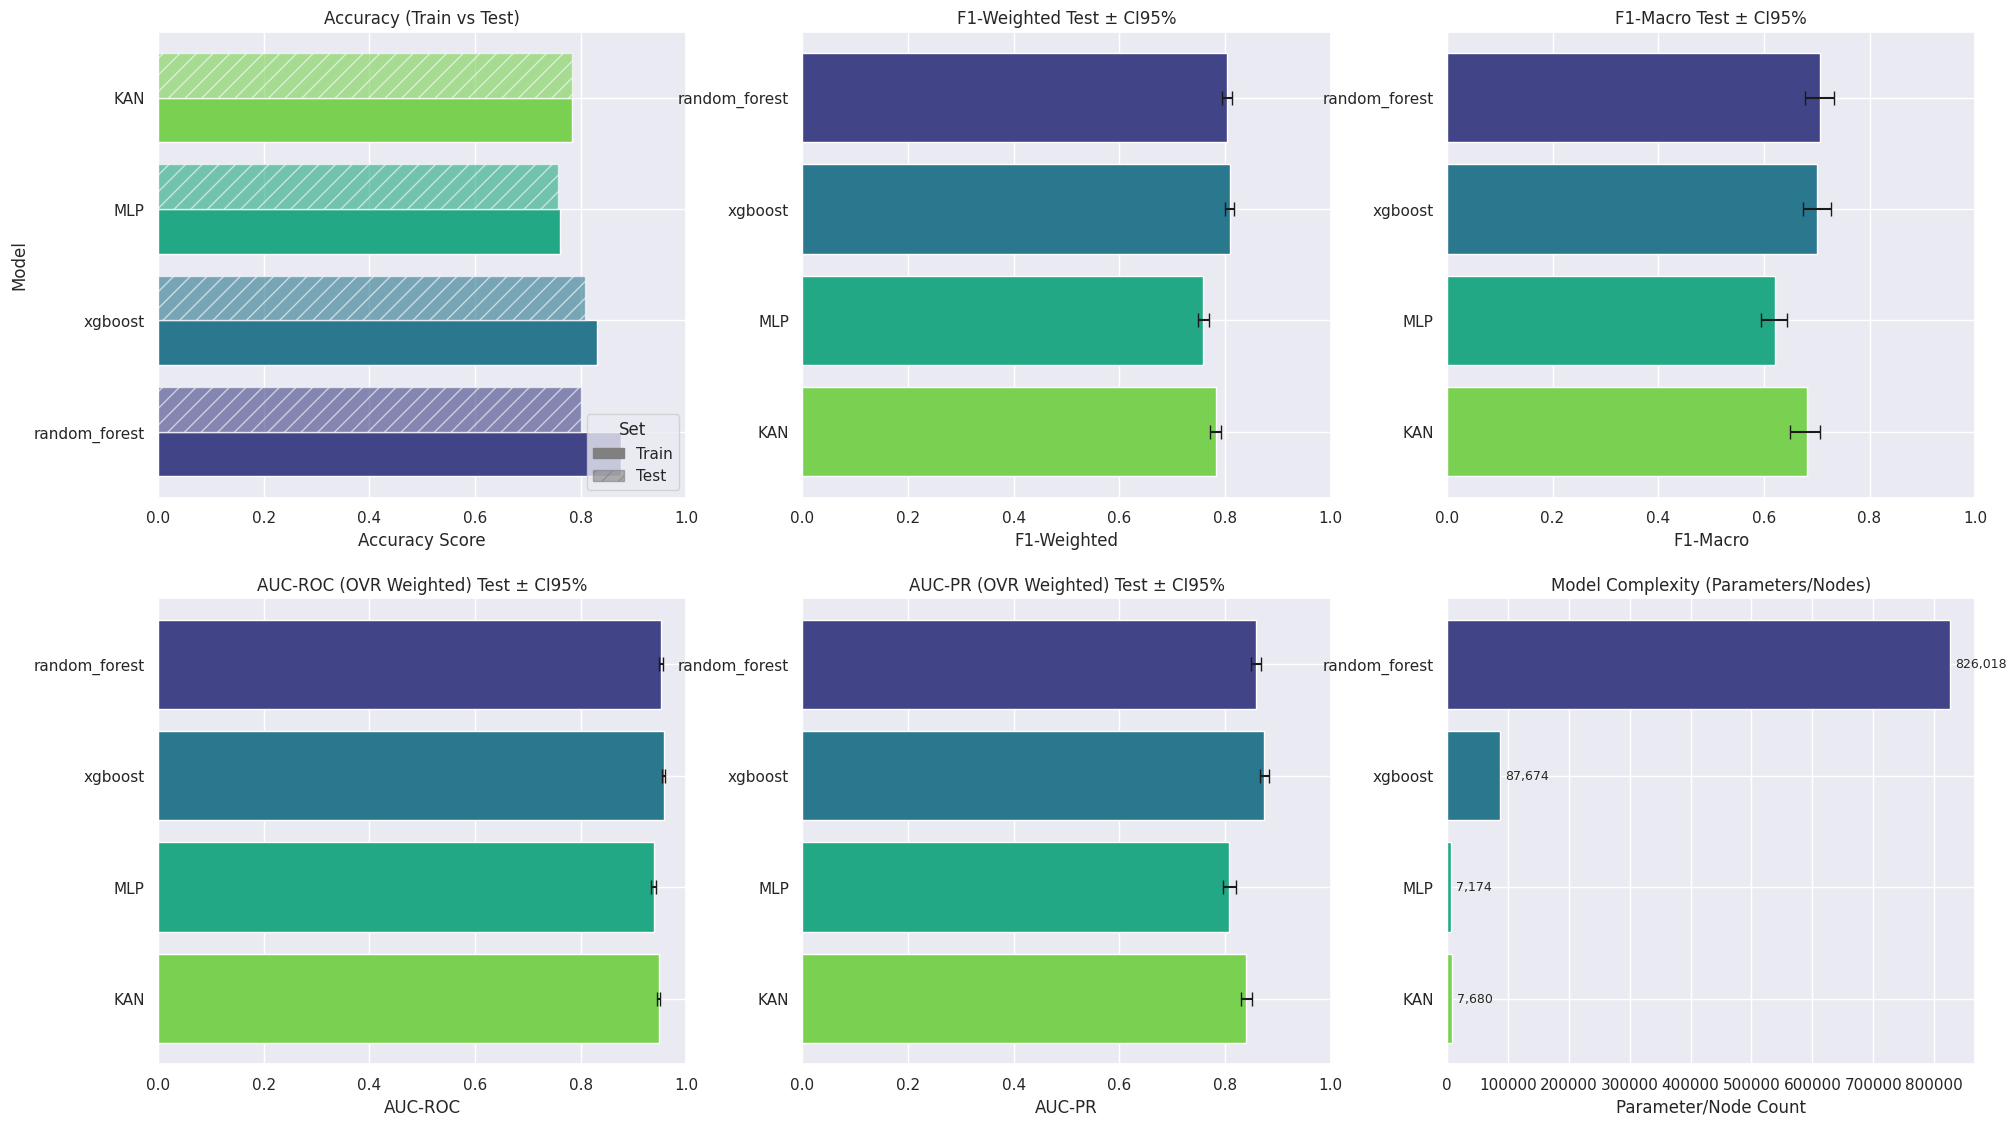

In [46]:
estimator_scores_df = pd.DataFrame(
    all_scores,
    columns = [
        'Model', 'Param_Count',
        'Accuracy_Train', 'Accuracy_Test',
        'F1_Weighted_Train', 'F1_Weighted_Test', 'F1_Weighted_CI_Low', 'F1_Weighted_CI_High',
        'F1_Macro_Train', 'F1_Macro_Test', 'F1_Macro_CI_Low', 'F1_Macro_CI_High',
        'AUC_ROC_OVR_Weighted', 'AUC_ROC_CI_Low', 'AUC_ROC_CI_High',
        'AUC_PR_OVR_Weighted', 'AUC_PR_CI_Low', 'AUC_PR_CI_High'
    ]
)
plot_estimator_scores(estimator_scores_df)

# Selezione del Miglior Modello
Calcoliamo un punteggio complessivo per ciascun modello basandoci sulle metriche di valutazione.

In [47]:
# 1) Define metrics and their optimization direction
metrics = {
    'Accuracy_Test': 'max',
    'F1_Weighted_Test': 'max',
    'F1_Macro_Test': 'max',
    'AUC_ROC_OVR_Weighted': 'max',
    'AUC_PR_OVR_Weighted': 'max'
}

# 2) Build ranking DataFrame
df_ranks = estimator_scores_df.set_index('Model')
ranks = pd.DataFrame(index=df_ranks.index)

# Calculate ranks for performance metrics
for metric, direction in metrics.items():
    if direction == 'max':
        # Per metriche 'max' (più alto è meglio), rank in ordine decrescente (rank 1 al migliore)
        ranks[f"{metric}_rank"] = df_ranks[metric].rank(ascending=False, method='average')
    elif direction == 'min':
        # Per metriche 'min' (più basso è meglio), rank in ordine crescente (rank 1 al migliore)
        ranks[f"{metric}_rank"] = df_ranks[metric].rank(ascending=True, method='average')

# Calculate complexity rank (lower parameter count is better)
ranks['Complexity_rank'] = df_ranks['Param_Count'].rank(ascending=True, method='average')

# 3) Calculate weighted scores
# Performance score (average of performance ranks)
performance_cols = [col for col in ranks.columns if col.endswith('_rank') and col != 'Complexity_rank']
ranks['performance_score'] = ranks[performance_cols].mean(axis=1)

# Method 1: Equal weighting
ranks['equal_weight_score'] = ranks['performance_score'] + ranks['Complexity_rank']

# Method 2: Complexity heavily weighted (complexity counts 2x)
ranks['complexity_weighted_score'] = ranks['performance_score'] + (2 * ranks['Complexity_rank'])

# Method 3: Extreme complexity weighting (complexity counts 3x)
ranks['extreme_complexity_score'] = ranks['performance_score'] + (3 * ranks['Complexity_rank'])

# Method 4: Pareto efficiency approach (performance vs complexity)
# Normalize scores to [0,1] for fair comparison
performance_norm = (ranks['performance_score'] - ranks['performance_score'].min()) / (ranks['performance_score'].max() - ranks['performance_score'].min())
complexity_norm = (ranks['Complexity_rank'] - ranks['Complexity_rank'].min()) / (ranks['Complexity_rank'].max() - ranks['Complexity_rank'].min())
ranks['pareto_score'] = 0.4 * performance_norm + 0.6 * complexity_norm  # 60% weight on complexity

# Display results for each method
methods = {
    'Equal Weight (1:1)': 'equal_weight_score',
    'Complexity Weighted (1:2)': 'complexity_weighted_score',
    'Extreme Complexity (1:3)': 'extreme_complexity_score',
    'Pareto Approach (40:60)': 'pareto_score'
}

results_summary = pd.DataFrame(index=df_ranks.index)
results_summary['Performance_Score'] = ranks['performance_score']
results_summary['Complexity_Rank'] = ranks['Complexity_rank']
results_summary['Param_Count'] = df_ranks['Param_Count']

for method_name, score_col in methods.items():
    best_model = ranks[score_col].idxmin() if 'pareto' not in score_col else ranks[score_col].idxmin()
    best_score = ranks.loc[best_model, score_col]
    results_summary[method_name] = ranks[score_col]
    print(f"{method_name:25} -> {best_model:15} (score: {best_score:.3f})")

print("\n" + "="*70)
print("DETAILED RANKING TABLE")
print("="*70)

# Create comprehensive ranking table
ranking_display = pd.DataFrame(index=df_ranks.index)
ranking_display['Param_Count'] = df_ranks['Param_Count'].astype(int)
ranking_display['Avg_Performance'] = ranks['performance_score'].round(2)
ranking_display['Complexity_Rank'] = ranks['Complexity_rank'].astype(int)

for method_name, score_col in methods.items():
    ranking_display[f'{method_name.split()[0]}_Rank'] = ranks[score_col].rank().astype(int)

# Sort by complexity-weighted score (our recommended approach)
ranking_display_sorted = ranking_display.sort_values('Complexity_Rank')
display(ranking_display_sorted)

print("\n" + "="*70)
print("RECOMMENDATION")
print("="*70)

# Our recommended model (complexity weighted approach)
recommended_model = ranks['complexity_weighted_score'].idxmin()
recommended_score = ranks.loc[recommended_model, 'complexity_weighted_score']
recommended_params = df_ranks.loc[recommended_model, 'Param_Count']
recommended_f1 = df_ranks.loc[recommended_model, 'F1_Weighted_Test']

print(f"   RECOMMENDED MODEL: {recommended_model}")
print(f"   Reason: Best balance between performance and complexity")
print(f"   Parameters: {int(recommended_params):,}")
print(f"   F1-Weighted Score: {recommended_f1:.4f}")
print(f"   Complexity-Weighted Rank Score: {recommended_score:.3f}")

# Show top 3 models for comparison
print(f"\n  TOP 3 MODELS (Complexity-Weighted Ranking):")
top_3 = ranks.sort_values('complexity_weighted_score').head(3)
for i, (model, row) in enumerate(top_3.iterrows(), 1):
    params = int(df_ranks.loc[model, 'Param_Count'])
    f1_value = df_ranks.loc[model, 'F1_Weighted_Test']
    print(f"   {i}. {model:15} | Params: {params:>8,} | F1: {f1_value:.4f} | Score: {row['complexity_weighted_score']:.3f}")

Equal Weight (1:1)        -> xgboost         (score: 4.200)
Complexity Weighted (1:2) -> MLP             (score: 6.000)
Extreme Complexity (1:3)  -> MLP             (score: 7.000)
Pareto Approach (40:60)   -> xgboost         (score: 0.400)

DETAILED RANKING TABLE


,Param_Count,Avg_Performance,Complexity_Rank,Equal_Rank,Extreme_Rank,Pareto_Rank
Model,,,,,,
MLP,7174,4.0,1,2,1,2
KAN,7680,3.0,2,2,2,3
xgboost,87674,1.2,3,1,3,1
random_forest,826018,1.8,4,4,4,4



RECOMMENDATION
   RECOMMENDED MODEL: MLP
   Reason: Best balance between performance and complexity
   Parameters: 7,174
   F1-Weighted Score: 0.7589
   Complexity-Weighted Rank Score: 6.000

  TOP 3 MODELS (Complexity-Weighted Ranking):
   1. MLP             | Params:    7,174 | F1: 0.7589 | Score: 6.000
   2. KAN             | Params:    7,680 | F1: 0.7823 | Score: 7.000
   3. xgboost         | Params:   87,674 | F1: 0.8087 | Score: 7.200


# Ablation Study MLP e KAN

=== STANDALONE MLP/KAN PRUNING STUDY ===

=== Standalone L1 Pruning Study for MLP ===
NOTA: MLP è un modello MLP standalone
Total Parameters: 7,174

Testing MLP pruning ratio: 0.0000
  Sparsity: 0.000
  Active params: 7,174 / 7,174
  Compression: 1.00x
  Accuracy: 0.7579
  F1-Weighted: 0.7589

Testing MLP pruning ratio: 0.1000


  Applied L1 pruning to standalone MLP with ratio: 0.100
  Sparsity: 0.100
  Active params: 6,457 / 7,174
  Compression: 1.11x
  Accuracy: 0.7600
  F1-Weighted: 0.7607

Testing MLP pruning ratio: 0.2000
  Applied L1 pruning to standalone MLP with ratio: 0.200
  Sparsity: 0.200
  Active params: 5,739 / 7,174
  Compression: 1.25x
  Accuracy: 0.7623
  F1-Weighted: 0.7608

Testing MLP pruning ratio: 0.3000
  Applied L1 pruning to standalone MLP with ratio: 0.300
  Sparsity: 0.300
  Active params: 5,022 / 7,174
  Compression: 1.43x
  Accuracy: 0.7663
  F1-Weighted: 0.7673

Testing MLP pruning ratio: 0.5000
  Applied L1 pruning to standalone MLP with ratio: 0.500
  Sparsity: 0.500
  Active params: 3,587 / 7,174
  Compression: 2.00x
  Accuracy: 0.7685
  F1-Weighted: 0.7737

Testing MLP pruning ratio: 0.7000


  Applied L1 pruning to standalone MLP with ratio: 0.700
  Sparsity: 0.700
  Active params: 2,152 / 7,174
  Compression: 3.33x
  Accuracy: 0.7670
  F1-Weighted: 0.7666

Testing MLP pruning ratio: 0.8000
  Applied L1 pruning to standalone MLP with ratio: 0.800
  Sparsity: 0.800
  Active params: 1,435 / 7,174
  Compression: 5.00x
  Accuracy: 0.7555
  F1-Weighted: 0.7542

Testing MLP pruning ratio: 0.9000
  Applied L1 pruning to standalone MLP with ratio: 0.900
  Sparsity: 0.900
  Active params: 717 / 7,174
  Compression: 10.01x
  Accuracy: 0.6508
  F1-Weighted: 0.6445

Testing MLP pruning ratio: 0.9500
  Applied L1 pruning to standalone MLP with ratio: 0.950
  Sparsity: 0.950
  Active params: 359 / 7,174
  Compression: 19.98x
  Accuracy: 0.6508
  F1-Weighted: 0.5377

=== Standalone L1 Pruning Study for KAN ===
NOTA: KAN è un modello KAN standalone
Total Parameters: 7,680

Testing KAN pruning ratio: 0.0000


  Sparsity: 0.000
  Active params: 7,680 / 7,680
  Compression: 1.00x
  Accuracy: 0.7839
  F1-Weighted: 0.7823

Testing KAN pruning ratio: 0.1000
  Applied L1 pruning to standalone KAN with ratio: 0.100
  Sparsity: 0.113
  Active params: 7,776 / 7,680
  Compression: 0.99x
  Accuracy: 0.7839
  F1-Weighted: 0.7822

Testing KAN pruning ratio: 0.2000
  Applied L1 pruning to standalone KAN with ratio: 0.200
  Sparsity: 0.225
  Active params: 6,912 / 7,680
  Compression: 1.11x
  Accuracy: 0.7836
  F1-Weighted: 0.7819

Testing KAN pruning ratio: 0.3000
  Applied L1 pruning to standalone KAN with ratio: 0.300


  Sparsity: 0.338
  Active params: 6,048 / 7,680
  Compression: 1.27x
  Accuracy: 0.7850
  F1-Weighted: 0.7828

Testing KAN pruning ratio: 0.5000
  Applied L1 pruning to standalone KAN with ratio: 0.500
  Sparsity: 0.562
  Active params: 4,320 / 7,680
  Compression: 1.78x
  Accuracy: 0.7746
  F1-Weighted: 0.7728

Testing KAN pruning ratio: 0.7000
  Applied L1 pruning to standalone KAN with ratio: 0.700
  Sparsity: 0.787
  Active params: 2,592 / 7,680
  Compression: 2.96x
  Accuracy: 0.7661
  F1-Weighted: 0.7710

Testing KAN pruning ratio: 0.8000
  Applied L1 pruning to standalone KAN with ratio: 0.800


  Sparsity: 0.900
  Active params: 1,728 / 7,680
  Compression: 4.44x
  Accuracy: 0.7473
  F1-Weighted: 0.7574

Testing KAN pruning ratio: 0.9000
  Applied L1 pruning to standalone KAN with ratio: 0.900
  Sparsity: 1.012
  Active params: 864 / 7,680
  Compression: 8.89x
  Accuracy: 0.7030
  F1-Weighted: 0.7117

Testing KAN pruning ratio: 0.9500
  Applied L1 pruning to standalone KAN with ratio: 0.950
  Sparsity: 1.069
  Active params: 432 / 7,680
  Compression: 17.78x
  Accuracy: 0.6777
  F1-Weighted: 0.6875


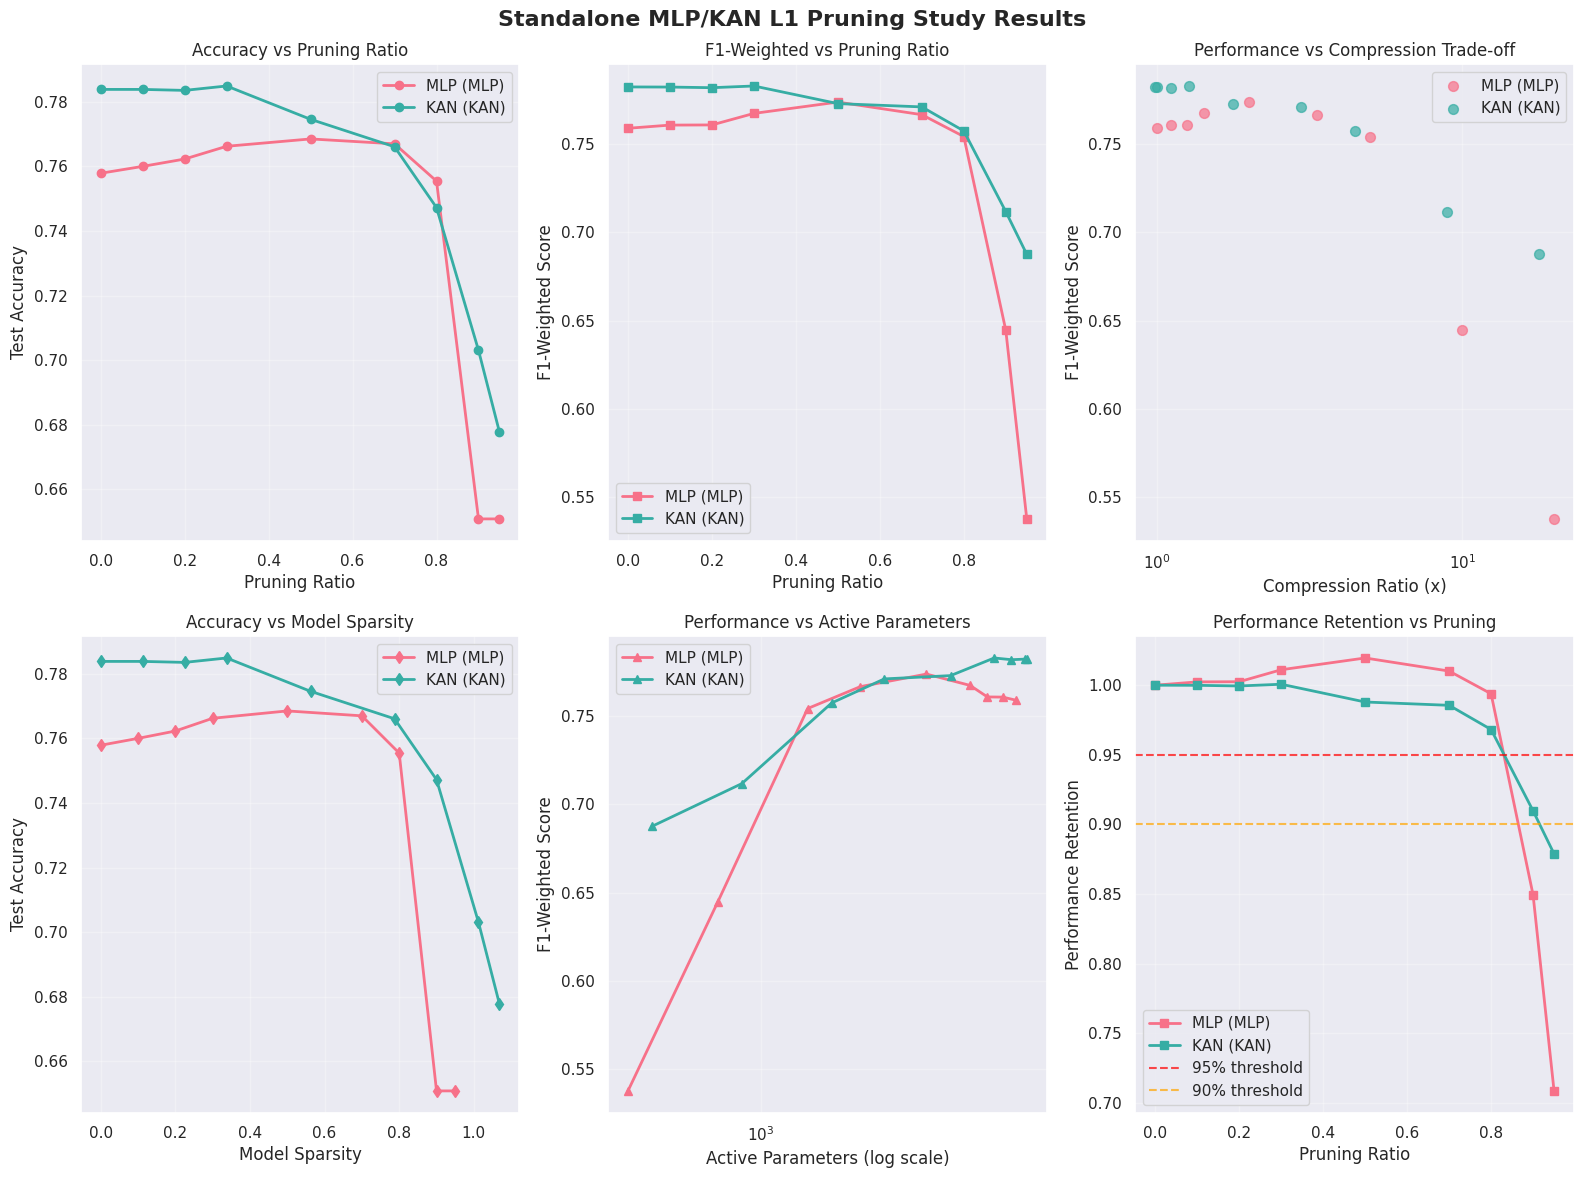


STANDALONE MLP/KAN L1 PRUNING STUDY - DETAILED REPORT

MLP Results:
--------------------------------------------------
Model Type: MLP
Total Parameters: 7,174
Baseline F1-Weighted: 0.7589
Significant degradation starts at: 90.0% pruning

Best trade-off point:
  Pruning ratio: 80.0%
  Compression: 5.0x
  F1_Weighted: 0.7542
  Performance loss: 0.6%

Maximum compression achieved: 20.0x

KAN Results:
--------------------------------------------------
Model Type: KAN
Total Parameters: 7,680
Baseline F1-Weighted: 0.7823
Significant degradation starts at: 90.0% pruning

Best trade-off point:
  Pruning ratio: 70.0%
  Compression: 3.0x
  F1_Weighted: 0.7710
  Performance loss: 1.4%

Maximum compression achieved: 17.8x

COMPARATIVE SUMMARY TABLE - STANDALONE MODELS
Model Type Pruning_Ratio Compression F1_Score Perf_Loss
  MLP  MLP           30%        1.4x   0.7673     -1.1%
  MLP  MLP           50%        2.0x   0.7737     -2.0%
  MLP  MLP           70%        3.3x   0.7666     -1.0%
  MLP  M

,model_name,model_type,pruning_ratio,sparsity,total_params,active_params,compression_ratio,accuracy,f1_weighted,f1_macro,auc_roc,auc_pr
0,MLP,MLP,0.00,0.000000,7174,7174,1.000000,0.757903,0.758876,0.620562,0.938212,0.807507
1,MLP,MLP,0.10,0.099944,7174,6457,1.111042,0.760030,0.760681,0.621703,0.938489,0.807393
2,MLP,MLP,0.20,0.200028,7174,5739,1.250044,0.762310,0.760772,0.615842,0.938610,0.806063
3,MLP,MLP,0.30,0.299972,7174,5022,1.428515,0.766261,0.767300,0.634156,0.938595,0.810732
4,MLP,MLP,0.50,0.500000,7174,3587,2.000000,0.768541,0.773718,0.656366,0.935484,0.806952
5,MLP,MLP,0.70,0.700028,7174,2152,3.333643,0.767021,0.766579,0.599816,0.930674,0.787432
6,MLP,MLP,0.80,0.799972,7174,1435,4.999303,0.755471,0.754200,0.577665,0.925692,0.763534
7,MLP,MLP,0.90,0.900056,7174,717,10.005579,0.650760,0.644537,0.438068,0.907426,0.708791
8,MLP,MLP,0.95,0.949958,7174,359,19.983287,0.650760,0.537666,0.260912,0.906869,0.722015
9,KAN,KAN,0.00,0.000000,7680,7680,1.000000,0.783891,0.782290,0.681209,0.947651,0.840296


In [48]:
class StandalonePruningAblationStudy:
    def __init__(self, device='cpu'):
        self.device = device
        self.pruning_results = []

    def get_model_sparsity(self, model):
        """Calcola la sparsità per modelli MLP/KAN standalone"""
        if hasattr(model, 'width') and hasattr(model, 'act_fun'):
            # Modello KAN standalone
            try:
                # Calcola parametri totali KAN usando count_params esistente
                total_params = count_params(model)

                # Conta i parametri zero nella componente KAN
                zero_params = 0
                for i in range(len(model.width) - 1):
                    if i < len(model.act_fun):
                        layer = model.act_fun[i]
                        # Accedi ai coefficienti spline (coef parameter)
                        if hasattr(layer, 'coef') and layer.coef is not None:
                            zero_params += float(torch.sum(layer.coef == 0))

                return zero_params / total_params if total_params > 0 else 0.0

            except Exception as e:
                print(f"  Error calculating KAN sparsity: {e}")
                return 0.0

        else:
            # Modello MLP standalone
            zero_params = 0
            total_params = count_params(model)

            # Conta parametri zero in tutti i layer Linear
            for module in model.modules():
                if isinstance(module, torch.nn.Linear):
                    if hasattr(module, 'weight'):
                        zero_params += float(torch.sum(module.weight == 0))
                    if hasattr(module, 'bias') and module.bias is not None:
                        zero_params += float(torch.sum(module.bias == 0))

            return zero_params / total_params if total_params > 0 else 0.0

    def count_active_parameters(self, model):
        """Conta i parametri attivi nei modelli MLP/KAN standalone"""
        if hasattr(model, 'width') and hasattr(model, 'act_fun'):
            # Modello KAN standalone
            try:
                active_params = 0
                for i in range(len(model.width) - 1):
                    if i < len(model.act_fun):
                        layer = model.act_fun[i]
                        if hasattr(layer, 'coef') and layer.coef is not None:
                            active_params += float(torch.sum(layer.coef != 0))

                return int(active_params)
            except:
                return count_params(model)

        else:
            # Modello MLP standalone
            active_params = 0
            for module in model.modules():
                if isinstance(module, torch.nn.Linear):
                    if hasattr(module, 'weight'):
                        active_params += float(torch.sum(module.weight != 0))
                    if hasattr(module, 'bias') and module.bias is not None:
                        active_params += float(torch.sum(module.bias != 0))

            return int(active_params)


    def apply_l1_pruning_standalone(self, model, pruning_ratio):
        """Applica L1 norm pruning a modelli MLP/KAN standalone"""
        pruned_model = copy.deepcopy(model)

        if hasattr(model, 'width') and hasattr(model, 'act_fun'):
            # Modello KAN standalone
            try:
                if pruning_ratio == 0.0:
                    return pruned_model

                # Colleziona tutti i parametri KAN per L1 pruning globale
                kan_modules_to_prune = []
                for i in range(len(model.width) - 1):
                    if i < len(model.act_fun):
                        layer = pruned_model.act_fun[i]
                        if hasattr(layer, 'coef') and layer.coef is not None:
                            temp_module = torch.nn.Linear(1, 1, bias=False)
                            temp_module.weight = torch.nn.Parameter(layer.coef.view(-1, 1))
                            kan_modules_to_prune.append((temp_module, 'weight'))


                if kan_modules_to_prune:
                    # Applica L1 pruning globale sui parametri KAN
                    prune.global_unstructured(
                        kan_modules_to_prune,
                        pruning_method=prune.L1Unstructured,
                        amount=pruning_ratio,
                    )

                    # Applica le maschere ai coefficienti originali
                    idx = 0
                    for i in range(len(model.width) - 1):
                        if i < len(model.act_fun):
                            layer = pruned_model.act_fun[i]
                            if hasattr(layer, 'coef') and layer.coef is not None:
                                original_shape = layer.coef.shape
                                mask = kan_modules_to_prune[idx][0].weight_mask.view(original_shape)
                                layer.coef.data = layer.coef.data * mask
                                idx += 1

                    # Rimuove le maschere temporanee
                    for module, param_name in kan_modules_to_prune:
                        prune.remove(module, param_name)

                print(f"  Applied L1 pruning to standalone KAN with ratio: {pruning_ratio:.3f}")
                return pruned_model

            except Exception as e:
                print(f"  Error during KAN L1 pruning: {e}")
                return model

        else:
            # Modello MLP standalone
            modules_to_prune = []

            # Colleziona tutti i layer Linear
            for module in pruned_model.modules():
                if isinstance(module, torch.nn.Linear):
                    modules_to_prune.append((module, 'weight'))
                    if hasattr(module, 'bias') and module.bias is not None:
                        modules_to_prune.append((module, 'bias'))

            if modules_to_prune:
                # Applica L1 pruning globale
                prune.global_unstructured(
                    modules_to_prune,
                    pruning_method=prune.L1Unstructured,
                    amount=pruning_ratio,
                )

                # Rende permanente il pruning
                for module, param_name in modules_to_prune:
                    prune.remove(module, param_name)

            print(f"  Applied L1 pruning to standalone MLP with ratio: {pruning_ratio:.3f}")
            return pruned_model


    def evaluate_pruned_model(self, model, model_name, X_test, y_test, X_train, y_train):
        """Valuta le prestazioni di un modello pruned su dati tabulari"""
        # Ensure the model is on the correct device
        model.to(self.device)
        model.eval()

        # Converte in tensori, se necessario, e sposta sul device
        if not isinstance(X_test, torch.Tensor):
            X_test = torch.FloatTensor(X_test).to(self.device)
        else:
            X_test = X_test.to(self.device)

        if not isinstance(y_test, torch.Tensor):
            y_test = torch.LongTensor(y_test).to(self.device)
        else:
             y_test = y_test.to(self.device)

        if not isinstance(X_train, torch.Tensor):
            X_train = torch.FloatTensor(X_train).to(self.device)
        else:
            X_train = X_train.to(self.device)

        if not isinstance(y_train, torch.Tensor):
            y_train = torch.LongTensor(y_train).to(self.device)
        else:
            y_train = y_train.to(self.device)


        # Predizioni
        with torch.no_grad():
            # Test set
            outputs_test = model(X_test)
            y_pred_test = torch.argmax(outputs_test, dim=1)
            y_proba_test = F.softmax(outputs_test, dim=1)

            # Train set
            outputs_train = model(X_train)
            y_pred_train = torch.argmax(outputs_train, dim=1)

        # Converte in NumPy per le metriche
        y_pred_test = y_pred_test.cpu().numpy()
        y_true_test = y_test.cpu().numpy()
        y_proba_test = y_proba_test.cpu().numpy()
        y_pred_train = y_pred_train.cpu().numpy()
        y_true_train = y_train.cpu().numpy()


        # Calcola metriche
        accuracy = accuracy_score(y_true_test, y_pred_test)
        f1_weighted = f1_score(y_true_test, y_pred_test, average='weighted', zero_division=0)
        f1_macro = f1_score(y_true_test, y_pred_test, average='macro', zero_division=0)

        # Metriche AUC
        try:
            auc_roc = roc_auc_score(y_true_test, y_proba_test, multi_class='ovr', average='weighted')
            auc_pr = average_precision_score(pd.get_dummies(y_true_test), y_proba_test, average='weighted')
        except ValueError:
            auc_roc = np.nan
            auc_pr = np.nan

        return {
            'model_name': model_name,
            'accuracy': accuracy,
            'f1_weighted': f1_weighted,
            'f1_macro': f1_macro,
            'auc_roc': auc_roc,
            'auc_pr': auc_pr
        }


    def run_standalone_pruning_study(self, model, model_name, X_test, y_test, X_train, y_train,
                                   pruning_ratios=[0.0, 0.1, 0.2, 0.3, 0.5, 0.7, 0.8, 0.9, 0.95]):
        """
        Conduce lo studio di ablazione con L1 pruning su modelli standalone MLP/KAN
        """
        print(f"\n=== Standalone L1 Pruning Study for {model_name} ===")

        # Determina il tipo di modello
        if hasattr(model, 'width') and hasattr(model, 'act_fun'):
            model_type = "KAN"
            print(f"NOTA: {model_name} è un modello KAN standalone")
        else:
            model_type = "MLP"
            print(f"NOTA: {model_name} è un modello MLP standalone")

        # Parametri totali usando count_params
        total_params = count_params(model)
        print(f"Total Parameters: {total_params:,}")

        for pruning_ratio in pruning_ratios:
            print(f"\nTesting {model_type} pruning ratio: {pruning_ratio:.4f}")

            if pruning_ratio == 0.0:
                # Modello originale
                pruned_model = model
                sparsity = 0.0
                active_params = total_params
            else:
                # Applica L1 pruning
                pruned_model = self.apply_l1_pruning_standalone(model, pruning_ratio)
                pruned_model.to(self.device)
                sparsity = self.get_model_sparsity(pruned_model)
                active_params = self.count_active_parameters(pruned_model)

            # Valuta prestazioni
            metrics = self.evaluate_pruned_model(
                pruned_model, model_name, X_test, y_test, X_train, y_train
            )

            # Calcola statistiche di compressione
            compression_ratio = total_params / active_params if active_params > 0 else float('inf')

            # Salva risultati
            result = {
                'model_name': model_name,
                'model_type': model_type,
                'pruning_ratio': pruning_ratio,
                'sparsity': sparsity,
                'total_params': total_params,
                'active_params': active_params,
                'compression_ratio': compression_ratio,
                'accuracy': metrics['accuracy'],
                'f1_weighted': metrics['f1_weighted'],
                'f1_macro': metrics['f1_macro'],
                'auc_roc': metrics['auc_roc'],
                'auc_pr': metrics['auc_pr']
            }

            self.pruning_results.append(result)

            print(f"  Sparsity: {sparsity:.3f}")
            print(f"  Active params: {active_params:,} / {total_params:,}")
            print(f"  Compression: {compression_ratio:.2f}x")
            print(f"  Accuracy: {metrics['accuracy']:.4f}")
            print(f"  F1-Weighted: {metrics['f1_weighted']:.4f}")


    def plot_standalone_pruning_results(self, figsize=(16, 12)):
        """
        Visualizza i risultati dello studio di pruning per modelli standalone
        """
        if not self.pruning_results:
            print("No pruning results to plot. Run pruning study first.")
            return

        df = pd.DataFrame(self.pruning_results)

        fig, axes = plt.subplots(2, 3, figsize=figsize)
        fig.suptitle('Standalone MLP/KAN L1 Pruning Study Results', fontsize=16, fontweight='bold')

        models = df['model_name'].unique()
        colors = sns.color_palette("husl", len(models))

        # Plot 1: Accuracy vs Pruning Ratio
        ax = axes[0, 0]
        for i, model in enumerate(models):
            model_data = df[df['model_name'] == model]
            model_type = model_data.iloc[0]['model_type']
            ax.plot(model_data['pruning_ratio'], model_data['accuracy'],
                   marker='o', label=f'{model} ({model_type})', color=colors[i], linewidth=2)
        ax.set_xlabel('Pruning Ratio')
        ax.set_ylabel('Test Accuracy')
        ax.set_title('Accuracy vs Pruning Ratio')
        ax.legend()
        ax.grid(True, alpha=0.3)

        # Plot 2: F1-Weighted vs Pruning Ratio
        ax = axes[0, 1]
        for i, model in enumerate(models):
            model_data = df[df['model_name'] == model]
            model_type = model_data.iloc[0]['model_type']
            ax.plot(model_data['pruning_ratio'], model_data['f1_weighted'],
                   marker='s', label=f'{model} ({model_type})', color=colors[i], linewidth=2)
        ax.set_xlabel('Pruning Ratio')
        ax.set_ylabel('F1-Weighted Score')
        ax.set_title('F1-Weighted vs Pruning Ratio')
        ax.legend()
        ax.grid(True, alpha=0.3)

        # Plot 3: Performance vs Compression Ratio
        ax = axes[0, 2]
        for i, model in enumerate(models):
            model_data = df[df['model_name'] == model]
            model_type = model_data.iloc[0]['model_type']
            finite_mask = np.isfinite(model_data['compression_ratio'])
            if finite_mask.any():
                ax.scatter(model_data.loc[finite_mask, 'compression_ratio'],
                          model_data.loc[finite_mask, 'f1_weighted'],
                          label=f'{model} ({model_type})', color=colors[i], s=50, alpha=0.7)
        ax.set_xlabel('Compression Ratio (x)')
        ax.set_ylabel('F1-Weighted Score')
        ax.set_title('Performance vs Compression Trade-off')
        ax.legend()
        ax.grid(True, alpha=0.3)
        ax.set_xscale('log')

        # Plot 4: Sparsity vs Performance
        ax = axes[1, 0]
        for i, model in enumerate(models):
            model_data = df[df['model_name'] == model]
            model_type = model_data.iloc[0]['model_type']
            ax.plot(model_data['sparsity'], model_data['accuracy'],
                   marker='d', label=f'{model} ({model_type})', color=colors[i], linewidth=2)
        ax.set_xlabel('Model Sparsity')
        ax.set_ylabel('Test Accuracy')
        ax.set_title('Accuracy vs Model Sparsity')
        ax.legend()
        ax.grid(True, alpha=0.3)

        # Plot 5: Active Parameters vs Performance
        ax = axes[1, 1]
        for i, model in enumerate(models):
            model_data = df[df['model_name'] == model]
            model_type = model_data.iloc[0]['model_type']
            ax.semilogx(model_data['active_params'], model_data['f1_weighted'],
                       marker='^', label=f'{model} ({model_type})', color=colors[i], linewidth=2)
        ax.set_xlabel('Active Parameters (log scale)')
        ax.set_ylabel('F1-Weighted Score')
        ax.set_title('Performance vs Active Parameters')
        ax.legend()
        ax.grid(True, alpha=0.3)

        # Plot 6: Performance Retention
        ax = axes[1, 2]
        for i, model in enumerate(models):
            model_data = df[df['model_name'] == model].sort_values('pruning_ratio')
            model_type = model_data.iloc[0]['model_type']
            baseline_f1 = model_data.iloc[0]['f1_weighted']
            performance_retention = model_data['f1_weighted'] / baseline_f1
            ax.plot(model_data['pruning_ratio'], performance_retention,
                   marker='s', label=f'{model} ({model_type})', color=colors[i], linewidth=2)
        ax.set_xlabel('Pruning Ratio')
        ax.set_ylabel('Performance Retention')
        ax.set_title('Performance Retention vs Pruning')
        ax.axhline(y=0.95, color='red', linestyle='--', alpha=0.7, label='95% threshold')
        ax.axhline(y=0.90, color='orange', linestyle='--', alpha=0.7, label='90% threshold')
        ax.legend()
        ax.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

    def generate_standalone_pruning_report(self):
        """
        Genera un report dettagliato per i risultati del pruning standalone
        """
        if not self.pruning_results:
            print("No pruning results available. Run pruning study first.")
            return

        df = pd.DataFrame(self.pruning_results)

        print("\n" + "="*80)
        print("STANDALONE MLP/KAN L1 PRUNING STUDY - DETAILED REPORT")
        print("="*80)

        for model_name in df['model_name'].unique():
            model_data = df[df['model_name'] == model_name].sort_values('pruning_ratio')

            print(f"\n{model_name} Results:")
            print("-" * 50)

            # Informazioni base
            baseline_row = model_data.iloc[0]
            baseline_f1 = baseline_row['f1_weighted']
            total_params = baseline_row['total_params']
            model_type = baseline_row['model_type']

            print(f"Model Type: {model_type}")
            print(f"Total Parameters: {total_params:,}")
            print(f"Baseline F1-Weighted: {baseline_f1:.4f}")

            # Trova il punto di degradazione significativa (>5% loss in F1)
            degradation_point = None
            for _, row in model_data.iterrows():
                f1_loss = (baseline_f1 - row['f1_weighted']) / baseline_f1
                if f1_loss > 0.05:  # 5% degradation threshold
                    degradation_point = row['pruning_ratio']
                    break

            if degradation_point:
                print(f"Significant degradation starts at: {degradation_point:.1%} pruning")
            else:
                print("No significant degradation observed within tested range")

            # Migliore trade-off (massima compressione con <2% loss)
            best_tradeoff = None
            for _, row in model_data.iterrows():
                f1_loss = (baseline_f1 - row['f1_weighted']) / baseline_f1
                if f1_loss <= 0.02 and row['pruning_ratio'] > 0:
                    best_tradeoff = row

            if best_tradeoff is not None:
                print(f"\nBest trade-off point:")
                print(f"  Pruning ratio: {best_tradeoff['pruning_ratio']:.1%}")
                print(f"  Compression: {best_tradeoff['compression_ratio']:.1f}x")
                print(f"  F1_Weighted: {best_tradeoff['f1_weighted']:.4f}")
                print(f"  Performance loss: {((baseline_f1 - best_tradeoff['f1_weighted'])/baseline_f1)*100:.1f}%")

            # Statistiche di compressione
            max_compression = model_data['compression_ratio'].replace([np.inf, -np.inf], np.nan).max()
            if not np.isnan(max_compression):
                print(f"\nMaximum compression achieved: {max_compression:.1f}x")

        # Tabella comparativa
        print(f"\n{'='*80}")
        print("COMPARATIVE SUMMARY TABLE - STANDALONE MODELS")
        print("="*80)

        summary_rows = []
        for model_name in df['model_name'].unique():
            model_data = df[df['model_name'] == model_name]
            baseline = model_data[model_data['pruning_ratio'] == 0.0].iloc[0]
            model_type = baseline['model_type']

            # Trova risultati a diverse soglie di pruning
            for target_ratio in [0.3, 0.5, 0.7, 0.9]:
                closest = model_data.iloc[(model_data['pruning_ratio'] - target_ratio).abs().argsort()].iloc[0]
                if abs(closest['pruning_ratio'] - target_ratio) < 0.1:  # Se abbastanza vicino
                    performance_loss = ((baseline['f1_weighted'] - closest['f1_weighted']) / baseline['f1_weighted']) * 100
                    summary_rows.append({
                        'Model': model_name,
                        'Type': model_type,
                        'Pruning_Ratio': f"{target_ratio:.0%}",
                        'Compression': f"{closest['compression_ratio']:.1f}x",
                        'F1_Score': f"{closest['f1_weighted']:.4f}",
                        'Perf_Loss': f"{performance_loss:.1f}%"
                    })

        if summary_rows:
            summary_df = pd.DataFrame(summary_rows)
            print(summary_df.to_string(index=False))

print("=== STANDALONE MLP/KAN PRUNING STUDY ===")

standalone_pruning_study = StandalonePruningAblationStudy(device=device)

standalone_pruning_study.run_standalone_pruning_study(
    model=best_model_mlp,
    model_name='MLP',
    X_test=X_test_tensor,
    y_test=y_test_tensor,
    X_train=X_tensor,
    y_train=y_tensor,
    pruning_ratios=[0.0, 0.1, 0.2, 0.3, 0.5, 0.7, 0.8, 0.9, 0.95]
)

standalone_pruning_study.run_standalone_pruning_study(
    model=best_model_kan,
    model_name='KAN',
    X_test=X_test_tensor,
    y_test=y_test_tensor,
    X_train=X_tensor,
    y_train=y_tensor,
    pruning_ratios=[0.0, 0.1, 0.2, 0.3, 0.5, 0.7, 0.8, 0.9, 0.95]
)

standalone_pruning_study.plot_standalone_pruning_results()
standalone_pruning_study.generate_standalone_pruning_report()

results_df = pd.DataFrame(standalone_pruning_study.pruning_results)
print(f"\nResults saved to DataFrame with {len(results_df)} rows")
print("\nPruning results:")
display(results_df)

# Ablation Study RandomForest e XGBoost

In [49]:
class EnsemblePruningAblationStudy:
    def __init__(self):
        self.pruning_results = []

    def rank_based_pruning_rf(self, rf_model, pruning_ratio):
        """
        Implementa Rank-Based Pruning per Random Forest.
        Rimuove gli alberi con le feature importance più basse.
        """
        if pruning_ratio == 0.0:
            return rf_model, list(range(len(rf_model.estimators_)))

        # Calcola l'importanza di ogni albero basata sulla media delle feature importance
        tree_importances = []
        for i, tree in enumerate(rf_model.estimators_):
            # L'importanza dell'albero è la somma delle importanze delle sue feature
            tree_importance = np.sum(tree.feature_importances_)
            tree_importances.append((i, tree_importance))

        # Ordina gli alberi per importanza (decrescente)
        tree_importances.sort(key=lambda x: x[1], reverse=True)

        # Calcola quanti alberi mantenere
        n_trees_to_keep = max(1, int(len(rf_model.estimators_) * (1 - pruning_ratio)))

        # Seleziona gli indici degli alberi da mantenere
        selected_indices = [idx for idx, _ in tree_importances[:n_trees_to_keep]]
        selected_indices.sort()  # Mantieni l'ordine originale

        # Crea un nuovo modello con solo gli alberi selezionati
        pruned_rf = copy.deepcopy(rf_model)
        pruned_rf.estimators_ = [rf_model.estimators_[i] for i in selected_indices]
        pruned_rf.n_estimators = len(selected_indices)

        return pruned_rf, selected_indices

    def cumulative_pruning_xgb(self, xgb_model, pruning_ratio):
        """
        Implementa Cumulative Pruning per XGBoost.
        Mantiene solo le prime iterazioni di boosting in base al pruning_ratio.
        """
        if pruning_ratio == 0.0:
            return xgb_model, list(range(xgb_model.n_estimators))

        # Ottieni il booster
        original_booster = xgb_model.get_booster()

        # Calcola il numero di alberi da mantenere
        total_trees = xgb_model.n_estimators
        num_classes = xgb_model.n_classes_
        total_rounds = total_trees // num_classes
        keep_rounds = max(1, int(total_rounds * (1 - pruning_ratio)))
        n_keep = keep_rounds * num_classes

        # Crea una copia del modello originale
        pruned_model = copy.deepcopy(xgb_model)
        pruned_model.n_estimators = n_keep

        def predict_pruned(self, X):
            dmat = xgb.DMatrix(X)
            raw_predictions = self.get_booster().predict(dmat, iteration_range=(0, n_keep))
            predicted_labels = np.argmax(raw_predictions, axis=1)
            return predicted_labels

        def predict_proba(self, X):
            dmat = xgb.DMatrix(X)
            raw_predictions = self.get_booster().predict(dmat, iteration_range=(0, n_keep))
            proba = np.exp(raw_predictions) / np.sum(np.exp(raw_predictions), axis=1, keepdims=True)
            return proba

        pruned_model.predict = types.MethodType(predict_pruned, pruned_model)
        pruned_model.predict_proba = types.MethodType(predict_proba, pruned_model)

        selected_indices = list(range(n_keep))
        return pruned_model, selected_indices

    def evaluate_pruned_ensemble(self, model, model_name, X_test, y_test, X_train, y_train):
        """Valuta le prestazioni di un modello ensemble pruned"""

        # Previsioni
        y_pred_test = model.predict(X_test)
        y_pred_train = model.predict(X_train)

        # Calcola metriche
        accuracy = accuracy_score(y_test, y_pred_test)
        f1_weighted = f1_score(y_test, y_pred_test, average='weighted', zero_division=0)
        f1_macro = f1_score(y_test, y_pred_test, average='macro', zero_division=0)

        # Metriche AUC (se il modello supporta predict_proba)
        try:
            if hasattr(model, 'predict_proba'):
                y_proba_test = model.predict_proba(X_test)
                auc_roc = roc_auc_score(y_test, y_proba_test, multi_class='ovr', average='weighted')
                auc_pr = average_precision_score(pd.get_dummies(y_test), y_proba_test, average='weighted')
            else:
                auc_roc = np.nan
                auc_pr = np.nan
        except (ValueError, AttributeError):
            auc_roc = np.nan
            auc_pr = np.nan

        return {
            'model_name': model_name,
            'accuracy': accuracy,
            'f1_weighted': f1_weighted,
            'f1_macro': f1_macro,
            'auc_roc': auc_roc,
            'auc_pr': auc_pr
        }

    def run_rf_pruning_study(self, rf_model, model_name, X_test, y_test, X_train, y_train,
                           pruning_ratios=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]):
        """
        Conduce lo studio di ablazione con Rank-Based Pruning su Random Forest
        """
        print(f"\n=== Rank-Based Pruning Study for {model_name} ===")

        # Parametri totali (numero di alberi)
        total_trees = len(rf_model.estimators_)
        print(f"Total Trees: {total_trees:,}")

        for pruning_ratio in pruning_ratios:
            print(f"\nTesting RF pruning ratio: {pruning_ratio:.2f}")

            # Applica rank-based pruning
            pruned_model, selected_indices = self.rank_based_pruning_rf(rf_model, pruning_ratio)

            # Calcola statistiche
            remaining_trees = len(selected_indices)
            compression_ratio = total_trees / remaining_trees if remaining_trees > 0 else float('inf')

            # Valuta prestazioni
            metrics = self.evaluate_pruned_ensemble(
                pruned_model, model_name, X_test, y_test, X_train, y_train
            )

            # Salva risultati
            result = {
                'model_name': model_name,
                'model_type': 'Random Forest',
                'pruning_method': 'Rank-Based',
                'pruning_ratio': pruning_ratio,
                'total_trees': total_trees,
                'remaining_trees': remaining_trees,
                'compression_ratio': compression_ratio,
                'accuracy': metrics['accuracy'],
                'f1_weighted': metrics['f1_weighted'],
                'f1_macro': metrics['f1_macro'],
                'auc_roc': metrics['auc_roc'],
                'auc_pr': metrics['auc_pr']
            }

            self.pruning_results.append(result)

            print(f"  Remaining trees: {remaining_trees:,} / {total_trees:,}")
            print(f"  Compression: {compression_ratio:.2f}x")
            print(f"  Accuracy: {metrics['accuracy']:.4f}")
            print(f"  F1-Weighted: {metrics['f1_weighted']:.4f}")

    def run_xgb_pruning_study(self, xgb_model, model_name, X_test, y_test, X_train, y_train,
                            pruning_ratios=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]):
        """
        Conduce lo studio di ablazione con Cumulative Pruning su XGBoost
        """
        print(f"\n=== Cumulative Pruning Study for {model_name} ===")

        # Parametri totali (numero di alberi)
        total_trees = xgb_model.n_estimators
        print(f"Total Trees: {total_trees:,}")
        print(f"Number of Classes: {xgb_model.n_classes_}")

        for pruning_ratio in pruning_ratios:
            print(f"\nTesting XGB pruning ratio: {pruning_ratio:.2f}")

            try:
                # Applica cumulative pruning
                pruned_model, selected_indices = self.cumulative_pruning_xgb(xgb_model, pruning_ratio)

                # Calcola statistiche
                remaining_trees = len(selected_indices)
                compression_ratio = total_trees / remaining_trees if remaining_trees > 0 else float('inf')

                # Valuta prestazioni
                metrics = self.evaluate_pruned_ensemble(
                    pruned_model, model_name, X_test, y_test, X_train, y_train
                )

                # Salva risultati
                result = {
                    'model_name': model_name,
                    'model_type': 'XGBoost',
                    'pruning_method': 'Cumulative',
                    'pruning_ratio': pruning_ratio,
                    'total_trees': total_trees,
                    'remaining_trees': remaining_trees,
                    'compression_ratio': compression_ratio,
                    'accuracy': metrics['accuracy'],
                    'f1_weighted': metrics['f1_weighted'],
                    'f1_macro': metrics['f1_macro'],
                    'auc_roc': metrics['auc_roc'],
                    'auc_pr': metrics['auc_pr']
                }

                self.pruning_results.append(result)

                print(f"  Remaining trees: {remaining_trees:,} / {total_trees:,}")
                print(f"  Compression: {compression_ratio:.2f}x")
                print(f"  Accuracy: {metrics['accuracy']:.4f}")
                print(f"  F1-Weighted: {metrics['f1_weighted']:.4f}")

            except Exception as e:
                print(f"  Error during XGB pruning at ratio {pruning_ratio}: {e}")
                continue

    def plot_ensemble_pruning_results(self, figsize=(18, 12)):
        """
        Visualizza i risultati dello studio di pruning per modelli ensemble
        """
        if not self.pruning_results:
            print("No pruning results to plot. Run pruning studies first.")
            return

        df = pd.DataFrame(self.pruning_results)

        fig, axes = plt.subplots(3, 3, figsize=figsize)
        fig.suptitle('Ensemble Pruning Study Results - Random Forest & XGBoost',
                     fontsize=16, fontweight='bold')

        models = df['model_name'].unique()
        colors = sns.color_palette("Set1", len(models))

        # Plot 1: Accuracy vs Pruning Ratio
        ax = axes[0, 0]
        for i, model in enumerate(models):
            model_data = df[df['model_name'] == model]
            method = model_data.iloc[0]['pruning_method']
            ax.plot(model_data['pruning_ratio'], model_data['accuracy'],
                   marker='o', label=f'{model} ({method})', color=colors[i], linewidth=2)
        ax.set_xlabel('Pruning Ratio')
        ax.set_ylabel('Test Accuracy')
        ax.set_title('Accuracy vs Pruning Ratio')
        ax.legend()
        ax.grid(True, alpha=0.3)

        # Plot 2: F1-Weighted vs Pruning Ratio
        ax = axes[0, 1]
        for i, model in enumerate(models):
            model_data = df[df['model_name'] == model]
            method = model_data.iloc[0]['pruning_method']
            ax.plot(model_data['pruning_ratio'], model_data['f1_weighted'],
                   marker='s', label=f'{model} ({method})', color=colors[i], linewidth=2)
        ax.set_xlabel('Pruning Ratio')
        ax.set_ylabel('F1-Weighted Score')
        ax.set_title('F1-Weighted vs Pruning Ratio')
        ax.legend()
        ax.grid(True, alpha=0.3)

        # Plot 3: F1-Macro vs Pruning Ratio
        ax = axes[0, 2]
        for i, model in enumerate(models):
            model_data = df[df['model_name'] == model]
            method = model_data.iloc[0]['pruning_method']
            ax.plot(model_data['pruning_ratio'], model_data['f1_macro'],
                   marker='^', label=f'{model} ({method})', color=colors[i], linewidth=2)
        ax.set_xlabel('Pruning Ratio')
        ax.set_ylabel('F1-Macro Score')
        ax.set_title('F1-Macro vs Pruning Ratio')
        ax.legend()
        ax.grid(True, alpha=0.3)

        # Plot 4: Performance vs Compression Ratio
        ax = axes[1, 0]
        for i, model in enumerate(models):
            model_data = df[df['model_name'] == model]
            method = model_data.iloc[0]['pruning_method']
            finite_mask = np.isfinite(model_data['compression_ratio'])
            if finite_mask.any():
                ax.scatter(model_data.loc[finite_mask, 'compression_ratio'],
                          model_data.loc[finite_mask, 'f1_weighted'],
                          label=f'{model} ({method})', color=colors[i], s=60, alpha=0.7)
        ax.set_xlabel('Compression Ratio (x)')
        ax.set_ylabel('F1-Weighted Score')
        ax.set_title('Performance vs Compression Trade-off')
        ax.legend()
        ax.grid(True, alpha=0.3)
        ax.set_xscale('log')

        # Plot 5: Remaining Trees vs Performance
        ax = axes[1, 1]
        for i, model in enumerate(models):
            model_data = df[df['model_name'] == model]
            method = model_data.iloc[0]['pruning_method']
            ax.semilogx(model_data['remaining_trees'], model_data['accuracy'],
                       marker='d', label=f'{model} ({method})', color=colors[i], linewidth=2)
        ax.set_xlabel('Remaining Trees (log scale)')
        ax.set_ylabel('Test Accuracy')
        ax.set_title('Accuracy vs Remaining Trees')
        ax.legend()
        ax.grid(True, alpha=0.3)

        # Plot 6: AUC-ROC vs Pruning Ratio
        ax = axes[1, 2]
        for i, model in enumerate(models):
            model_data = df[df['model_name'] == model]
            method = model_data.iloc[0]['pruning_method']
            # Filtra i valori NaN per AUC
            valid_mask = ~np.isnan(model_data['auc_roc'])
            if valid_mask.any():
                valid_data = model_data[valid_mask]
                ax.plot(valid_data['pruning_ratio'], valid_data['auc_roc'],
                       marker='*', label=f'{model} ({method})', color=colors[i], linewidth=2)
        ax.set_xlabel('Pruning Ratio')
        ax.set_ylabel('AUC-ROC Score')
        ax.set_title('AUC-ROC vs Pruning Ratio')
        ax.legend()
        ax.grid(True, alpha=0.3)

        # Plot 7: Performance Retention
        ax = axes[2, 0]
        for i, model in enumerate(models):
            model_data = df[df['model_name'] == model].sort_values('pruning_ratio')
            method = model_data.iloc[0]['pruning_method']
            baseline_f1 = model_data.iloc[0]['f1_weighted']
            performance_retention = model_data['f1_weighted'] / baseline_f1
            ax.plot(model_data['pruning_ratio'], performance_retention,
                   marker='s', label=f'{model} ({method})', color=colors[i], linewidth=2)
        ax.set_xlabel('Pruning Ratio')
        ax.set_ylabel('Performance Retention')
        ax.set_title('Performance Retention vs Pruning')
        ax.axhline(y=0.95, color='red', linestyle='--', alpha=0.7, label='95% threshold')
        ax.axhline(y=0.90, color='orange', linestyle='--', alpha=0.7, label='90% threshold')
        ax.legend()
        ax.grid(True, alpha=0.3)

        # Plot 8: Trees Reduction vs Performance Loss
        ax = axes[2, 1]
        for i, model in enumerate(models):
            model_data = df[df['model_name'] == model].sort_values('pruning_ratio')
            method = model_data.iloc[0]['pruning_method']
            baseline_f1 = model_data.iloc[0]['f1_weighted']
            performance_loss = (baseline_f1 - model_data['f1_weighted']) / baseline_f1 * 100
            trees_reduction = (1 - model_data['remaining_trees'] / model_data['total_trees']) * 100
            ax.plot(trees_reduction, performance_loss,
                   marker='o', label=f'{model} ({method})', color=colors[i], linewidth=2)
        ax.set_xlabel('Trees Reduction (%)')
        ax.set_ylabel('Performance Loss (%)')
        ax.set_title('Trees Reduction vs Performance Loss')
        ax.legend()
        ax.grid(True, alpha=0.3)

        # Plot 9: Efficiency Comparison
        ax = axes[2, 2]
        for i, model in enumerate(models):
            model_data = df[df['model_name'] == model]
            method = model_data.iloc[0]['pruning_method']
            baseline_trees = model_data.iloc[0]['total_trees']
            baseline_f1 = model_data.iloc[0]['f1_weighted']

            # Calcola l'efficienza come F1-score per albero
            efficiency = model_data['f1_weighted'] / (model_data['remaining_trees'] / baseline_trees)
            ax.plot(model_data['pruning_ratio'], efficiency,
                   marker='x', label=f'{model} ({method})', color=colors[i], linewidth=2)
        ax.set_xlabel('Pruning Ratio')
        ax.set_ylabel('Efficiency (F1/Tree Fraction)')
        ax.set_title('Model Efficiency vs Pruning')
        ax.legend()
        ax.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

    def generate_ensemble_pruning_report(self):
        """
        Genera un report dettagliato per i risultati del pruning ensemble
        """
        if not self.pruning_results:
            print("No pruning results available. Run pruning studies first.")
            return

        df = pd.DataFrame(self.pruning_results)

        print("\n" + "="*80)
        print("ENSEMBLE PRUNING STUDY - DETAILED REPORT")
        print("Random Forest: Rank-Based Pruning | XGBoost: Cumulative Pruning")
        print("="*80)

        for model_name in df['model_name'].unique():
            model_data = df[df['model_name'] == model_name].sort_values('pruning_ratio')

            print(f"\n{model_name} Results:")
            print("-" * 50)

            # Informazioni base
            baseline_row = model_data.iloc[0]
            baseline_f1 = baseline_row['f1_weighted']
            total_trees = baseline_row['total_trees']
            model_type = baseline_row['model_type']
            pruning_method = baseline_row['pruning_method']

            print(f"Model Type: {model_type}")
            print(f"Pruning Method: {pruning_method}")
            print(f"Total Trees: {total_trees:,}")
            print(f"Baseline F1-Weighted: {baseline_f1:.4f}")

            # Trova il punto di degradazione significativa (>5% loss in F1)
            degradation_point = None
            for _, row in model_data.iterrows():
                f1_loss = (baseline_f1 - row['f1_weighted']) / baseline_f1
                if f1_loss > 0.05:  # 5% degradation threshold
                    degradation_point = row['pruning_ratio']
                    break

            if degradation_point:
                print(f"Significant degradation starts at: {degradation_point:.1%} pruning")
            else:
                print("No significant degradation observed within tested range")

            # Migliore trade-off (massima compressione con <2% loss)
            best_tradeoff = None
            for _, row in model_data.iterrows():
                f1_loss = (baseline_f1 - row['f1_weighted']) / baseline_f1
                if f1_loss <= 0.02 and row['pruning_ratio'] > 0:
                    best_tradeoff = row

            if best_tradeoff is not None:
                print(f"\nBest trade-off point:")
                print(f"  Pruning ratio: {best_tradeoff['pruning_ratio']:.1%}")
                print(f"  Trees: {best_tradeoff['remaining_trees']:,} / {total_trees:,}")
                print(f"  Compression: {best_tradeoff['compression_ratio']:.1f}x")
                print(f"  F1_Weighted: {best_tradeoff['f1_weighted']:.4f}")
                print(f"  Performance loss: {((baseline_f1 - best_tradeoff['f1_weighted'])/baseline_f1)*100:.1f}%")

            # Statistiche di compressione
            max_compression = model_data['compression_ratio'].replace([np.inf, -np.inf], np.nan).max()
            if not np.isnan(max_compression):
                print(f"\nMaximum compression achieved: {max_compression:.1f}x")

        # Tabella comparativa
        print(f"\n{'='*80}")
        print("COMPARATIVE SUMMARY TABLE - ENSEMBLE MODELS")
        print("="*80)

        summary_rows = []
        for model_name in df['model_name'].unique():
            model_data = df[df['model_name'] == model_name]
            baseline = model_data[model_data['pruning_ratio'] == 0.0].iloc[0]

            # Trova risultati a diverse soglie di pruning
            for target_ratio in [0.3, 0.5, 0.7, 0.9]:
                closest = model_data.iloc[(model_data['pruning_ratio'] - target_ratio).abs().argsort()].iloc[0]
                if abs(closest['pruning_ratio'] - target_ratio) < 0.1:  # Se abbastanza vicino
                    performance_loss = ((baseline['f1_weighted'] - closest['f1_weighted']) / baseline['f1_weighted']) * 100
                    trees_reduction = ((baseline['total_trees'] - closest['remaining_trees']) / baseline['total_trees']) * 100
                    summary_rows.append({
                        'Model': model_name,
                        'Method': baseline['pruning_method'],
                        'Pruning_Ratio': f"{target_ratio:.0%}",
                        'Trees_Kept': f"{closest['remaining_trees']:,}",
                        'Trees_Reduction': f"{trees_reduction:.0f}%",
                        'Compression': f"{closest['compression_ratio']:.1f}x",
                        'F1_Score': f"{closest['f1_weighted']:.4f}",
                        'Perf_Loss': f"{performance_loss:.1f}%"
                    })

        if summary_rows:
            summary_df = pd.DataFrame(summary_rows)
            print(summary_df.to_string(index=False))

ENSEMBLE PRUNING ABLATION STUDY
Random Forest: Rank-Based Pruning | XGBoost: Cumulative Pruning
Random Forest model extracted successfully

=== Rank-Based Pruning Study for Random Forest ===
Total Trees: 200

Testing RF pruning ratio: 0.00


  Remaining trees: 200 / 200
  Compression: 1.00x
  Accuracy: 0.8017
  F1-Weighted: 0.8041

Testing RF pruning ratio: 0.10


  Remaining trees: 180 / 200
  Compression: 1.11x
  Accuracy: 0.8020
  F1-Weighted: 0.8044

Testing RF pruning ratio: 0.20


  Remaining trees: 160 / 200
  Compression: 1.25x
  Accuracy: 0.8011
  F1-Weighted: 0.8034

Testing RF pruning ratio: 0.30


  Remaining trees: 140 / 200
  Compression: 1.43x
  Accuracy: 0.8020
  F1-Weighted: 0.8044

Testing RF pruning ratio: 0.40


  Remaining trees: 120 / 200
  Compression: 1.67x
  Accuracy: 0.8012
  F1-Weighted: 0.8037

Testing RF pruning ratio: 0.50


  Remaining trees: 100 / 200
  Compression: 2.00x
  Accuracy: 0.8014
  F1-Weighted: 0.8038

Testing RF pruning ratio: 0.60


  Remaining trees: 80 / 200
  Compression: 2.50x
  Accuracy: 0.8009
  F1-Weighted: 0.8036

Testing RF pruning ratio: 0.70


  Remaining trees: 60 / 200
  Compression: 3.33x
  Accuracy: 0.7971
  F1-Weighted: 0.7997

Testing RF pruning ratio: 0.80


  Remaining trees: 39 / 200
  Compression: 5.13x
  Accuracy: 0.7919
  F1-Weighted: 0.7946

Testing RF pruning ratio: 0.90


  Remaining trees: 19 / 200
  Compression: 10.53x
  Accuracy: 0.7850
  F1-Weighted: 0.7875

Testing RF pruning ratio: 0.95


  Remaining trees: 10 / 200
  Compression: 20.00x
  Accuracy: 0.7812
  F1-Weighted: 0.7840
XGBoost model extracted successfully

=== Cumulative Pruning Study for XGBoost ===
Total Trees: 300
Number of Classes: 6

Testing XGB pruning ratio: 0.00


  Remaining trees: 300 / 300
  Compression: 1.00x
  Accuracy: 0.8074
  F1-Weighted: 0.8087

Testing XGB pruning ratio: 0.10


  Remaining trees: 270 / 300
  Compression: 1.11x
  Accuracy: 0.8062
  F1-Weighted: 0.8079

Testing XGB pruning ratio: 0.20


  Remaining trees: 240 / 300
  Compression: 1.25x
  Accuracy: 0.8061
  F1-Weighted: 0.8081

Testing XGB pruning ratio: 0.30


  Remaining trees: 210 / 300
  Compression: 1.43x
  Accuracy: 0.8050
  F1-Weighted: 0.8075

Testing XGB pruning ratio: 0.40


  Remaining trees: 180 / 300
  Compression: 1.67x
  Accuracy: 0.8003
  F1-Weighted: 0.8033

Testing XGB pruning ratio: 0.50


  Remaining trees: 150 / 300
  Compression: 2.00x
  Accuracy: 0.7965
  F1-Weighted: 0.8002

Testing XGB pruning ratio: 0.60


  Remaining trees: 120 / 300
  Compression: 2.50x
  Accuracy: 0.7922
  F1-Weighted: 0.7968

Testing XGB pruning ratio: 0.70


  Remaining trees: 90 / 300
  Compression: 3.33x
  Accuracy: 0.7881
  F1-Weighted: 0.7935

Testing XGB pruning ratio: 0.80
  Remaining trees: 54 / 300
  Compression: 5.56x
  Accuracy: 0.7833
  F1-Weighted: 0.7893

Testing XGB pruning ratio: 0.90


  Remaining trees: 24 / 300
  Compression: 12.50x
  Accuracy: 0.7777
  F1-Weighted: 0.7847

Testing XGB pruning ratio: 0.95
  Remaining trees: 12 / 300
  Compression: 25.00x
  Accuracy: 0.7771
  F1-Weighted: 0.7843


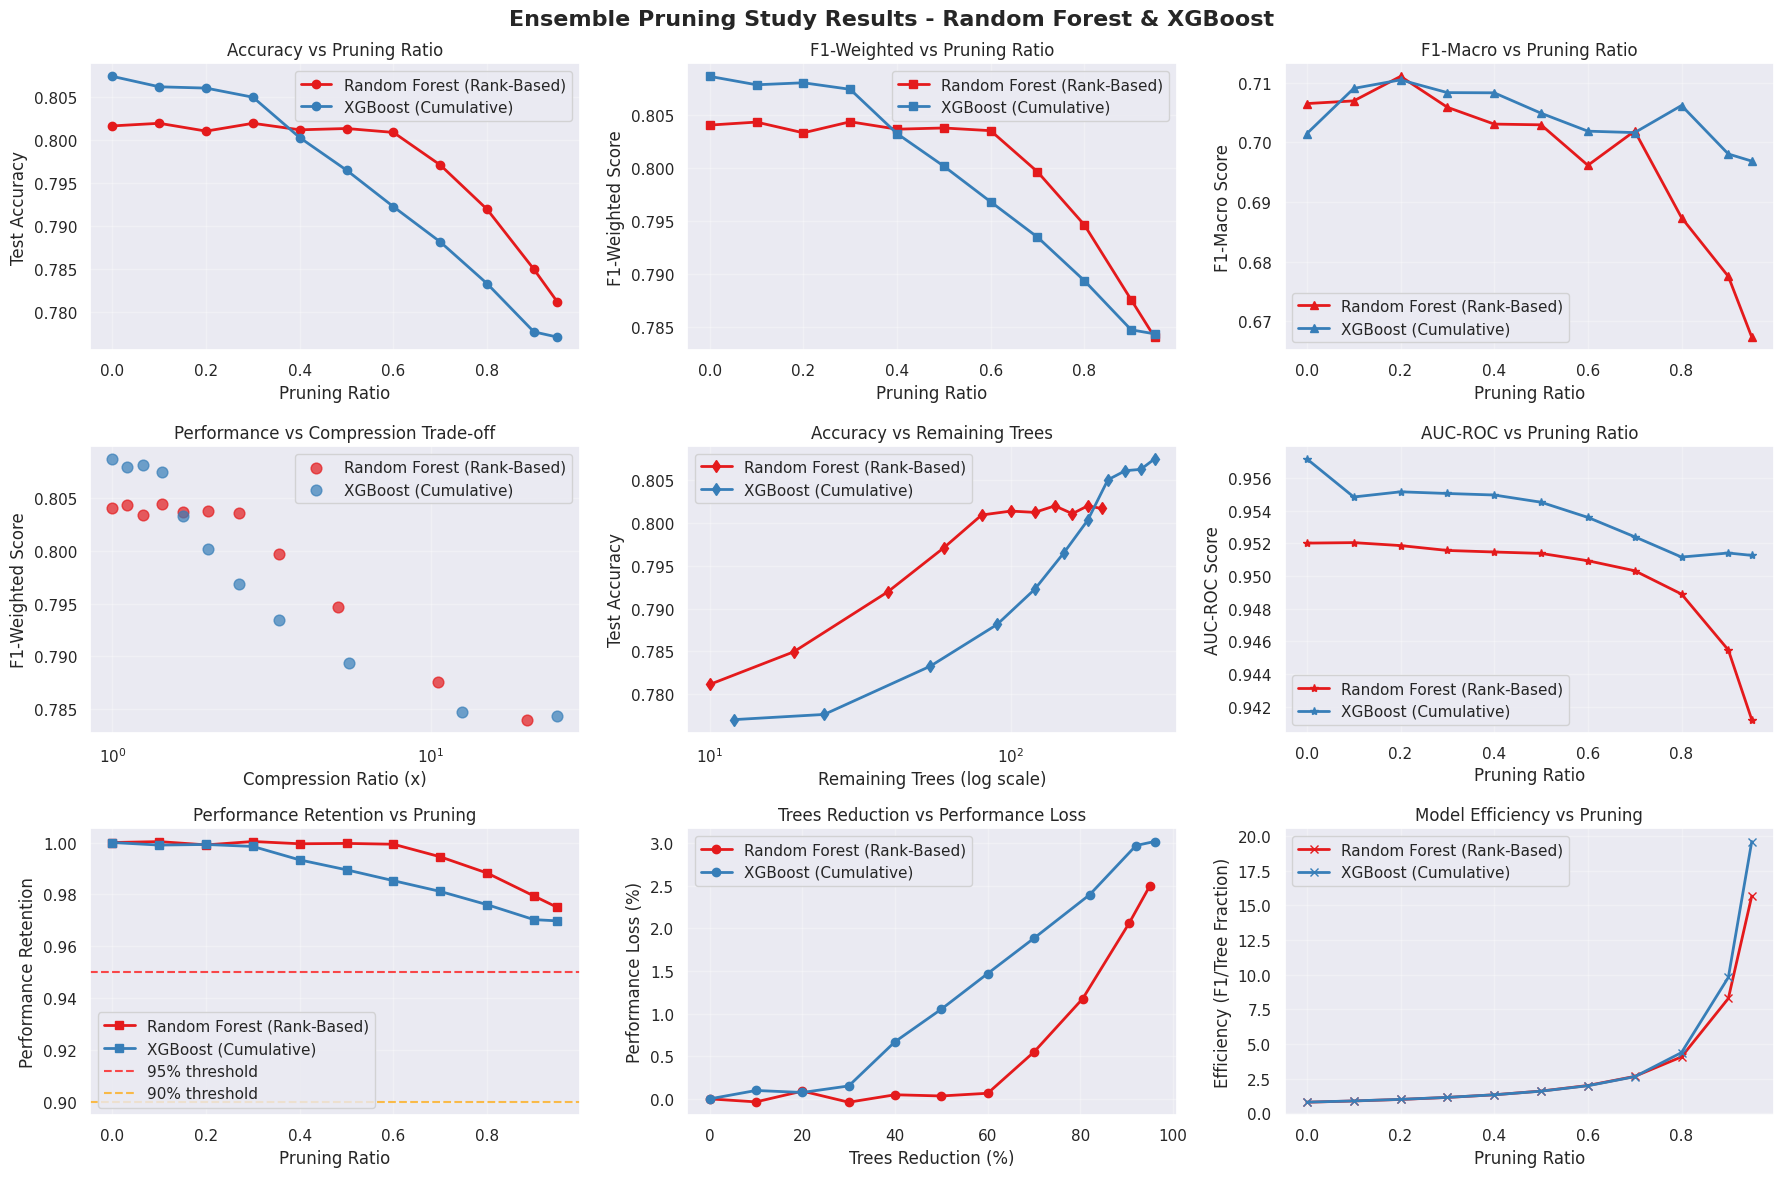


ENSEMBLE PRUNING STUDY - DETAILED REPORT
Random Forest: Rank-Based Pruning | XGBoost: Cumulative Pruning

Random Forest Results:
--------------------------------------------------
Model Type: Random Forest
Pruning Method: Rank-Based
Total Trees: 200
Baseline F1-Weighted: 0.8041
No significant degradation observed within tested range

Best trade-off point:
  Pruning ratio: 80.0%
  Trees: 39 / 200
  Compression: 5.1x
  F1_Weighted: 0.7946
  Performance loss: 1.2%

Maximum compression achieved: 20.0x

XGBoost Results:
--------------------------------------------------
Model Type: XGBoost
Pruning Method: Cumulative
Total Trees: 300
Baseline F1-Weighted: 0.8087
No significant degradation observed within tested range

Best trade-off point:
  Pruning ratio: 70.0%
  Trees: 90 / 300
  Compression: 3.3x
  F1_Weighted: 0.7935
  Performance loss: 1.9%

Maximum compression achieved: 25.0x

COMPARATIVE SUMMARY TABLE - ENSEMBLE MODELS
        Model     Method Pruning_Ratio Trees_Kept Trees_Reduction

,model_name,model_type,pruning_method,pruning_ratio,total_trees,remaining_trees,compression_ratio,accuracy,f1_weighted,f1_macro,auc_roc,auc_pr
0,Random Forest,Random Forest,Rank-Based,0.00,200,200,1.000000,0.801672,0.804086,0.706527,0.952021,0.858084
1,Random Forest,Random Forest,Rank-Based,0.10,200,180,1.111111,0.801976,0.804369,0.706977,0.952051,0.858093
2,Random Forest,Random Forest,Rank-Based,0.20,200,160,1.250000,0.801064,0.803352,0.711088,0.951870,0.857885
3,Random Forest,Random Forest,Rank-Based,0.30,200,140,1.428571,0.801976,0.804400,0.705903,0.951572,0.856937
4,Random Forest,Random Forest,Rank-Based,0.40,200,120,1.666667,0.801216,0.803697,0.703085,0.951476,0.856739
5,Random Forest,Random Forest,Rank-Based,0.50,200,100,2.000000,0.801368,0.803811,0.702962,0.951391,0.856403
6,Random Forest,Random Forest,Rank-Based,0.60,200,80,2.500000,0.800912,0.803556,0.696173,0.950942,0.854903
7,Random Forest,Random Forest,Rank-Based,0.70,200,60,3.333333,0.797112,0.799660,0.701923,0.950330,0.854022
8,Random Forest,Random Forest,Rank-Based,0.80,200,39,5.128205,0.791945,0.794636,0.687403,0.948899,0.850671
9,Random Forest,Random Forest,Rank-Based,0.90,200,19,10.526316,0.784954,0.787539,0.677540,0.945474,0.841389


In [50]:
print("ENSEMBLE PRUNING ABLATION STUDY")
print("Random Forest: Rank-Based Pruning | XGBoost: Cumulative Pruning")
print("="*100)

ensemble_pruning_study = EnsemblePruningAblationStudy()

pruning_ratios_ensemble = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95]

try:
    if 'tree' in gs_rf.best_estimator_.named_steps:
        rf_final_model = gs_rf.best_estimator_.named_steps['tree']
    else:
        raise ValueError("Random Forest model not found")

    print("Random Forest model extracted successfully")

    ensemble_pruning_study.run_rf_pruning_study(
        rf_model=rf_final_model,
        model_name='Random Forest',
        X_test=X_test_processed,
        y_test=y_test_0_indexed,
        X_train=X_train_processed,
        y_train=y_train_0_indexed,
        pruning_ratios=pruning_ratios_ensemble
    )

except Exception as e:
    print(f"Error with Random Forest model: {e}")

try:
    if 'xgb' in gs_xgb.best_estimator_.named_steps:
        xgb_final_model = gs_xgb.best_estimator_.named_steps['xgb']
    else:
        raise ValueError("XGBoost model not found")

    print("XGBoost model extracted successfully")

    ensemble_pruning_study.run_xgb_pruning_study(
        xgb_model=xgb_final_model,
        model_name='XGBoost',
        X_test=X_test_processed,
        y_test=y_test_0_indexed,
        X_train=X_train_processed,
        y_train=y_train_0_indexed,
        pruning_ratios=pruning_ratios_ensemble
    )

except Exception as e:
    print(f"Error with XGBoost model: {e}")

ensemble_pruning_study.plot_ensemble_pruning_results()
ensemble_pruning_study.generate_ensemble_pruning_report()

ensemble_results_df = pd.DataFrame(ensemble_pruning_study.pruning_results)
print(f"\nResults saved to DataFrame with {len(ensemble_results_df)} rows")
print("\nPruning results:")
display(ensemble_results_df)

# Ablation Study Comparation

In [51]:
def compare_all_pruning_methods():
    """
    Compare pruning effectiveness across all model types
    """
    print("\n" + "="*120)
    print("COMPREHENSIVE PRUNING COMPARISON: NEURAL NETWORKS vs ENSEMBLE METHODS")
    print("="*120)

    # Collect data from both studies
    all_models_comparison = []

    # Neural network results
    for _, result in results_df.iterrows():
        if result['pruning_ratio'] in [0.0, 0.3, 0.5, 0.7, 0.9]:
            all_models_comparison.append({
                'Model': result['model_name'],
                'Type': 'Neural Network',
                'Pruning_Method': 'L1 Norm',
                'Pruning_Ratio': result['pruning_ratio'],
                'Accuracy_Test': result['accuracy'],
                'F1_Weighted_Test': result['f1_weighted'],
                'F1_Macro_Test': result['f1_macro'],
                'AUC_ROC_Test': result['auc_roc'],
                'AUC_PR_Test': result['auc_pr'],
                'Compression': result['compression_ratio'],
                'Components': f"{result['active_params']}/{result['total_params']}"
            })

    # Ensemble results
    for _, result in ensemble_results_df.iterrows():
        if result['pruning_ratio'] in [0.0, 0.3, 0.5, 0.7, 0.9]:
            pruning_method = 'Rank-Based' if result['model_name'] == 'Random Forest' else 'Cumulative'
            all_models_comparison.append({
                'Model': result['model_name'],
                'Type': 'Ensemble',
                'Pruning_Method': pruning_method,
                'Pruning_Ratio': result['pruning_ratio'],
                'Accuracy_Test': result['accuracy'],
                'F1_Weighted_Test': result['f1_weighted'],
                'F1_Macro_Test': result['f1_macro'],
                'AUC_ROC_Test': result['auc_roc'],
                'AUC_PR_Test': result['auc_pr'],
                'Compression': result['compression_ratio'],
                'Trees': f"{result['remaining_trees']}/{result['total_trees']}"
            })

    if all_models_comparison:
        comparison_df = pd.DataFrame(all_models_comparison)

        # Create pivot table for better visualization
        pivot_accuracy = comparison_df.pivot_table(
            values='Accuracy_Test',
            index=['Model', 'Type', 'Pruning_Method'],
            columns='Pruning_Ratio',
            fill_value=np.nan
        )
        pivot_f1_weighted = comparison_df.pivot_table(
            values='F1_Weighted_Test',
            index=['Model', 'Type', 'Pruning_Method'],
            columns='Pruning_Ratio',
            fill_value=np.nan
        )
        pivot_auc_roc = comparison_df.pivot_table(
            values='AUC_ROC_Test',
            index=['Model', 'Type', 'Pruning_Method'],
            columns='Pruning_Ratio',
            fill_value=np.nan
        )
        pivot_auc_pr = comparison_df.pivot_table(
            values='AUC_PR_Test',
            index=['Model', 'Type', 'Pruning_Method'],
            columns='Pruning_Ratio',
            fill_value=np.nan
        )

        print("\nAccuracy Performance Across Pruning Levels:")
        print(pivot_accuracy.round(4))

        print("\nF1 Weighted Performance Across Pruning Levels:")
        print(pivot_f1_weighted.round(4))

        print("\nAUC_ROC Weighted Performance Across Pruning Levels:")
        print(pivot_auc_roc.round(4))

        print("\nAUC_PR Weighted Performance Across Pruning Levels:")
        print(pivot_auc_pr.round(4))

        pruning_levels = [0.3, 0.5, 0.7, 0.9]

        print(f"\n{'='*120}")
        print("PERFORMANCE RETENTION AT DIFFERENT PRUNING LEVELS")
        print("="*120)

        for pruning_level in pruning_levels:
            print(f"\n{'-'*60}")
            print(f"PERFORMANCE RETENTION AT {int(pruning_level*100)}% PRUNING")
            print(f"{'-'*60}")

            retention_summary = []
            for model in comparison_df['Model'].unique():
                model_data = comparison_df[comparison_df['Model'] == model]
                baseline = model_data[model_data['Pruning_Ratio'] == 0.0]
                pruned = model_data[model_data['Pruning_Ratio'] == pruning_level]

                if len(baseline) > 0 and len(pruned) > 0:
                    baseline_acc = baseline.iloc[0]['Accuracy_Test']
                    pruned_acc = pruned.iloc[0]['Accuracy_Test']
                    retention = pruned_acc / baseline_acc if baseline_acc != 0 else 0

                    retention_summary.append({
                        'Model': model,
                        'Type': baseline.iloc[0]['Type'],
                        'Method': baseline.iloc[0]['Pruning_Method'],
                        'Baseline_Accuracy': baseline_acc,
                        'Pruned_Accuracy': pruned_acc,
                        'Retention': retention,
                        'Compression': pruned.iloc[0]['Compression']
                    })

            if retention_summary:
                retention_df = pd.DataFrame(retention_summary).sort_values('Retention', ascending=False)
                print(retention_df.round(4))

            best_model = retention_df.iloc[0]
            print(f"\nBEST PRUNING METHOD AT {int(pruning_level*100)}% LEVEL:")
            print(f"Model: {best_model['Model']} ({best_model['Type']})")
            print(f"Method: {best_model['Method']}")
            print(f"Performance Retention: {best_model['Retention']:.1%}")
            print(f"Compression Achieved: {best_model['Compression']:.1f}x")

    else:
        print("No pruning results available for comparison.")

# Run comprehensive comparison
compare_all_pruning_methods()

print("\n" + "="*120)
print("ABLATION STUDY COMPLETE")


COMPREHENSIVE PRUNING COMPARISON: NEURAL NETWORKS vs ENSEMBLE METHODS

Accuracy Performance Across Pruning Levels:
Pruning_Ratio                                   0.0     0.3     0.5     0.7  \
Model         Type           Pruning_Method                                   
KAN           Neural Network L1 Norm         0.7839  0.7850  0.7746  0.7661   
MLP           Neural Network L1 Norm         0.7579  0.7663  0.7685  0.7670   
Random Forest Ensemble       Rank-Based      0.8017  0.8020  0.8014  0.7971   
XGBoost       Ensemble       Cumulative      0.8074  0.8050  0.7965  0.7881   

Pruning_Ratio                                   0.9  
Model         Type           Pruning_Method          
KAN           Neural Network L1 Norm         0.7030  
MLP           Neural Network L1 Norm         0.6508  
Random Forest Ensemble       Rank-Based      0.7850  
XGBoost       Ensemble       Cumulative      0.7777  

F1 Weighted Performance Across Pruning Levels:
Pruning_Ratio                        